<h1><center>MARÍA VICTORIA SANTANA RODRÍGUEZ </center></h1>
<font color="darkblue">
<h3> <center>TFM</center> </h3>
<h3> <center>Julio-Agosto 2024</center> </h3>

<font color="darkblue"><h2> Previsión_MERCANCIAS</h2> 

**Objetivo**: Hacer previsiones de los datos que se tiene de mercancias.

In [1]:
# Se importan los paquetes y librerías necesarias
import pandas as pd
import os
import numpy as np
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error
import itertools
import random
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from xgboost import XGBRegressor
from pmdarima import auto_arima
import joblib
import re
from sklearn.neural_network import MLPRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.svm import SVR

### A. Carga del fichero

Se carga el fichero que previamente ha sido limpiado y procesado

In [2]:
# Ruta en la que se encuentra el fichero
Ruta_Mercancias_Unico = './Ficheros_unico/M_Unico.csv'

# Se carga el DataFrame desde el archivo CSV
Mercancias_merge_pivotar = pd.read_csv(Ruta_Mercancias_Unico, parse_dates=['Fecha'])

# Se comprueba que se carga correctamente
print(Mercancias_merge_pivotar.head())

                Aeropuerto_Base             Tipo      Fecha     Valor
0                      A CORUÑA  M_Total_Llegada 2004-01-01     12613
1  ADOLFO SUÁREZ MADRID-BARAJAS  M_Total_Llegada 2004-01-01  11045571
2                      ALBACETE  M_Total_Llegada 2004-01-01         0
3   ALICANTE-ELCHE MIGUEL HDEZ.  M_Total_Llegada 2004-01-01    187744
4                       ALMERÍA  M_Total_Llegada 2004-01-01      1279


In [3]:
# Se modifica el nombre del fichero
Mercancias_Unico = Mercancias_merge_pivotar

# Se comprueba que tipo de dato hay en cada columna y que es correcto
print(Mercancias_Unico.dtypes)

# Asegurarse de que la fecha sea el índice para el análisis de series temporales
Mercancias_Unico.set_index('Fecha', inplace=True)

# Se comprueba que se carga correctamente
print(Mercancias_Unico.head())

Aeropuerto_Base            object
Tipo                       object
Fecha              datetime64[ns]
Valor                       int64
dtype: object
                         Aeropuerto_Base             Tipo     Valor
Fecha                                                              
2004-01-01                      A CORUÑA  M_Total_Llegada     12613
2004-01-01  ADOLFO SUÁREZ MADRID-BARAJAS  M_Total_Llegada  11045571
2004-01-01                      ALBACETE  M_Total_Llegada         0
2004-01-01   ALICANTE-ELCHE MIGUEL HDEZ.  M_Total_Llegada    187744
2004-01-01                       ALMERÍA  M_Total_Llegada      1279


### B. Predicciones

En este apartado se trata de hacer las predicciones de los datos estudiados, para ello se van a probar distintos modelos hasta encontrar el que mejores resultados arroje. No se van a usar tantos modelos como en para los ficheros de operaciones.

In [4]:
import warnings
warnings.filterwarnings("ignore")

**1. Modelo ARIMA**

Se prueba un modelo Arima, con unos parámetros aleatorios, muy básicos de (1,1,1) para ver que resultados se obtienen, y partir de esta base, al igual que se ha hecho con los otros ficheros. 

In [5]:
# Se crea un diccionario para almacenar las predicciones
Dicc_Predicciones_Mercancias = {}

# Se obtienen todos los aeropurtos y tipos únicos
Aeropuertos = Mercancias_Unico['Aeropuerto_Base'].unique()
Tipos_Mercancias = Mercancias_Unico['Tipo'].unique()

# Se itera sobre cada aeropuerto y tipo
for Aeropuerto in Aeropuertos:
    for Mercancia in Tipos_Mercancias:
        # Se filtra cada aeropuerto y tipo de operación para los datos originales "reales"
        Datos_Reales_Mercancias = Mercancias_Unico[(Mercancias_Unico['Aeropuerto_Base'] == Aeropuerto) & 
                                                   (Mercancias_Unico['Tipo'] == Mercancia)]
        
        # Se comprueba que está ordenado cronologicamente
        Datos_Reales_Mercancias = Datos_Reales_Mercancias.sort_index()
        Datos_Reales_Mercancias = Datos_Reales_Mercancias.asfreq('MS')
        
        # Se entrena el modelo ARIMA en los datos históricos
        try:
            model_arima = ARIMA(Datos_Reales_Mercancias['Valor'], order=(1, 1, 1))
            model_fit_arima = model_arima.fit()

            # Se realizan predicciones hasta los valores que ya se tienen, junio 2024 
            Predicciones_Originales = model_fit_arima.predict(start=Datos_Reales_Mercancias.index[0], end=Datos_Reales_Mercancias.index[-1])

           # Se realizan predicciones para fechas de las que no se tiene valores que ya se tienen, a partir de junio 2024 
            Predicciones_Futuras = model_fit_arima.forecast(steps=12)

            # Se almacenan las predicciones en el diccionario
            Dicc_Predicciones_Mercancias[(Aeropuerto, Mercancia)] = (Predicciones_Originales, Predicciones_Futuras, Datos_Reales_Mercancias.index)
        
        except Exception as e:
            print(f"Error al entrenar el modelo para {Aeropuerto}, {Mercancia}: {e}")

**1-a. Almacenar las predicciones**

In [6]:
# Se crea un DataFrame para almacenar todas las predicciones
Predicciones_Mercancias = pd.DataFrame(columns=['Aeropuerto_Base', 'Tipo', 'Fecha', 'Prediccion'])

for (Aeropuerto, Mercancia), (Predicciones_Originales, Predicciones_Futuras, Fechas_Reales) in Dicc_Predicciones_Mercancias.items():
    # Se guardan en un DataFrame temporal para las predicciones de los datos orginales "reales"
    Predicciones_Originales = pd.DataFrame({
        'Aeropuerto_Base': Aeropuerto,
        'Tipo': Mercancia,
        'Fecha': Fechas_Reales,
        'Prediccion': Predicciones_Originales
    })

    # Se guardan en un DataFrame temporal para las predicciones de fechas futuras
    Fechas_Futuras = pd.date_range(start=Fechas_Reales[-1] + pd.offsets.MonthBegin(1), periods=len(Predicciones_Futuras), freq='MS')
    Predicciones_Futuras = pd.DataFrame({
        'Aeropuerto_Base': Aeropuerto,
        'Tipo': Mercancia,
        'Fecha': Fechas_Futuras,
        'Prediccion': Predicciones_Futuras
    })

    # Se concatenan ambas predicciones y se guardan en un dataframe único
    Predicciones_Mercancias = pd.concat([Predicciones_Mercancias, Predicciones_Originales, Predicciones_Futuras], ignore_index=True)

In [7]:
# Se crea un dataframe para poder comparar las predicciones
Comparacion_Total_Todos_Aeropuertos_M = pd.DataFrame(columns=['Aeropuerto_Base', 'Tipo', 'Fecha', 'Valor Real', 'Prediccion'])

for (Aeropuerto, Mercancia), (Predicciones_Originales, Predicciones_Futuras, Fechas_Reales) in Dicc_Predicciones_Mercancias.items():
    # Se crea un DataFrame temporal para las predicciones históricas con los valores originales
    Tem_Predicciones_Historicas = pd.DataFrame({
        'Aeropuerto_Base': Aeropuerto,
        'Tipo': Mercancia,
        'Fecha': Fechas_Reales,
        'Valor Real': Mercancias_Unico[(Mercancias_Unico['Aeropuerto_Base'] == Aeropuerto) & 
                                        (Mercancias_Unico['Tipo'] == Mercancia)]['Valor'],
        'Prediccion': Predicciones_Originales
    })

    # Se crea un DataFrame para las predicciones futuras
    Fechas_Futuras = pd.date_range(start=Fechas_Reales[-1] + pd.offsets.MonthBegin(1), periods=len(Predicciones_Futuras), freq='MS')
    Temp_Predicciones_Futuras = pd.DataFrame({
        'Aeropuerto_Base': Aeropuerto,
        'Tipo': Mercancia,
        'Fecha': Fechas_Futuras,
        'Valor Real': [None] * len(Predicciones_Futuras),
        'Prediccion': Predicciones_Futuras
    })

    # Se concatena los dos dataframe (históricos y futuros)
    Comparacion_Total_Todos_Aeropuertos_M = pd.concat([Comparacion_Total_Todos_Aeropuertos_M, Tem_Predicciones_Historicas, Temp_Predicciones_Futuras], ignore_index=True)

# Se muestran las últimas filas para ver los valores reales y predicciones
print(Comparacion_Total_Todos_Aeropuertos_M.tail(20))

        Aeropuerto_Base               Tipo      Fecha Valor Real    Prediccion
50548  MURCIA COMBINADO  M_Nacional_Salida 2023-11-01          0  8.321313e-09
50549  MURCIA COMBINADO  M_Nacional_Salida 2023-12-01          0  6.999276e-09
50550  MURCIA COMBINADO  M_Nacional_Salida 2024-01-01          0  5.887277e-09
50551  MURCIA COMBINADO  M_Nacional_Salida 2024-02-01          0  4.951944e-09
50552  MURCIA COMBINADO  M_Nacional_Salida 2024-03-01          0  4.165211e-09
50553  MURCIA COMBINADO  M_Nacional_Salida 2024-04-01          0  3.503470e-09
50554  MURCIA COMBINADO  M_Nacional_Salida 2024-05-01          0  2.946861e-09
50555  MURCIA COMBINADO  M_Nacional_Salida 2024-06-01          0  2.478683e-09
50556  MURCIA COMBINADO  M_Nacional_Salida 2024-07-01       None  2.084886e-09
50557  MURCIA COMBINADO  M_Nacional_Salida 2024-08-01       None  2.567148e-09
50558  MURCIA COMBINADO  M_Nacional_Salida 2024-09-01       None  2.678701e-09
50559  MURCIA COMBINADO  M_Nacional_Salida 2024-10-0

In [8]:
# Se convierten los valores a flotantes si no son nulos y no son cadenas vacías
Comparacion_Total_Todos_Aeropuertos_M['Valor Real'] = Comparacion_Total_Todos_Aeropuertos_M['Valor Real'].apply(lambda x: float(x) if pd.notnull(x) and x != '' else x)
Comparacion_Total_Todos_Aeropuertos_M['Prediccion'] = Comparacion_Total_Todos_Aeropuertos_M['Prediccion'].apply(lambda x: float(x) if pd.notnull(x) and x != '' else x)

# Se reemplazan los puntos por comas en las columnas de interés ('Valor Real' y 'Prediccion')
Comparacion_Total_Todos_Aeropuertos_M['Valor Real'] = Comparacion_Total_Todos_Aeropuertos_M['Valor Real'].apply(lambda x: f"{x:.2f}".replace('.', ',') if pd.notnull(x) else '')
Comparacion_Total_Todos_Aeropuertos_M['Prediccion'] = Comparacion_Total_Todos_Aeropuertos_M['Prediccion'].apply(lambda x: f"{x:.2f}".replace('.', ',') if pd.notnull(x) else '')

# Se muestran las últimas filas para verificar los cambios
print(Comparacion_Total_Todos_Aeropuertos_M.tail(20))

        Aeropuerto_Base               Tipo      Fecha Valor Real Prediccion
50548  MURCIA COMBINADO  M_Nacional_Salida 2023-11-01       0,00       0,00
50549  MURCIA COMBINADO  M_Nacional_Salida 2023-12-01       0,00       0,00
50550  MURCIA COMBINADO  M_Nacional_Salida 2024-01-01       0,00       0,00
50551  MURCIA COMBINADO  M_Nacional_Salida 2024-02-01       0,00       0,00
50552  MURCIA COMBINADO  M_Nacional_Salida 2024-03-01       0,00       0,00
50553  MURCIA COMBINADO  M_Nacional_Salida 2024-04-01       0,00       0,00
50554  MURCIA COMBINADO  M_Nacional_Salida 2024-05-01       0,00       0,00
50555  MURCIA COMBINADO  M_Nacional_Salida 2024-06-01       0,00       0,00
50556  MURCIA COMBINADO  M_Nacional_Salida 2024-07-01                  0,00
50557  MURCIA COMBINADO  M_Nacional_Salida 2024-08-01                  0,00
50558  MURCIA COMBINADO  M_Nacional_Salida 2024-09-01                  0,00
50559  MURCIA COMBINADO  M_Nacional_Salida 2024-10-01                  0,00
50560  MURCI

**1-b. Visualizar predicciones**

**Pasajeros de llegada**, se visualizan las predicciones para un aeropuerto en particular que se guardan en un mismo dataframe, los datos reales con las predicciones de los rangos de fecha de los datos que se tienen junto con un periodo de 12 meses adicionales

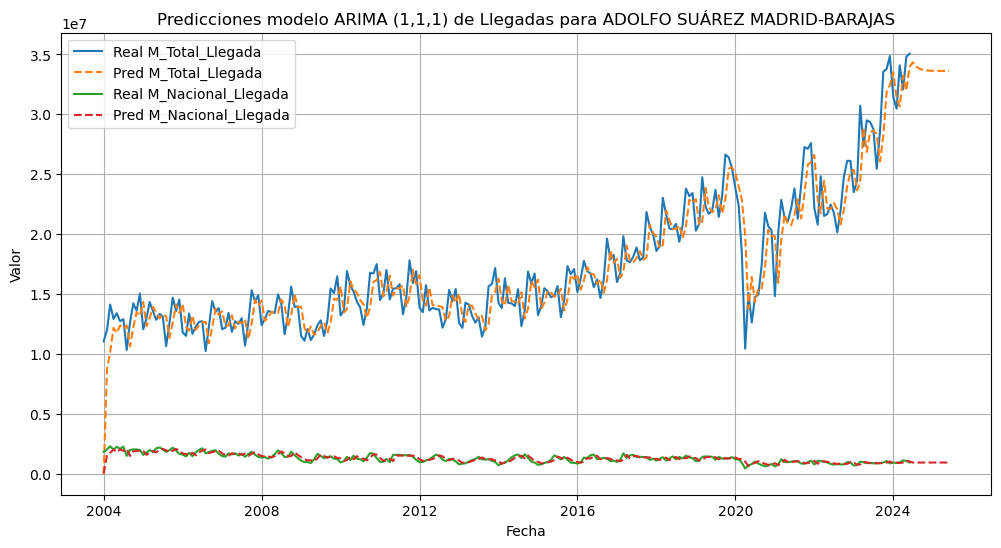

In [9]:
# Se visualizan las predicciones para un aeropuerto específico
Aeropuerto_Prediccion = 'ADOLFO SUÁREZ MADRID-BARAJAS'

# Se filtran los tipos de mercancias disponibles para el aeropuerto seleccionado
Tipos_Mercancias = Mercancias_Unico[Mercancias_Unico['Aeropuerto_Base'] == Aeropuerto_Prediccion]['Tipo'].unique()

# Se filtran los tipos de operación para Llegada
Tipos_Llegada = [tipo for tipo in Tipos_Mercancias if 'Llegada' in tipo]


# Gráfico para operaciones de Llegada
plt.figure(figsize=(12, 6))
for Tipo_Mercancia_Prediccion in Tipos_Llegada:
    # Se filtran los datos reales para el tipo de mercancia
    Datos_Reales_Mercancias = Mercancias_Unico[(Mercancias_Unico['Aeropuerto_Base'] == Aeropuerto_Prediccion) & 
                                               (Mercancias_Unico['Tipo'] == Tipo_Mercancia_Prediccion)]
    
    # Se filtran las predicciones para el tipo de mercancia
    Datos_Predicciones_Mercancias = Predicciones_Mercancias[(Predicciones_Mercancias['Aeropuerto_Base'] == Aeropuerto_Prediccion) & 
                                                            (Predicciones_Mercancias['Tipo'] == Tipo_Mercancia_Prediccion)]
    
    # Se añaden las series reales y predicciones al gráfico
    plt.plot(Datos_Reales_Mercancias.index, Datos_Reales_Mercancias['Valor'], label=f'Real {Tipo_Mercancia_Prediccion}')
    plt.plot(Datos_Predicciones_Mercancias['Fecha'], Datos_Predicciones_Mercancias['Prediccion'], linestyle='--', label=f'Pred {Tipo_Mercancia_Prediccion}')

# Se configura el gráfico
plt.title(f'Predicciones modelo ARIMA (1,1,1) de Llegadas para {Aeropuerto_Prediccion}')
plt.xlabel('Fecha')
plt.ylabel('Valor')
plt.legend()
plt.grid(True)
plt.show()

**Pasajeros de salida**, se visualizan las predicciones, para un aeropuerto en particular que se guardan en un mismo dataframe, los datos reales con las predicciones de los rangos de fecha de los datos que se tienen junto con un periodo de 12 meses adicionales.

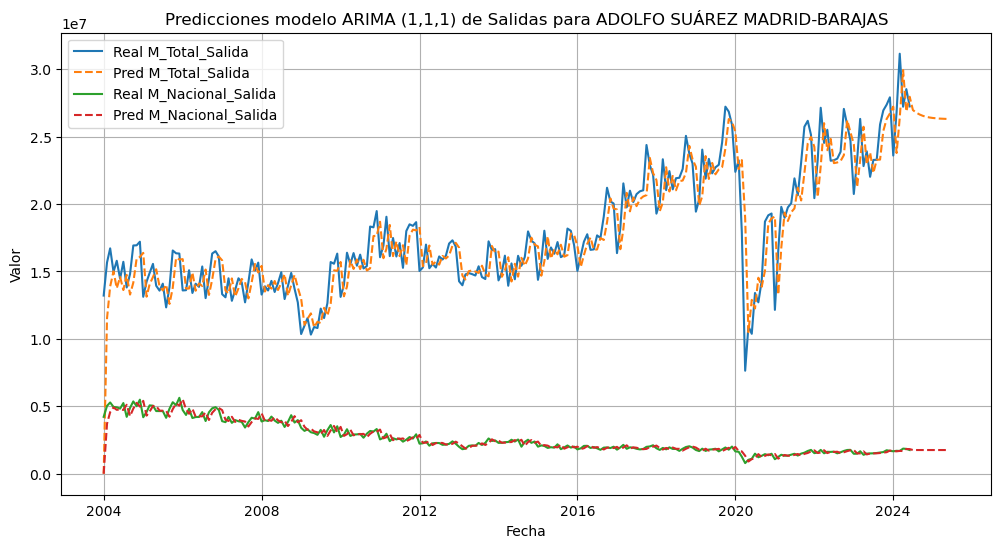

In [10]:
# Se visualizan las predicciones para un aeropuerto específico
Aeropuerto_Prediccion = 'ADOLFO SUÁREZ MADRID-BARAJAS'

# Se filtran los tipos de mercancias disponibles para el aeropuerto seleccionado
Tipos_Mercancias = Mercancias_Unico[Mercancias_Unico['Aeropuerto_Base'] == Aeropuerto_Prediccion]['Tipo'].unique()

# Se filtran los tipos de operación para Salida
Tipos_Salida = [tipo for tipo in Tipos_Mercancias if 'Salida' in tipo]


# Gráfico para operaciones de Llegada
plt.figure(figsize=(12, 6))
for Tipo_Mercancia_Prediccion in Tipos_Salida:
    # Se filtran los datos reales para el tipo de mercancia
    Datos_Reales_Mercancias = Mercancias_Unico[(Mercancias_Unico['Aeropuerto_Base'] == Aeropuerto_Prediccion) & 
                                               (Mercancias_Unico['Tipo'] == Tipo_Mercancia_Prediccion)]
    
    # Se filtran las predicciones para el tipo de mercancia
    Datos_Predicciones_Mercancias = Predicciones_Mercancias[(Predicciones_Mercancias['Aeropuerto_Base'] == Aeropuerto_Prediccion) & 
                                                            (Predicciones_Mercancias['Tipo'] == Tipo_Mercancia_Prediccion)]
    
    # Se añaden las series reales y predicciones al gráfico
    plt.plot(Datos_Reales_Mercancias.index, Datos_Reales_Mercancias['Valor'], label=f'Real {Tipo_Mercancia_Prediccion}')
    plt.plot(Datos_Predicciones_Mercancias['Fecha'], Datos_Predicciones_Mercancias['Prediccion'], linestyle='--', label=f'Pred {Tipo_Mercancia_Prediccion}')

# Se configura el gráfico
plt.title(f'Predicciones modelo ARIMA (1,1,1) de Salidas para {Aeropuerto_Prediccion}')
plt.xlabel('Fecha')
plt.ylabel('Valor')
plt.legend()
plt.grid(True)
plt.show()

**1-c. Métricas de Error**

In [11]:
# Función para calcular SMAPE
def smape(y_true, y_pred):
    return 100 / len(y_true) * np.sum(2 * np.abs(y_pred - y_true) / (np.abs(y_true) + np.abs(y_pred)))

# Se añade la métrica SMAPE
Metricas_Error_Mercancias = pd.DataFrame(columns=['Aeropuerto_Base', 'Tipo', 'MAE', 'RMSE', 'MAPE', 'SMAPE'])

for (Aeropuerto, Mercancia), (Predicciones_Historicas, _, Fechas_Reales) in Dicc_Predicciones_Mercancias.items():
    # Se obtienen los valores reales
    Valores_Reales_Mercancias = Mercancias_Unico[(Mercancias_Unico['Aeropuerto_Base'] == Aeropuerto) & 
                                       (Mercancias_Unico['Tipo'] == Mercancia)]['Valor']
    
    # Se calculan las métricas de error si hay valores reales para comparar
    if len(Valores_Reales_Mercancias) == len(Predicciones_Historicas):
        # MAE - Error Absoluto Medio
        mae = mean_absolute_error(Valores_Reales_Mercancias, Predicciones_Historicas)
        # RMSE - Error Cuatrático Medio
        rmse = np.sqrt(mean_squared_error(Valores_Reales_Mercancias, Predicciones_Historicas))
        # MAPE - Error Porcentual Absoluto Medio
        mape = np.mean(np.abs((Valores_Reales_Mercancias - Predicciones_Historicas) / np.where(Valores_Reales_Mercancias == 0, 1, Valores_Reales_Mercancias))) * 100
        # SMAPE
        smape_value = smape(Valores_Reales_Mercancias, Predicciones_Historicas)
        
        Temp_Metricas_Error = pd.DataFrame({
            'Aeropuerto_Base': [Aeropuerto],
            'Tipo': [Mercancia],
            'MAE': [mae],
            'RMSE': [rmse],
            'MAPE': [mape],
            'SMAPE': [smape_value]
        })
        # Se concatenan las métricas de error
        Metricas_Error_Mercancias = pd.concat([Metricas_Error_Mercancias, Temp_Metricas_Error], ignore_index=True)

    else:
        print(f"Las longitudes no coinciden para {Aeropuerto} - {Mercancia}")

# Se muestran las métricas
print(Metricas_Error_Mercancias)

                  Aeropuerto_Base                Tipo           MAE  \
0                        A CORUÑA     M_Total_Llegada  1.940466e+03   
1                        A CORUÑA  M_Nacional_Llegada  1.664029e+03   
2                        A CORUÑA      M_Total_Salida  2.608567e+03   
3                        A CORUÑA   M_Nacional_Salida  2.597379e+03   
4    ADOLFO SUÁREZ MADRID-BARAJAS     M_Total_Llegada  1.479754e+06   
..                            ...                 ...           ...   
191                     SON BONET   M_Nacional_Salida  4.306685e-02   
192              MURCIA COMBINADO     M_Total_Llegada  1.491730e+02   
193              MURCIA COMBINADO  M_Nacional_Llegada  2.375256e+01   
194              MURCIA COMBINADO      M_Total_Salida  8.736403e+01   
195              MURCIA COMBINADO   M_Nacional_Salida  8.293434e+01   

             RMSE         MAPE       SMAPE  
0    3.336550e+03  1992.677765   34.742268  
1    2.566489e+03  3324.330226   33.767396  
2    3.94381

Se calculan los datos promedios de los errores para así, tener una visión de conjunto

In [12]:
# Se calculan las métricas medias para este modelo 
MAE_promedio = Metricas_Error_Mercancias['MAE'].mean()
RMSE_promedio = Metricas_Error_Mercancias['RMSE'].mean()
MAPE_promedio= Metricas_Error_Mercancias['MAPE'].mean()
SMAPE_promedio = Metricas_Error_Mercancias['SMAPE'].mean()

# Se muestran los resultados ARIMA (1,1,1)
print(f"MAE Promedio ARIMA (1,1,1): {MAE_promedio}")
print(f"RMSE Promedio ARIMA (1,1,1): {RMSE_promedio}")
print(f"MAPE Promedio ARIMA (1,1,1): {MAPE_promedio}%")
print(f"SMAPE Promedio ARIMA (1,1,1): {SMAPE_promedio}%")

MAE Promedio ARIMA (1,1,1): 41960.5465276874
RMSE Promedio ARIMA (1,1,1): 62366.11280555675
MAPE Promedio ARIMA (1,1,1): 7147.310148626099%
SMAPE Promedio ARIMA (1,1,1): 72.25989791629569%


Como se pueden ver en los valores promedio: 

- MAE Promedio ARIMA (1,1,1): 41960.5465276874
- RMSE Promedio ARIMA (1,1,1): 62366.11280555675
- MAPE Promedio ARIMA (1,1,1): 7147.310148626099%
- SMAPE Promedio ARIMA (1,1,1): 72.25989791629569%

Los valores son muy alto para MAE y RSME, lo que indica que las predicciones y la precisión del modelo no es buena, como el RMSE es mayor que el MAE indica que hay grandes errores de predicción, se siguen buscando otros modelos

**2. Modelo Grid Search - ARIMA - 1 intento**

El segundo modelo es usar un Grid Search, para optimizar los hiperparámetros del modelo anterior, en teoría deberían de mejorar los resultados, ya que se están buscando los mejores para este conjunto de datos, y que así ofrezca un mejor rendimiento del mismo.

In [14]:
# Se definen los parámetros p, d, q
p = d = q = range(0, 4)  # Esto probará valores de 0 a 3 para p, d, q
pdq = list(itertools.product(p, d, q))

# Se almcenan los mejores resultados
best_aic = float('inf')
best_params = None

# Se itera sobre cada combinación de parámetros
for params in pdq:
    try:
        # Se entrena el modelo ARIMA con los parámetros actuales
        model_arima = ARIMA(Datos_Reales_Mercancias['Valor'], order=params)
        model_fit_arima = model_arima.fit()
        
        # Se calcular el AIC
        aic = model_fit_arima.aic
        
        # Si el AIC actual es mejor que el anterior, actualizar los mejores parámetros
        if aic < best_aic:
            best_aic = aic
            best_params = params
            
    except Exception as e:
        print(f"Error con los parámetros {params}: {e}")
        continue

print(f'Mejor conjunto de parámetros: {best_params} con AIC: {best_aic}')

Mejor conjunto de parámetros: (3, 0, 3) con AIC: 6823.36307214712


El mejor conjunto de parámetros con Grind Search que se obtiene para los datos de operaciones es el (3, 0, 3)

- p (componente autorregresivo)=3
- d (componente integrado) =0
- q (media móvil) =3

**2-a. Se reentrena el modelo con los parámetros obtenidos, Modelo Grid Search - ARIMA - 1 intento**

In [13]:
# Se crea un diccionario para almacenar las predicciones
Dicc_Predicciones_Mercancias_GS = {}

# Se obtienen todos los aeropurtos y tipos únicos
Aeropuertos = Mercancias_Unico['Aeropuerto_Base'].unique()
Tipos_Mercancias = Mercancias_Unico['Tipo'].unique()

# Se itera sobre cada aeropuerto y tipo
for Aeropuerto in Aeropuertos:
    for Mercancia in Tipos_Mercancias:
        # Se filtra cada aeropuerto y tipo de operación para los datos originales "reales"
        Datos_Reales_Mercancias_GS = Mercancias_Unico[(Mercancias_Unico['Aeropuerto_Base'] == Aeropuerto) & 
                                                   (Mercancias_Unico['Tipo'] == Mercancia)]
        
        # Se comprueba que está ordenado cronologicamente
        Datos_Reales_Mercancias_GS = Datos_Reales_Mercancias_GS.sort_index()

        # Se entrena el modelo ARIMA en los datos históricos
        try:
            model_arima_GS = ARIMA(Datos_Reales_Mercancias_GS['Valor'], order=(3, 0, 3))
            model_fit_arima_GS = model_arima_GS.fit()

            # Se realizan predicciones hasta los valores que ya se tienen, junio 2024 
            Predicciones_Originales_GS = model_fit_arima_GS.predict(start=Datos_Reales_Mercancias_GS.index[0], end=Datos_Reales_Mercancias_GS.index[-1])

           # Se realizan predicciones para fechas de las que no se tiene valores que ya se tienen, a partir de junio 2024 
            Predicciones_Futuras_GS = model_fit_arima_GS.forecast(steps=12)

            # Se almacenan las predicciones en el diccionario
            Dicc_Predicciones_Mercancias_GS[(Aeropuerto, Mercancia)] = (Predicciones_Originales_GS, Predicciones_Futuras_GS, Datos_Reales_Mercancias_GS.index)
        
        except Exception as e:
            print(f"Error al entrenar el modelo para {Aeropuerto}, {Mercancia}: {e}")

**2-b. Dataframe en el que se guardan las predicciones y los datos reales**

In [15]:
# Se crea un dataframe para poder comparar las predicciones
Comparacion_Total_Todos_Aeropuertos_GS_M = pd.DataFrame(columns=['Aeropuerto_Base', 'Tipo', 'Fecha', 'Valor Real', 'Prediccion'])

for (Aeropuerto, Mercancia), (Predicciones_Originales_GS, Predicciones_Futuras_GS, Fechas_Reales) in Dicc_Predicciones_Mercancias.items():
    # Se crea un DataFrame temporal para las predicciones históricas con los valores originales
    Tem_Predicciones_Historicas_GS = pd.DataFrame({
        'Aeropuerto_Base': Aeropuerto,
        'Tipo': Mercancia,
        'Fecha': Fechas_Reales,
        'Valor Real': Mercancias_Unico[(Mercancias_Unico['Aeropuerto_Base'] == Aeropuerto) & 
                                        (Mercancias_Unico['Tipo'] == Mercancia)]['Valor'],
        'Prediccion': Predicciones_Originales_GS
    })

    # Se crea un DataFrame para las predicciones futuras
    Fechas_Futuras = pd.date_range(start=Fechas_Reales[-1] + pd.offsets.MonthBegin(1), periods=len(Predicciones_Futuras_GS), freq='MS')
    Temp_Predicciones_Futuras_GS = pd.DataFrame({
        'Aeropuerto_Base': Aeropuerto,
        'Tipo': Mercancia,
        'Fecha': Fechas_Futuras,
        'Valor Real': [None] * len(Predicciones_Futuras_GS),
        'Prediccion': Predicciones_Futuras_GS
    })

    # Se concatena los dos dataframe (históricos y futuros)
    Comparacion_Total_Todos_Aeropuertos_GS_M = pd.concat([Comparacion_Total_Todos_Aeropuertos_GS_M, Tem_Predicciones_Historicas_GS, Temp_Predicciones_Futuras_GS], ignore_index=True)

# Se muestran las últimas filas para ver los valores reales y predicciones
print(Comparacion_Total_Todos_Aeropuertos_GS_M.tail(20))

        Aeropuerto_Base               Tipo      Fecha Valor Real    Prediccion
50548  MURCIA COMBINADO  M_Nacional_Salida 2023-11-01          0  8.321313e-09
50549  MURCIA COMBINADO  M_Nacional_Salida 2023-12-01          0  6.999276e-09
50550  MURCIA COMBINADO  M_Nacional_Salida 2024-01-01          0  5.887277e-09
50551  MURCIA COMBINADO  M_Nacional_Salida 2024-02-01          0  4.951944e-09
50552  MURCIA COMBINADO  M_Nacional_Salida 2024-03-01          0  4.165211e-09
50553  MURCIA COMBINADO  M_Nacional_Salida 2024-04-01          0  3.503470e-09
50554  MURCIA COMBINADO  M_Nacional_Salida 2024-05-01          0  2.946861e-09
50555  MURCIA COMBINADO  M_Nacional_Salida 2024-06-01          0  2.478683e-09
50556  MURCIA COMBINADO  M_Nacional_Salida 2024-07-01       None  2.084886e-09
50557  MURCIA COMBINADO  M_Nacional_Salida 2024-08-01       None  2.567148e-09
50558  MURCIA COMBINADO  M_Nacional_Salida 2024-09-01       None  2.678701e-09
50559  MURCIA COMBINADO  M_Nacional_Salida 2024-10-0

In [16]:
# Se convierten los valores a flotantes si no son nulos y no son cadenas vacías
Comparacion_Total_Todos_Aeropuertos_GS_M['Valor Real'] = Comparacion_Total_Todos_Aeropuertos_GS_M['Valor Real'].apply(lambda x: float(x) if pd.notnull(x) and x != '' else x)
Comparacion_Total_Todos_Aeropuertos_GS_M['Prediccion'] = Comparacion_Total_Todos_Aeropuertos_GS_M['Prediccion'].apply(lambda x: float(x) if pd.notnull(x) and x != '' else x)

# Se reemplazan los puntos por comas en las columnas de interés ('Valor Real' y 'Prediccion')
Comparacion_Total_Todos_Aeropuertos_GS_M['Valor Real'] = Comparacion_Total_Todos_Aeropuertos_GS_M['Valor Real'].apply(lambda x: f"{x:.2f}".replace('.', ',') if pd.notnull(x) else '')
Comparacion_Total_Todos_Aeropuertos_GS_M['Prediccion'] = Comparacion_Total_Todos_Aeropuertos_GS_M['Prediccion'].apply(lambda x: f"{x:.2f}".replace('.', ',') if pd.notnull(x) else '')

# Se muestran las últimas filas para verificar los cambios
print(Comparacion_Total_Todos_Aeropuertos_GS_M.tail(20))

        Aeropuerto_Base               Tipo      Fecha Valor Real Prediccion
50548  MURCIA COMBINADO  M_Nacional_Salida 2023-11-01       0,00       0,00
50549  MURCIA COMBINADO  M_Nacional_Salida 2023-12-01       0,00       0,00
50550  MURCIA COMBINADO  M_Nacional_Salida 2024-01-01       0,00       0,00
50551  MURCIA COMBINADO  M_Nacional_Salida 2024-02-01       0,00       0,00
50552  MURCIA COMBINADO  M_Nacional_Salida 2024-03-01       0,00       0,00
50553  MURCIA COMBINADO  M_Nacional_Salida 2024-04-01       0,00       0,00
50554  MURCIA COMBINADO  M_Nacional_Salida 2024-05-01       0,00       0,00
50555  MURCIA COMBINADO  M_Nacional_Salida 2024-06-01       0,00       0,00
50556  MURCIA COMBINADO  M_Nacional_Salida 2024-07-01                  0,00
50557  MURCIA COMBINADO  M_Nacional_Salida 2024-08-01                  0,00
50558  MURCIA COMBINADO  M_Nacional_Salida 2024-09-01                  0,00
50559  MURCIA COMBINADO  M_Nacional_Salida 2024-10-01                  0,00
50560  MURCI

**2-c. Visualización de las predicciones** 

In [17]:
# Se crea un DataFrame para almacenar todas las predicciones
Predicciones_Mercancias_GS = pd.DataFrame(columns=['Aeropuerto_Base', 'Tipo', 'Fecha', 'Prediccion'])

for (Aeropuerto, Mercancia), (Predicciones_Originales_GS, Predicciones_Futuras_GS, Fechas_Reales) in Dicc_Predicciones_Mercancias.items():
    # Se guardan en un DataFrame temporal para las predicciones de los datos orginales "reales"
    Tem_Predicciones_Historicas_GS = pd.DataFrame({
        'Aeropuerto_Base': Aeropuerto,
        'Tipo': Mercancia,
        'Fecha': Fechas_Reales,
        'Prediccion': Predicciones_Originales_GS
    })

    # Se guardan en un DataFrame temporal para las predicciones de fechas futuras
    Fechas_Futuras = pd.date_range(start=Fechas_Reales[-1] + pd.offsets.MonthBegin(1), periods=len(Predicciones_Futuras_GS), freq='MS')
    Temp_Predicciones_Futuras_GS = pd.DataFrame({
        'Aeropuerto_Base': Aeropuerto,
        'Tipo': Mercancia,
        'Fecha': Fechas_Futuras,
        'Prediccion': Predicciones_Futuras_GS
    })

    # Se concatenan ambas predicciones y se guardan en un dataframe único
    Predicciones_Mercancias_GS = pd.concat([Predicciones_Mercancias_GS, Tem_Predicciones_Historicas_GS, Temp_Predicciones_Futuras_GS], ignore_index=True)

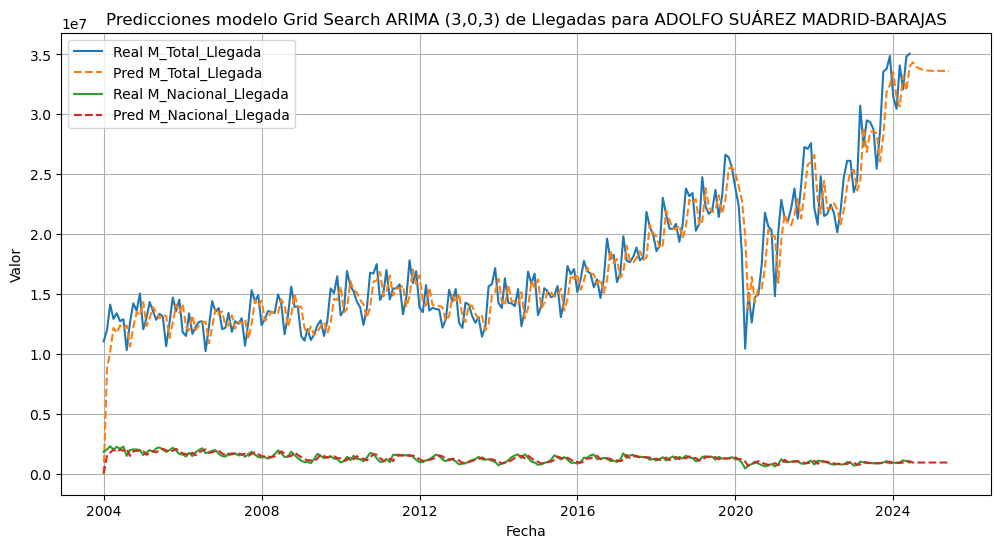

In [18]:
# Se visualizan las predicciones para un aeropuerto específico
Aeropuerto_Prediccion = 'ADOLFO SUÁREZ MADRID-BARAJAS'

# Se filtran los tipos de operación disponibles para el aeropuerto seleccionado
Tipos_Mercancias = Mercancias_Unico[Mercancias_Unico['Aeropuerto_Base'] == Aeropuerto_Prediccion]['Tipo'].unique()

# Se filtran los tipos de operación para Llegada
Tipos_Llegada = [tipo for tipo in Tipos_Mercancias if 'Llegada' in tipo]


# Gráfico para operaciones de Llegada
plt.figure(figsize=(12, 6))
for Tipo_Mercancias_Prediccion in Tipos_Llegada:
    # Se filtran los datos reales para el tipo de operación
    Datos_Reales_Mercancias_GS = Mercancias_Unico[(Mercancias_Unico['Aeropuerto_Base'] == Aeropuerto_Prediccion) & 
                                               (Mercancias_Unico['Tipo'] == Tipo_Mercancias_Prediccion)]
    
    # Se filtran las predicciones para el tipo de operación
    Datos_Predicciones_Mercancias_GS = Predicciones_Mercancias_GS[(Predicciones_Mercancias_GS['Aeropuerto_Base'] == Aeropuerto_Prediccion) & 
                                                            (Predicciones_Mercancias_GS['Tipo'] == Tipo_Mercancias_Prediccion)]
    
    # Se añaden las series reales y predicciones al gráfico
    plt.plot(Datos_Reales_Mercancias_GS.index, Datos_Reales_Mercancias_GS['Valor'], label=f'Real {Tipo_Mercancias_Prediccion}')
    plt.plot(Datos_Predicciones_Mercancias_GS['Fecha'], Datos_Predicciones_Mercancias_GS['Prediccion'], linestyle='--', label=f'Pred {Tipo_Mercancias_Prediccion}')

# Se configura el gráfico
plt.title(f'Predicciones modelo Grid Search ARIMA (3,0,3) de Llegadas para {Aeropuerto_Prediccion}')
plt.xlabel('Fecha')
plt.ylabel('Valor')
plt.legend()
plt.grid(True)
plt.show()

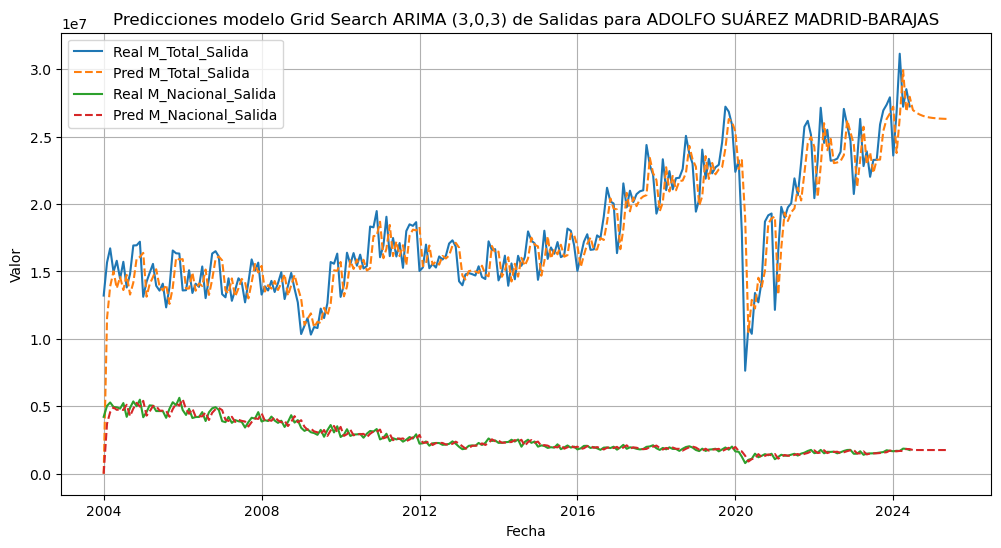

In [19]:
# Se visualizan las predicciones para un aeropuerto específico
Aeropuerto_Prediccion = 'ADOLFO SUÁREZ MADRID-BARAJAS'

# Se filtran los tipos de operación disponibles para el aeropuerto seleccionado
Tipos_Mercancias = Mercancias_Unico[Mercancias_Unico['Aeropuerto_Base'] == Aeropuerto_Prediccion]['Tipo'].unique()

# Se filtran los tipos de operación para Salida
Tipos_Salida = [tipo for tipo in Tipos_Mercancias if 'Salida' in tipo]


# Gráfico para operaciones de Salida
plt.figure(figsize=(12, 6))
for Tipo_Mercancias_Prediccion in Tipos_Salida:
    # Se filtran los datos reales para el tipo de operación
    Datos_Reales_Mercancias_GS = Mercancias_Unico[(Mercancias_Unico['Aeropuerto_Base'] == Aeropuerto_Prediccion) & 
                                               (Mercancias_Unico['Tipo'] == Tipo_Mercancias_Prediccion)]
    
    # Se filtran las predicciones para el tipo de operación
    Datos_Predicciones_Mercancias_GS = Predicciones_Mercancias_GS[(Predicciones_Mercancias_GS['Aeropuerto_Base'] == Aeropuerto_Prediccion) & 
                                                            (Predicciones_Mercancias_GS['Tipo'] == Tipo_Mercancias_Prediccion)]
    
    # Se añaden las series reales y predicciones al gráfico
    plt.plot(Datos_Reales_Mercancias_GS.index, Datos_Reales_Mercancias_GS['Valor'], label=f'Real {Tipo_Mercancias_Prediccion}')
    plt.plot(Datos_Predicciones_Mercancias_GS['Fecha'], Datos_Predicciones_Mercancias_GS['Prediccion'], linestyle='--', label=f'Pred {Tipo_Mercancias_Prediccion}')

# Se configura el gráfico
plt.title(f'Predicciones modelo Grid Search ARIMA (3,0,3) de Salidas para {Aeropuerto_Prediccion}')
plt.xlabel('Fecha')
plt.ylabel('Valor')
plt.legend()
plt.grid(True)
plt.show()

**2-d. Métricas de error**

In [20]:
# Función para calcular SMAPE
def smape(y_true_GS, y_pred_GS):
    return 100 / len(y_true_GS) * np.sum(2 * np.abs(y_pred_GS - y_true_GS) / (np.abs(y_true_GS) + np.abs(y_pred_GS)))

# Se añade la métrica SMAPE
Metricas_Error_Mercancias_GS = pd.DataFrame(columns=['Aeropuerto_Base', 'Tipo', 'MAE', 'RMSE', 'MAPE', 'SMAPE'])

for (Aeropuerto, Mercancia), (Predicciones_Originales_GS, _, Fechas_Reales) in Dicc_Predicciones_Mercancias.items():
    # Se obtienen los valores reales
    Valores_Reales_Mercancia_GS = Mercancias_Unico[(Mercancias_Unico['Aeropuerto_Base'] == Aeropuerto) & 
                                       (Mercancias_Unico['Tipo'] == Mercancia)]['Valor']
    
    # Se calculan las métricas de error si hay valores reales para comparar
    if len(Valores_Reales_Mercancia_GS) == len(Predicciones_Originales_GS):
        # MAE - Error Absoluto Medio
        mae = mean_absolute_error(Valores_Reales_Mercancia_GS, Predicciones_Originales_GS)
        # RMSE - Error Cuatrático Medio
        rmse = np.sqrt(mean_squared_error(Valores_Reales_Mercancia_GS, Predicciones_Originales_GS))
        # MAPE - Error Porcentual Absoluto Medio
        mape = np.mean(np.abs((Valores_Reales_Mercancia_GS - Predicciones_Originales_GS) / np.where(Valores_Reales_Mercancia_GS == 0, 1, Valores_Reales_Mercancia_GS))) * 100
        # SMAPE
        smape_value = smape(Valores_Reales_Mercancia_GS, Predicciones_Originales_GS)
        
        Temp_Metricas_Error_GS = pd.DataFrame({
            'Aeropuerto_Base': [Aeropuerto],
            'Tipo': [Mercancia],
            'MAE': [mae],
            'RMSE': [rmse],
            'MAPE': [mape],
            'SMAPE': [smape_value]
        })
        # Se concatenan las métricas de error
        Metricas_Error_Mercancias_GS = pd.concat([Metricas_Error_Mercancias_GS, Temp_Metricas_Error_GS], ignore_index=True)
    else:
        print(f"Las longitudes no coinciden para {Aeropuerto} - {Mercancia}")

# Se muestran las métricas
print(Metricas_Error_Mercancias_GS)

                  Aeropuerto_Base                Tipo           MAE  \
0                        A CORUÑA     M_Total_Llegada  1.940466e+03   
1                        A CORUÑA  M_Nacional_Llegada  1.664029e+03   
2                        A CORUÑA      M_Total_Salida  2.608567e+03   
3                        A CORUÑA   M_Nacional_Salida  2.597379e+03   
4    ADOLFO SUÁREZ MADRID-BARAJAS     M_Total_Llegada  1.479754e+06   
..                            ...                 ...           ...   
191                     SON BONET   M_Nacional_Salida  4.306685e-02   
192              MURCIA COMBINADO     M_Total_Llegada  1.491730e+02   
193              MURCIA COMBINADO  M_Nacional_Llegada  2.375256e+01   
194              MURCIA COMBINADO      M_Total_Salida  8.736403e+01   
195              MURCIA COMBINADO   M_Nacional_Salida  8.293434e+01   

             RMSE         MAPE       SMAPE  
0    3.336550e+03  1992.677765   34.742268  
1    2.566489e+03  3324.330226   33.767396  
2    3.94381

**2-e. Métricas de error promedias de todo el conjunto**

Se calculan los datos promedios de los errores para así, tener una visión de conjunto

In [21]:
# Se calculan las métricas medias para este modelo 
MAE_promedio_GS = Metricas_Error_Mercancias_GS['MAE'].mean()
RMSE_promedio_GS = Metricas_Error_Mercancias_GS['RMSE'].mean()
MAPE_promedio_GS = Metricas_Error_Mercancias_GS['MAPE'].mean()
SMAPE_promedio_GS = Metricas_Error_Mercancias_GS['SMAPE'].mean()


# Se muestran los resultados GRID SEARCH ARIMA (3,0,3)
print(f"MAE Promedio GRID SEARCH ARIMA (3,0,3): {MAE_promedio_GS}")
print(f"RMSE Promedio GRID SEARCH ARIMA (3,0,3): {RMSE_promedio_GS}")
print(f"MAPE Promedio GRID SEARCH ARIMA (3,0,3): {MAPE_promedio_GS}%")
print(f"SMAPE Promedio GRID SEARCH ARIMA (3,0,3): {SMAPE_promedio_GS}%")

MAE Promedio GRID SEARCH ARIMA (3,0,3): 41960.5465276874
RMSE Promedio GRID SEARCH ARIMA (3,0,3): 62366.11280555675
MAPE Promedio GRID SEARCH ARIMA (3,0,3): 7147.310148626099%
SMAPE Promedio GRID SEARCH ARIMA (3,0,3): 72.25989791629569%


- MAE Promedio ARIMA (1,1,1): 41960.5465276874
- RMSE Promedio ARIMA (1,1,1): 62366.11280555675
- MAPE Promedio ARIMA (1,1,1): 7147.310148626099%
- SMAPE Promedio ARIMA (1,1,1): 72.25989791629569%

Los resultados son los mismos ya que este fichero contiene muchos 0, y encontrar un modelo que mejore predicciones y que se ajuste bien para todos los casos va a ser dificil.

**3. Modelo Grid Search - ARIMA - 2 intento**

Se modifica el rango de los hiperparámetros para ver si se obtienen mejores resultados

In [22]:
p = d = q = range(0, 6)  # Esto probará valores de 0 a 5 para p, d, q
pdq = list(itertools.product(p, d, q))

# Se almcenan los mejores resultados
best_aic = float('inf')
best_params = None

# Se itera sobre cada combinación de parámetros
for params in pdq:
    try:
        # Se entrena el modelo ARIMA con los parámetros actuales
        model_arima = ARIMA(Datos_Reales_Mercancias_GS['Valor'], order=params)
        model_fit_arima = model_arima.fit()
        
        # Se calcular el AIC
        aic = model_fit_arima.aic
        
        # Si el AIC actual es mejor que el anterior, actualizar los mejores parámetros
        if aic < best_aic:
            best_aic = aic
            best_params = params
            
    except Exception as e:
        print(f"Error con los parámetros {params}: {e}")
        continue

print(f'Mejor conjunto de parámetros: {best_params} con AIC: {best_aic}')

Mejor conjunto de parámetros: (5, 0, 4) con AIC: 6810.109681705969


**3-a. Se reentrena el modelo con los parámetros obtenidos, Modelo Grid Search - ARIMA - 2 intento**

Habiendo aumentado el rango de los hiperparámetros del Grid Search de 3, a 6, se obtiene otro conjunto de mejores hiperparámetros (5,0,4)

In [23]:
# Se crea un diccionario para almacenar las predicciones
Dicc_Predicciones_Mercancias_GS2 = {}

# Se obtienen todos los aeropurtos y tipos únicos
Aeropuertos = Mercancias_Unico['Aeropuerto_Base'].unique()
Tipos_Mercancias = Mercancias_Unico['Tipo'].unique()

# Se itera sobre cada aeropuerto y tipo
for Aeropuerto in Aeropuertos:
    for Mercancia in Tipos_Mercancias:
        # Se filtra cada aeropuerto y tipo de operación para los datos originales "reales"
        Datos_Reales_Mercancias_GS2 = Mercancias_Unico[(Mercancias_Unico['Aeropuerto_Base'] == Aeropuerto) & 
                                                   (Mercancias_Unico['Tipo'] == Mercancia)]
        
        # Se comprueba que está ordenado cronologicamente
        Datos_Reales_Mercancias_GS2 = Datos_Reales_Mercancias_GS2.sort_index()

        # Se entrena el modelo ARIMA en los datos históricos
        try:
            model_arima_GS = ARIMA(Datos_Reales_Mercancias_GS2['Valor'], order=(5, 0, 4))
            model_fit_arima_GS = model_arima_GS.fit()

            # Se realizan predicciones hasta los valores que ya se tienen, junio 2024 
            Predicciones_Originales_GS2 = model_fit_arima_GS.predict(start=Datos_Reales_Mercancias_GS2.index[0], end=Datos_Reales_Mercancias_GS2.index[-1])

           # Se realizan predicciones para fechas de las que no se tiene valores que ya se tienen, a partir de junio 2024 
            Predicciones_Futuras_GS2 = model_fit_arima_GS.forecast(steps=12)

            # Se almacenan las predicciones en el diccionario
            Dicc_Predicciones_Mercancias_GS2[(Aeropuerto, Mercancia)] = (Predicciones_Originales_GS2, Predicciones_Futuras_GS2, Datos_Reales_Mercancias_GS2.index)
        
        except Exception as e:
            print(f"Error al entrenar el modelo para {Aeropuerto}, {Mercancia}: {e}")

Error al entrenar el modelo para MURCIA COMBINADO, M_Total_Salida: LU decomposition error.


Como da error por no poder encontrar una solución válida para los datos, se prueba con otros hiperparámetros (4,1,4)

In [22]:
# Se crea un diccionario para almacenar las predicciones
Dicc_Predicciones_Mercancias_GS2 = {}

# Se obtienen todos los aeropurtos y tipos únicos
Aeropuertos = Mercancias_Unico['Aeropuerto_Base'].unique()
Tipos_Mercancias = Mercancias_Unico['Tipo'].unique()

# Se itera sobre cada aeropuerto y tipo
for Aeropuerto in Aeropuertos:
    for Mercancia in Tipos_Mercancias:
        # Se filtra cada aeropuerto y tipo de operación para los datos originales "reales"
        Datos_Reales_Mercancias_GS2 = Mercancias_Unico[(Mercancias_Unico['Aeropuerto_Base'] == Aeropuerto) & 
                                                   (Mercancias_Unico['Tipo'] == Mercancia)]
        
        # Se comprueba que está ordenado cronologicamente
        Datos_Reales_Mercancias_GS2 = Datos_Reales_Mercancias_GS2.sort_index()

        # Se entrena el modelo ARIMA en los datos históricos
        try:
            model_arima_GS = ARIMA(Datos_Reales_Mercancias_GS2['Valor'], order=(4, 1, 4))
            model_fit_arima_GS = model_arima_GS.fit()

            # Se realizan predicciones hasta los valores que ya se tienen, junio 2024 
            Predicciones_Originales_GS2 = model_fit_arima_GS.predict(start=Datos_Reales_Mercancias_GS2.index[0], end=Datos_Reales_Mercancias_GS2.index[-1])

           # Se realizan predicciones para fechas de las que no se tiene valores que ya se tienen, a partir de junio 2024 
            Predicciones_Futuras_GS2 = model_fit_arima_GS.forecast(steps=12)

            # Se almacenan las predicciones en el diccionario
            Dicc_Predicciones_Mercancias_GS2[(Aeropuerto, Mercancia)] = (Predicciones_Originales_GS2, Predicciones_Futuras_GS2, Datos_Reales_Mercancias_GS2.index)
        
        except Exception as e:
            print(f"Error al entrenar el modelo para {Aeropuerto}, {Mercancia}: {e}")

**3-b. Dataframe en el que se guardan las predicciones y los datos reales**

In [23]:
# Se crea un dataframe para poder comparar las predicciones
Comparacion_Total_Todos_Aeropuertos_GS2_M = pd.DataFrame(columns=['Aeropuerto_Base', 'Tipo', 'Fecha', 'Valor Real', 'Prediccion'])

for (Aeropuerto, Mercancia), (Predicciones_Originales_GS2, Predicciones_Futuras_GS2, Fechas_Reales) in Dicc_Predicciones_Mercancias_GS2.items():
    # Se crea un DataFrame temporal para las predicciones históricas con los valores originales
    Tem_Predicciones_Historicas_GS2 = pd.DataFrame({
        'Aeropuerto_Base': Aeropuerto,
        'Tipo': Mercancia,
        'Fecha': Fechas_Reales,
        'Valor Real': Mercancias_Unico[(Mercancias_Unico['Aeropuerto_Base'] == Aeropuerto) & 
                                        (Mercancias_Unico['Tipo'] == Mercancia)]['Valor'],
        'Prediccion': Predicciones_Originales_GS2
    })

    # Se crea un DataFrame para las predicciones futuras
    Fechas_Futuras = pd.date_range(start=Fechas_Reales[-1] + pd.offsets.MonthBegin(1), periods=len(Predicciones_Futuras_GS2), freq='MS')
    Temp_Predicciones_Futuras_GS2 = pd.DataFrame({
        'Aeropuerto_Base': Aeropuerto,
        'Tipo': Mercancia,
        'Fecha': Fechas_Futuras,
        'Valor Real': [None] * len(Predicciones_Futuras_GS2),
        'Prediccion': Predicciones_Futuras_GS2
    })

    # Se concatena los dos dataframe (históricos y futuros)
    Comparacion_Total_Todos_Aeropuertos_GS2_M = pd.concat([Comparacion_Total_Todos_Aeropuertos_GS2_M, Tem_Predicciones_Historicas_GS2, Temp_Predicciones_Futuras_GS2], ignore_index=True)

# Se muestran las últimas filas para ver los valores reales y predicciones
print(Comparacion_Total_Todos_Aeropuertos_GS2_M.tail(20))

        Aeropuerto_Base               Tipo      Fecha Valor Real  Prediccion
50548  MURCIA COMBINADO  M_Nacional_Salida 2023-11-01          0   -2.797801
50549  MURCIA COMBINADO  M_Nacional_Salida 2023-12-01          0    5.905614
50550  MURCIA COMBINADO  M_Nacional_Salida 2024-01-01          0   -0.634973
50551  MURCIA COMBINADO  M_Nacional_Salida 2024-02-01          0   -0.721308
50552  MURCIA COMBINADO  M_Nacional_Salida 2024-03-01          0   -4.934790
50553  MURCIA COMBINADO  M_Nacional_Salida 2024-04-01          0    4.417534
50554  MURCIA COMBINADO  M_Nacional_Salida 2024-05-01          0    1.037438
50555  MURCIA COMBINADO  M_Nacional_Salida 2024-06-01          0    1.260437
50556  MURCIA COMBINADO  M_Nacional_Salida 2024-07-01       None   -5.901880
50557  MURCIA COMBINADO  M_Nacional_Salida 2024-08-01       None    0.066413
50558  MURCIA COMBINADO  M_Nacional_Salida 2024-09-01       None    1.087679
50559  MURCIA COMBINADO  M_Nacional_Salida 2024-10-01       None    3.319079

In [24]:
# Se convierten los valores a flotantes si no son nulos y no son cadenas vacías
Comparacion_Total_Todos_Aeropuertos_GS2_M['Valor Real'] = Comparacion_Total_Todos_Aeropuertos_GS2_M['Valor Real'].apply(lambda x: float(x) if pd.notnull(x) and x != '' else x)
Comparacion_Total_Todos_Aeropuertos_GS2_M['Prediccion'] = Comparacion_Total_Todos_Aeropuertos_GS2_M['Prediccion'].apply(lambda x: float(x) if pd.notnull(x) and x != '' else x)

# Se reemplazan los puntos por comas en las columnas de interés ('Valor Real' y 'Prediccion')
Comparacion_Total_Todos_Aeropuertos_GS2_M['Valor Real'] = Comparacion_Total_Todos_Aeropuertos_GS2_M['Valor Real'].apply(lambda x: f"{x:.2f}".replace('.', ',') if pd.notnull(x) else '')
Comparacion_Total_Todos_Aeropuertos_GS2_M['Prediccion'] = Comparacion_Total_Todos_Aeropuertos_GS2_M['Prediccion'].apply(lambda x: f"{x:.2f}".replace('.', ',') if pd.notnull(x) else '')

# Se muestran las últimas filas para verificar los cambios
print(Comparacion_Total_Todos_Aeropuertos_GS2_M.tail(20))

        Aeropuerto_Base               Tipo      Fecha Valor Real Prediccion
50548  MURCIA COMBINADO  M_Nacional_Salida 2023-11-01       0,00      -2,80
50549  MURCIA COMBINADO  M_Nacional_Salida 2023-12-01       0,00       5,91
50550  MURCIA COMBINADO  M_Nacional_Salida 2024-01-01       0,00      -0,63
50551  MURCIA COMBINADO  M_Nacional_Salida 2024-02-01       0,00      -0,72
50552  MURCIA COMBINADO  M_Nacional_Salida 2024-03-01       0,00      -4,93
50553  MURCIA COMBINADO  M_Nacional_Salida 2024-04-01       0,00       4,42
50554  MURCIA COMBINADO  M_Nacional_Salida 2024-05-01       0,00       1,04
50555  MURCIA COMBINADO  M_Nacional_Salida 2024-06-01       0,00       1,26
50556  MURCIA COMBINADO  M_Nacional_Salida 2024-07-01                 -5,90
50557  MURCIA COMBINADO  M_Nacional_Salida 2024-08-01                  0,07
50558  MURCIA COMBINADO  M_Nacional_Salida 2024-09-01                  1,09
50559  MURCIA COMBINADO  M_Nacional_Salida 2024-10-01                  3,32
50560  MURCI

**3-c. Visualización de las predicciones** 

In [25]:
# Se crea un DataFrame para almacenar todas las predicciones
Predicciones_Mercancias_GS2 = pd.DataFrame(columns=['Aeropuerto_Base', 'Tipo', 'Fecha', 'Prediccion'])

for (Aeropuerto, Mercancia), (Predicciones_Originales_GS2, Predicciones_Futuras_GS2, Fechas_Reales) in Dicc_Predicciones_Mercancias_GS2.items():
    # Se guardan en un DataFrame temporal para las predicciones de los datos orginales "reales"
    Tem_Predicciones_Historicas_GS2 = pd.DataFrame({
        'Aeropuerto_Base': Aeropuerto,
        'Tipo': Mercancia,
        'Fecha': Fechas_Reales,
        'Prediccion': Predicciones_Originales_GS2
    })

    # Se guardan en un DataFrame temporal para las predicciones de fechas futuras
    Fechas_Futuras = pd.date_range(start=Fechas_Reales[-1] + pd.offsets.MonthBegin(1), periods=len(Predicciones_Futuras_GS2), freq='MS')
    Temp_Predicciones_Futuras_GS2 = pd.DataFrame({
        'Aeropuerto_Base': Aeropuerto,
        'Tipo': Mercancia,
        'Fecha': Fechas_Futuras,
        'Prediccion': Predicciones_Futuras_GS2
    })

    # Se concatenan ambas predicciones y se guardan en un dataframe único
    Predicciones_Mercancias_GS2 = pd.concat([Predicciones_Mercancias_GS2, Tem_Predicciones_Historicas_GS2, Temp_Predicciones_Futuras_GS2], ignore_index=True)

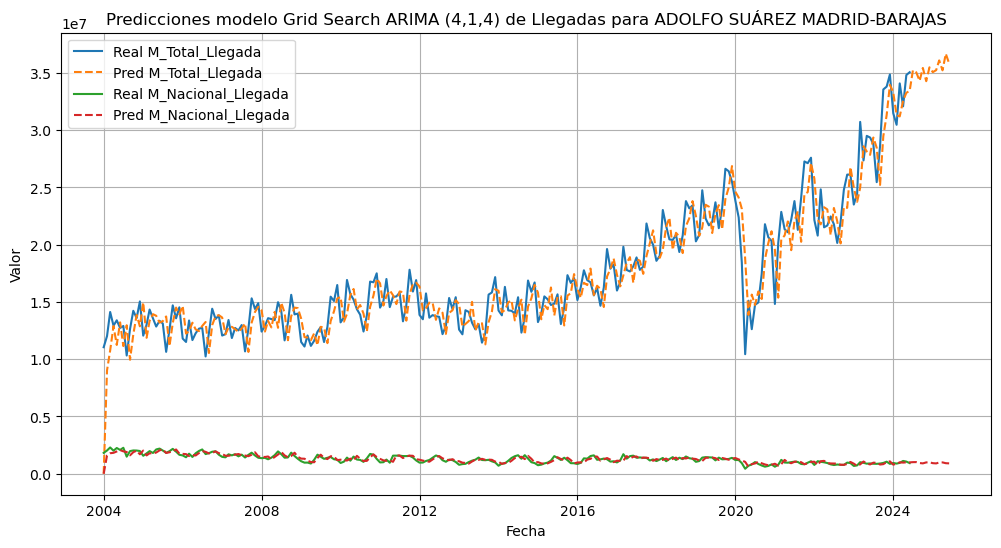

In [26]:
# Se visualizan las predicciones para un aeropuerto específico
Aeropuerto_Prediccion = 'ADOLFO SUÁREZ MADRID-BARAJAS'

# Se filtran los tipos de operación disponibles para el aeropuerto seleccionado
Tipos_Mercancias = Mercancias_Unico[Mercancias_Unico['Aeropuerto_Base'] == Aeropuerto_Prediccion]['Tipo'].unique()

# Se filtran los tipos de operación para Llegada
Tipos_Llegada = [tipo for tipo in Tipos_Mercancias if 'Llegada' in tipo]


# Gráfico para operaciones de Llegada
plt.figure(figsize=(12, 6))
for Tipo_Mercancias_Prediccion in Tipos_Llegada:
    # Se filtran los datos reales para el tipo de operación
    Datos_Reales_Mercancias_GS2 = Mercancias_Unico[(Mercancias_Unico['Aeropuerto_Base'] == Aeropuerto_Prediccion) & 
                                               (Mercancias_Unico['Tipo'] == Tipo_Mercancias_Prediccion)]
    
    # Se filtran las predicciones para el tipo de operación
    Datos_Predicciones_Mercancias_GS2 = Predicciones_Mercancias_GS2[(Predicciones_Mercancias_GS2['Aeropuerto_Base'] == Aeropuerto_Prediccion) & 
                                                            (Predicciones_Mercancias_GS2['Tipo'] == Tipo_Mercancias_Prediccion)]
    
    # Se añaden las series reales y predicciones al gráfico
    plt.plot(Datos_Reales_Mercancias_GS2.index, Datos_Reales_Mercancias_GS2['Valor'], label=f'Real {Tipo_Mercancias_Prediccion}')
    plt.plot(Datos_Predicciones_Mercancias_GS2['Fecha'], Datos_Predicciones_Mercancias_GS2['Prediccion'], linestyle='--', label=f'Pred {Tipo_Mercancias_Prediccion}')

# Se configura el gráfico
plt.title(f'Predicciones modelo Grid Search ARIMA (4,1,4) de Llegadas para {Aeropuerto_Prediccion}')
plt.xlabel('Fecha')
plt.ylabel('Valor')
plt.legend()
plt.grid(True)
plt.show()

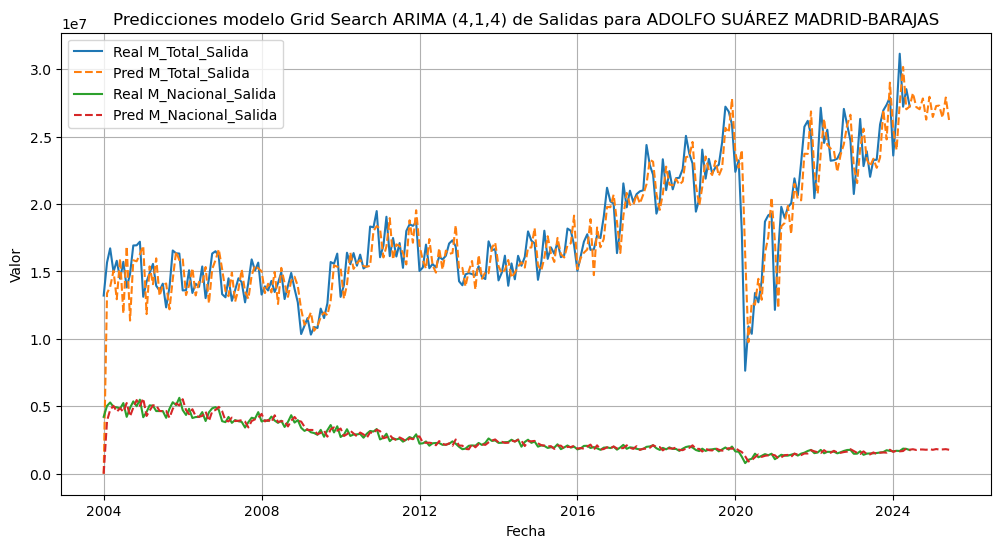

In [27]:
# Se visualizan las predicciones para un aeropuerto específico
Aeropuerto_Prediccion = 'ADOLFO SUÁREZ MADRID-BARAJAS'

# Se filtran los tipos de operación disponibles para el aeropuerto seleccionado
Tipos_Mercancias = Mercancias_Unico[Mercancias_Unico['Aeropuerto_Base'] == Aeropuerto_Prediccion]['Tipo'].unique()

# Se filtran los tipos de operación para Salida
Tipos_Salida = [tipo for tipo in Tipos_Mercancias if 'Salida' in tipo]


# Gráfico para operaciones de Salida
plt.figure(figsize=(12, 6))
for Tipo_Mercancias_Prediccion in Tipos_Salida:
    # Se filtran los datos reales para el tipo de operación
    Datos_Reales_Mercancias_GS2 = Mercancias_Unico[(Mercancias_Unico['Aeropuerto_Base'] == Aeropuerto_Prediccion) & 
                                               (Mercancias_Unico['Tipo'] == Tipo_Mercancias_Prediccion)]
    
    # Se filtran las predicciones para el tipo de operación
    Datos_Predicciones_Mercancias_GS2 = Predicciones_Mercancias_GS2[(Predicciones_Mercancias_GS2['Aeropuerto_Base'] == Aeropuerto_Prediccion) & 
                                                            (Predicciones_Mercancias_GS2['Tipo'] == Tipo_Mercancias_Prediccion)]
    
    # Se añaden las series reales y predicciones al gráfico
    plt.plot(Datos_Reales_Mercancias_GS2.index, Datos_Reales_Mercancias_GS2['Valor'], label=f'Real {Tipo_Mercancias_Prediccion}')
    plt.plot(Datos_Predicciones_Mercancias_GS2['Fecha'], Datos_Predicciones_Mercancias_GS2['Prediccion'], linestyle='--', label=f'Pred {Tipo_Mercancias_Prediccion}')

# Se configura el gráfico
plt.title(f'Predicciones modelo Grid Search ARIMA (4,1,4) de Salidas para {Aeropuerto_Prediccion}')
plt.xlabel('Fecha')
plt.ylabel('Valor')
plt.legend()
plt.grid(True)
plt.show()

**3-d. Métricas de error**

In [28]:
# Función para calcular SMAPE
def smape(y_true_GS2, y_pred_GS2):
    return 100 / len(y_true_GS2) * np.sum(2 * np.abs(y_pred_GS2 - y_true_GS2) / (np.abs(y_true_GS2) + np.abs(y_pred_GS2)))

# Se añade la métrica SMAPE
Metricas_Error_Mercancias_GS2 = pd.DataFrame(columns=['Aeropuerto_Base', 'Tipo', 'MAE', 'RMSE', 'MAPE', 'SMAPE'])

for (Aeropuerto, Mercancia), (Predicciones_Originales_GS2, _, Fechas_Reales) in Dicc_Predicciones_Mercancias_GS2.items():
    # Se obtienen los valores reales
    Valores_Reales_Mercancias_GS2 = Mercancias_Unico[(Mercancias_Unico['Aeropuerto_Base'] == Aeropuerto) & 
                                       (Mercancias_Unico['Tipo'] == Mercancia)]['Valor']
    
    # Se calculan las métricas de error si hay valores reales para comparar
    if len(Valores_Reales_Mercancias_GS2) == len(Predicciones_Originales_GS2):
        # MAE - Error Absoluto Medio
        mae = mean_absolute_error(Valores_Reales_Mercancias_GS2, Predicciones_Originales_GS2)
        # RMSE - Error Cuatrático Medio
        rmse = np.sqrt(mean_squared_error(Valores_Reales_Mercancias_GS2, Predicciones_Originales_GS2))
        # MAPE - Error Porcentual Absoluto Medio
        mape = np.mean(np.abs((Valores_Reales_Mercancias_GS2 - Predicciones_Originales_GS2) / np.where(Valores_Reales_Mercancias_GS2 == 0, 1, Valores_Reales_Mercancias_GS2))) * 100
        # SMAPE
        smape_value = smape(Valores_Reales_Mercancias_GS2, Predicciones_Originales_GS2)
        
        Temp_Metricas_Error_GS2 = pd.DataFrame({
            'Aeropuerto_Base': [Aeropuerto],
            'Tipo': [Mercancia],
            'MAE': [mae],
            'RMSE': [rmse],
            'MAPE': [mape],
            'SMAPE': [smape_value]
        })
        # Se concatenan las métricas de error
        Metricas_Error_Mercancias_GS2 = pd.concat([Metricas_Error_Mercancias_GS2, Temp_Metricas_Error_GS2], ignore_index=True)
    else:
        print(f"Las longitudes no coinciden para {Aeropuerto} - {Mercancia}")

# Se muestran las métricas
print(Metricas_Error_Mercancias_GS2)

                  Aeropuerto_Base                Tipo           MAE  \
0                        A CORUÑA     M_Total_Llegada  1.972981e+03   
1                        A CORUÑA  M_Nacional_Llegada  1.632108e+03   
2                        A CORUÑA      M_Total_Salida  2.599353e+03   
3                        A CORUÑA   M_Nacional_Salida  2.604427e+03   
4    ADOLFO SUÁREZ MADRID-BARAJAS     M_Total_Llegada  1.436049e+06   
..                            ...                 ...           ...   
191                     SON BONET   M_Nacional_Salida  4.307985e-02   
192              MURCIA COMBINADO     M_Total_Llegada  2.153297e+02   
193              MURCIA COMBINADO  M_Nacional_Llegada  2.559093e+01   
194              MURCIA COMBINADO      M_Total_Salida  9.689726e+01   
195              MURCIA COMBINADO   M_Nacional_Salida  9.839922e+01   

             RMSE         MAPE       SMAPE  
0    3.193760e+03  2170.060589   36.596553  
1    2.444539e+03  3094.351991   34.339368  
2    3.80357

**3-e. Métricas de error promedias de todo el conjunto**

In [29]:
# Se calculan las métricas medias para este modelo 
MAE_promedio_GS2 = Metricas_Error_Mercancias_GS2['MAE'].mean()
RMSE_promedio_GS2 = Metricas_Error_Mercancias_GS2['RMSE'].mean()
MAPE_promedio_GS2 = Metricas_Error_Mercancias_GS2['MAPE'].mean()
SMAPE_promedio_GS2 = Metricas_Error_Mercancias_GS2['SMAPE'].mean()


# Se muestran los resultados GRID SEARCH ARIMA (4,1,4)
print(f"MAE Promedio GRID SEARCH ARIMA (4,1,4): {MAE_promedio_GS2}")
print(f"RMSE Promedio GRID SEARCH ARIMA (4,1,4): {RMSE_promedio_GS2}")
print(f"MAPE Promedio GRID SEARCH ARIMA (4,1,4): {MAPE_promedio_GS2}%")
print(f"SMAPE Promedio GRID SEARCH ARIMA (4,1,4): {SMAPE_promedio_GS2}%")

MAE Promedio GRID SEARCH ARIMA (4,1,4): 39050.927808306435
RMSE Promedio GRID SEARCH ARIMA (4,1,4): 57790.63168994232
MAPE Promedio GRID SEARCH ARIMA (4,1,4): 10070.905725509423%
SMAPE Promedio GRID SEARCH ARIMA (4,1,4): 70.0388503930309%


- MAE Promedio GRID SEARCH ARIMA (3,0,3): 41960.5465276874
- RMSE Promedio GRID SEARCH ARIMA (3,0,3): 62366.11280555675
- MAPE Promedio GRID SEARCH ARIMA (3,0,3): 7147.310148626099%
- SMAPE Promedio GRID SEARCH ARIMA (3,0,3): 72.25989791629569%
  
Si se observan los valores promedios del modelos GRID SEARCH ARIMA (3,0,3) comparado con los modelos anteriores, tanto el MAE como el RSM  han disminuido, por lo que la precisión y la predicción mejoran con respecto a los anteriores.
Para los aeropuertos que tiene datos la precisión mejora, pero para los que son 0, pues empeora.

**4. Modelo Random Search - ARIMA**

Se prueba otro modelo de búsqueda de los mejores parámetros esta vez, de manera aleatoria, sin comprobar todas las combinaciones posibles,Random Search, y, además como el ampliar el rango, en el modelo anterior funcionó, en este caso también se vuelve a ampliar hasta 7.

In [33]:
# Se definen los rangos de p, d, q
p = d = q = range(0, 7) 
# Se crean las combinaciones posibles de p, d, q
pdq = list(itertools.product(p, d, q))

# Se define el número de combinaciones
N_Iteraciones = 11  #

# Se selecciona el número de combinaciones e iteracciones aleatoriamente
Combinaciones_Aleatorias_RS = random.sample(pdq, N_Iteraciones)

In [34]:
# Se almcenan los mejores resultados
Mejor_aic = float('inf')
Mejor_params = None

# Se itera sobre cada combinación de parámetros
for params in Combinaciones_Aleatorias_RS:
    try:
        # Se entrena el modelo ARIMA con los parámetros actuales
        model_arima_RS = ARIMA(Datos_Reales_Mercancias['Valor'], order=params)
        model_fit_arima_RS = model_arima_RS.fit()
        
        # Se calcula el AIC
        aic = model_fit_arima_RS.aic
        
        # Si el AIC actual es mejor que el anterior, actualizar los mejores parámetros
        if aic < Mejor_aic:
            Mejor_aic = aic
            Mejor_params = params
            
    except Exception as e:
        print(f"Error con los parámetros {params}: {e}")
        continue

print(f'Mejor conjunto de parámetros: {Mejor_params} con AIC: {Mejor_aic}')

Mejor conjunto de parámetros: (1, 0, 5) con AIC: 6838.213356242779


**4-a. Se reentrena el modelo con los parámetros obtenidos, Modelo Random Search - ARIMA**

Se reentrena el modelo con el conjunto de parámetros que el modelo ha evaluado como más óptimos (1,0,5)

In [35]:
# Se crea un diccionario para almacenar las predicciones
Dicc_Predicciones_Mercancias_RS = {}

# Se obtienen todos los aeropurtos y tipos únicos
Aeropuertos = Mercancias_Unico['Aeropuerto_Base'].unique()
Tipos_Mercancias= Mercancias_Unico['Tipo'].unique()

# Se itera sobre cada aeropuerto y tipo
for Aeropuerto in Aeropuertos:
    for Mercancia in Tipos_Mercancias:
        # Se filtra cada aeropuerto y tipo de operación para los datos originales "reales"
        Datos_Reales_Mercancias_RS = Mercancias_Unico[(Mercancias_Unico['Aeropuerto_Base'] == Aeropuerto) & 
                                                   (Mercancias_Unico['Tipo'] == Mercancia)]
        
        # Se comprueba que está ordenado cronologicamente
        Datos_Reales_Mercancias_RS = Datos_Reales_Mercancias_RS.sort_index()

        # Se entrena el modelo ARIMA en los datos históricos
        try:
            model_arima_RS = ARIMA(Datos_Reales_Mercancias_RS['Valor'], order=(1, 0, 5))
            model_fit_arima_RS = model_arima_RS.fit()

            # Se realizan predicciones hasta los valores que ya se tienen, junio 2024 
            Predicciones_Originales_RS = model_fit_arima_RS.predict(start=Datos_Reales_Mercancias_RS.index[0], end=Datos_Reales_Mercancias_RS.index[-1])

           # Se realizan predicciones para fechas de las que no se tiene valores que ya se tienen, a partir de junio 2024 
            Predicciones_Futuras_RS = model_fit_arima_RS.forecast(steps=12)

            # Se almacenan las predicciones en el diccionario
            Dicc_Predicciones_Mercancias_RS[(Aeropuerto, Mercancia)] = (Predicciones_Originales_RS, Predicciones_Futuras_RS, Datos_Reales_Mercancias_RS.index)
        
        except Exception as e:
            print(f"Error al entrenar el modelo para {Aeropuerto}, {Mercancia}: {e}")

**4-b. Dataframe en el que se guardan las predicciones y los datos reales**

In [36]:
# Se crea un dataframe para poder comparar las predicciones
Comparacion_Total_Todos_Aeropuertos_RS_M = pd.DataFrame(columns=['Aeropuerto_Base', 'Tipo', 'Fecha', 'Valor Real', 'Prediccion'])

for (Aeropuerto, Mercancia), (Predicciones_Originales_RS, Predicciones_Futuras_RS, Fechas_Reales) in Dicc_Predicciones_Mercancias_RS.items():
    # Se crea un DataFrame temporal para las predicciones históricas con los valores originales
    Tem_Predicciones_Historicas_RS = pd.DataFrame({
        'Aeropuerto_Base': Aeropuerto,
        'Tipo': Mercancia,
        'Fecha': Fechas_Reales,
        'Valor Real': Mercancias_Unico[(Mercancias_Unico['Aeropuerto_Base'] == Aeropuerto) & 
                                        (Mercancias_Unico['Tipo'] == Mercancia)]['Valor'],
        'Prediccion': Predicciones_Originales_RS
    })

    # Se crea un DataFrame para las predicciones futuras
    Fechas_Futuras = pd.date_range(start=Fechas_Reales[-1] + pd.offsets.MonthBegin(1), periods=len(Predicciones_Futuras_RS), freq='MS')
    Temp_Predicciones_Futuras_RS = pd.DataFrame({
        'Aeropuerto_Base': Aeropuerto,
        'Tipo': Mercancia,
        'Fecha': Fechas_Futuras,
        'Valor Real': [None] * len(Predicciones_Futuras_RS),
        'Prediccion': Predicciones_Futuras_RS
    })

    # Se concatena los dos dataframe (históricos y futuros)
    Comparacion_Total_Todos_Aeropuertos_RS_M = pd.concat([Comparacion_Total_Todos_Aeropuertos_RS_M, Tem_Predicciones_Historicas_RS, Temp_Predicciones_Futuras_RS], ignore_index=True)

# Se muestran las últimas filas para ver los valores reales y predicciones
print(Comparacion_Total_Todos_Aeropuertos_RS_M.tail(20))

        Aeropuerto_Base               Tipo      Fecha Valor Real  Prediccion
50548  MURCIA COMBINADO  M_Nacional_Salida 2023-11-01          0    3.241740
50549  MURCIA COMBINADO  M_Nacional_Salida 2023-12-01          0    3.241740
50550  MURCIA COMBINADO  M_Nacional_Salida 2024-01-01          0    3.241740
50551  MURCIA COMBINADO  M_Nacional_Salida 2024-02-01          0    3.241740
50552  MURCIA COMBINADO  M_Nacional_Salida 2024-03-01          0    3.241740
50553  MURCIA COMBINADO  M_Nacional_Salida 2024-04-01          0    3.241740
50554  MURCIA COMBINADO  M_Nacional_Salida 2024-05-01          0    3.241740
50555  MURCIA COMBINADO  M_Nacional_Salida 2024-06-01          0    3.241740
50556  MURCIA COMBINADO  M_Nacional_Salida 2024-07-01       None    3.241740
50557  MURCIA COMBINADO  M_Nacional_Salida 2024-08-01       None    4.487556
50558  MURCIA COMBINADO  M_Nacional_Salida 2024-09-01       None    5.443945
50559  MURCIA COMBINADO  M_Nacional_Salida 2024-10-01       None    6.111532

In [37]:
# Se convierten los valores a flotantes si no son nulos y no son cadenas vacías
Comparacion_Total_Todos_Aeropuertos_RS_M['Valor Real'] = Comparacion_Total_Todos_Aeropuertos_RS_M['Valor Real'].apply(lambda x: float(x) if pd.notnull(x) and x != '' else x)
Comparacion_Total_Todos_Aeropuertos_RS_M['Prediccion'] = Comparacion_Total_Todos_Aeropuertos_RS_M['Prediccion'].apply(lambda x: float(x) if pd.notnull(x) and x != '' else x)

# Se reemplazan los puntos por comas en las columnas de interés ('Valor Real' y 'Prediccion')
Comparacion_Total_Todos_Aeropuertos_RS_M['Valor Real'] = Comparacion_Total_Todos_Aeropuertos_RS_M['Valor Real'].apply(lambda x: f"{x:.2f}".replace('.', ',') if pd.notnull(x) else '')
Comparacion_Total_Todos_Aeropuertos_RS_M['Prediccion'] = Comparacion_Total_Todos_Aeropuertos_RS_M['Prediccion'].apply(lambda x: f"{x:.2f}".replace('.', ',') if pd.notnull(x) else '')

# Se muestran las últimas filas para verificar los cambios
print(Comparacion_Total_Todos_Aeropuertos_RS_M.tail(20))

        Aeropuerto_Base               Tipo      Fecha Valor Real Prediccion
50548  MURCIA COMBINADO  M_Nacional_Salida 2023-11-01       0,00       3,24
50549  MURCIA COMBINADO  M_Nacional_Salida 2023-12-01       0,00       3,24
50550  MURCIA COMBINADO  M_Nacional_Salida 2024-01-01       0,00       3,24
50551  MURCIA COMBINADO  M_Nacional_Salida 2024-02-01       0,00       3,24
50552  MURCIA COMBINADO  M_Nacional_Salida 2024-03-01       0,00       3,24
50553  MURCIA COMBINADO  M_Nacional_Salida 2024-04-01       0,00       3,24
50554  MURCIA COMBINADO  M_Nacional_Salida 2024-05-01       0,00       3,24
50555  MURCIA COMBINADO  M_Nacional_Salida 2024-06-01       0,00       3,24
50556  MURCIA COMBINADO  M_Nacional_Salida 2024-07-01                  3,24
50557  MURCIA COMBINADO  M_Nacional_Salida 2024-08-01                  4,49
50558  MURCIA COMBINADO  M_Nacional_Salida 2024-09-01                  5,44
50559  MURCIA COMBINADO  M_Nacional_Salida 2024-10-01                  6,11
50560  MURCI

**4-c. Visualización de las predicciones**

In [38]:
# Se crea un DataFrame para almacenar todas las predicciones
Predicciones_Mercancias_RS = pd.DataFrame(columns=['Aeropuerto_Base', 'Tipo', 'Fecha', 'Prediccion'])

for (Aeropuerto, Mercancia), (Predicciones_Originales_RS, Predicciones_Futuras_RS, Fechas_Reales) in Dicc_Predicciones_Mercancias_RS.items():
    # Se guardan en un DataFrame temporal para las predicciones de los datos orginales "reales"
    Tem_Predicciones_Historicas_RS = pd.DataFrame({
        'Aeropuerto_Base': Aeropuerto,
        'Tipo': Mercancia,
        'Fecha': Fechas_Reales,
        'Prediccion': Predicciones_Originales_RS
    })

    # Se guardan en un DataFrame temporal para las predicciones de fechas futuras
    Fechas_Futuras = pd.date_range(start=Fechas_Reales[-1] + pd.offsets.MonthBegin(1), periods=len(Predicciones_Futuras_RS), freq='MS')
    Temp_Predicciones_Futuras_RS = pd.DataFrame({
        'Aeropuerto_Base': Aeropuerto,
        'Tipo': Mercancia,
        'Fecha': Fechas_Futuras,
        'Prediccion': Predicciones_Futuras_RS
    })

    # Se concatenan ambas predicciones y se guardan en un dataframe único
    Predicciones_Mercancias_RS = pd.concat([Predicciones_Mercancias_RS, Tem_Predicciones_Historicas_RS, Temp_Predicciones_Futuras_RS], ignore_index=True)

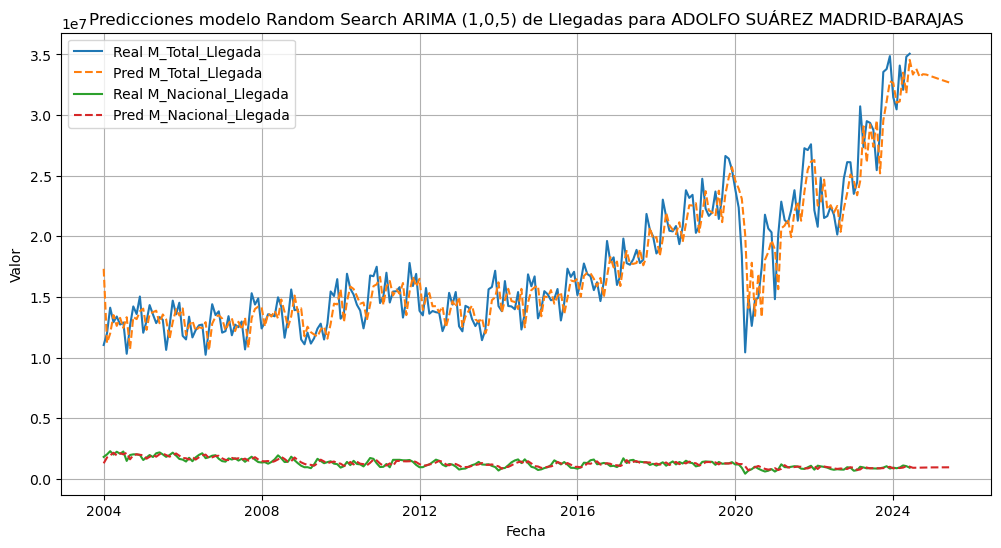

In [39]:
# Se visualizan las predicciones para un aeropuerto específico
Aeropuerto_Prediccion = 'ADOLFO SUÁREZ MADRID-BARAJAS'

# Se filtran los tipos de operación disponibles para el aeropuerto seleccionado
Tipos_Mercancias = Mercancias_Unico[Mercancias_Unico['Aeropuerto_Base'] == Aeropuerto_Prediccion]['Tipo'].unique()

# Se filtran los tipos de operación para Llegada
Tipos_Llegada = [tipo for tipo in Tipos_Mercancias if 'Llegada' in tipo]


# Gráfico para operaciones de Llegada
plt.figure(figsize=(12, 6))
for Tipo_Mercancias_Prediccion in Tipos_Llegada:
    # Se filtran los datos reales para el tipo de operación
    Datos_Reales_Mercancias_RS = Mercancias_Unico[(Mercancias_Unico['Aeropuerto_Base'] == Aeropuerto_Prediccion) & 
                                               (Mercancias_Unico['Tipo'] == Tipo_Mercancias_Prediccion)]
    
    # Se filtran las predicciones para el tipo de operación
    Datos_Predicciones_Mercancias_RS = Predicciones_Mercancias_RS[(Predicciones_Mercancias_RS['Aeropuerto_Base'] == Aeropuerto_Prediccion) & 
                                                            (Predicciones_Mercancias_RS['Tipo'] == Tipo_Mercancias_Prediccion)]
    
    # Se añaden las series reales y predicciones al gráfico
    plt.plot(Datos_Reales_Mercancias_RS.index, Datos_Reales_Mercancias_RS['Valor'], label=f'Real {Tipo_Mercancias_Prediccion}')
    plt.plot(Datos_Predicciones_Mercancias_RS['Fecha'], Datos_Predicciones_Mercancias_RS['Prediccion'], linestyle='--', label=f'Pred {Tipo_Mercancias_Prediccion}')

# Se configura el gráfico
plt.title(f'Predicciones modelo Random Search ARIMA (1,0,5) de Llegadas para {Aeropuerto_Prediccion}')
plt.xlabel('Fecha')
plt.ylabel('Valor')
plt.legend()
plt.grid(True)
plt.show()

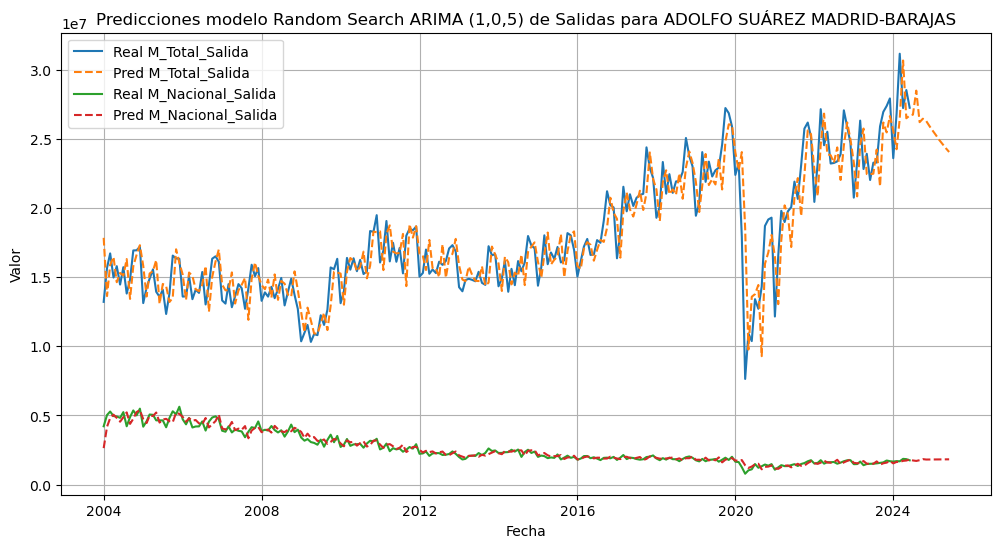

In [40]:
# Se visualizan las predicciones para un aeropuerto específico
Aeropuerto_Prediccion = 'ADOLFO SUÁREZ MADRID-BARAJAS'

# Se filtran los tipos de operación disponibles para el aeropuerto seleccionado
Tipos_Mercancias = Mercancias_Unico[Mercancias_Unico['Aeropuerto_Base'] == Aeropuerto_Prediccion]['Tipo'].unique()

# Se filtran los tipos de operación para Salida 
Tipos_Salida = [tipo for tipo in Tipos_Mercancias if 'Salida' in tipo]


# Gráfico para operaciones de Salida 
plt.figure(figsize=(12, 6))
for Tipo_Mercancias_Prediccion in Tipos_Salida :
    # Se filtran los datos reales para el tipo de operación
    Datos_Reales_Mercancias_RS = Mercancias_Unico[(Mercancias_Unico['Aeropuerto_Base'] == Aeropuerto_Prediccion) & 
                                               (Mercancias_Unico['Tipo'] == Tipo_Mercancias_Prediccion)]
    
    # Se filtran las predicciones para el tipo de operación
    Datos_Predicciones_Mercancias_RS = Predicciones_Mercancias_RS[(Predicciones_Mercancias_RS['Aeropuerto_Base'] == Aeropuerto_Prediccion) & 
                                                            (Predicciones_Mercancias_RS['Tipo'] == Tipo_Mercancias_Prediccion)]
    
    # Se añaden las series reales y predicciones al gráfico
    plt.plot(Datos_Reales_Mercancias_RS.index, Datos_Reales_Mercancias_RS['Valor'], label=f'Real {Tipo_Mercancias_Prediccion}')
    plt.plot(Datos_Predicciones_Mercancias_RS['Fecha'], Datos_Predicciones_Mercancias_RS['Prediccion'], linestyle='--', label=f'Pred {Tipo_Mercancias_Prediccion}')

# Se configura el gráfico
plt.title(f'Predicciones modelo Random Search ARIMA (1,0,5) de Salidas para {Aeropuerto_Prediccion}')
plt.xlabel('Fecha')
plt.ylabel('Valor')
plt.legend()
plt.grid(True)
plt.show()

**4-d. Métricas de error**

In [41]:
# Función para calcular SMAPE
def smape(y_true_RS, y_pred_RS):
    return 100 / len(y_true_RS) * np.sum(2 * np.abs(y_pred_RS - y_true_RS) / (np.abs(y_true_RS) + np.abs(y_pred_RS)))

# Se añade la métrica SMAPE
Metricas_Error_Mercancias_RS = pd.DataFrame(columns=['Aeropuerto_Base', 'Tipo', 'MAE', 'RMSE', 'MAPE', 'SMAPE'])

for (Aeropuerto, Mercancia), (Predicciones_Originales_RS, _, Fechas_Reales) in Dicc_Predicciones_Mercancias_RS.items():
    # Se obtienen los valores reales
    Valores_Reales_Mercancia_RS = Mercancias_Unico[(Mercancias_Unico['Aeropuerto_Base'] == Aeropuerto) & 
                                       (Mercancias_Unico['Tipo'] == Mercancia)]['Valor']
    
    # Se calculan las métricas de error si hay valores reales para comparar
    if len(Valores_Reales_Mercancia_RS) == len(Predicciones_Originales_RS):
        # MAE - Error Absoluto Medio
        mae = mean_absolute_error(Valores_Reales_Mercancia_RS, Predicciones_Originales_RS)
        # RMSE - Error Cuatrático Medio
        rmse = np.sqrt(mean_squared_error(Valores_Reales_Mercancia_RS, Predicciones_Originales_RS))
        # MAPE - Error Porcentual Absoluto Medio
        mape = np.mean(np.abs((Valores_Reales_Mercancia_RS - Predicciones_Originales_RS) / np.where(Valores_Reales_Mercancia_RS == 0, 1, Valores_Reales_Mercancia_RS))) * 100
        # SMAPE
        smape_value = smape(Valores_Reales_Mercancia_RS, Predicciones_Originales_RS)
        
        Temp_Metricas_Error_RS = pd.DataFrame({
            'Aeropuerto_Base': [Aeropuerto],
            'Tipo': [Mercancia],
            'MAE': [mae],
            'RMSE': [rmse],
            'MAPE': [mape],
            'SMAPE': [smape_value]
        })
        # Se concatenan las métricas de error
        Metricas_Error_Mercancias_RS = pd.concat([Metricas_Error_Mercancias_RS, Temp_Metricas_Error_RS], ignore_index=True)
    else:
        print(f"Las longitudes no coinciden para {Aeropuerto} - {Mercancia}")

# Se muestran las métricas
print(Metricas_Error_Mercancias_RS)

                  Aeropuerto_Base                Tipo           MAE  \
0                        A CORUÑA     M_Total_Llegada  1.884699e+03   
1                        A CORUÑA  M_Nacional_Llegada  1.608860e+03   
2                        A CORUÑA      M_Total_Salida  2.502556e+03   
3                        A CORUÑA   M_Nacional_Salida  2.485595e+03   
4    ADOLFO SUÁREZ MADRID-BARAJAS     M_Total_Llegada  1.423114e+06   
..                            ...                 ...           ...   
191                     SON BONET   M_Nacional_Salida  6.480980e-02   
192              MURCIA COMBINADO     M_Total_Llegada  1.269106e+02   
193              MURCIA COMBINADO  M_Nacional_Llegada  2.505056e+01   
194              MURCIA COMBINADO      M_Total_Salida  1.052509e+02   
195              MURCIA COMBINADO   M_Nacional_Salida  8.187751e+01   

             RMSE         MAPE       SMAPE  
0    3.085036e+03  2397.286676   35.441161  
1    2.304112e+03  3309.876996   33.782510  
2    3.56639

**4-d. Métricas de error promedias de todo el conjunto**

In [42]:
# Se calculan las métricas medias para este modelo 
MAE_promedio_RS = Metricas_Error_Mercancias_RS['MAE'].mean()
RMSE_promedio_RS = Metricas_Error_Mercancias_RS['RMSE'].mean()
MAPE_promedio_RS = Metricas_Error_Mercancias_RS['MAPE'].mean()
SMAPE_promedio_RS = Metricas_Error_Mercancias_RS['SMAPE'].mean()

# Se muestran los resultados RANDOM SEARCH ARIMA (1,0,5)
print(f"MAE Promedio RANDOM SEARCH ARIMA (1,0,5): {MAE_promedio_RS}")
print(f"RMSE Promedio RANDOM SEARCH ARIMA ((1,0,5): {RMSE_promedio_RS}")
print(f"MAPE Promedio RANDOM SEARCH ARIMA (1,0,5): {MAPE_promedio_RS}%")
print(f"SMAPE Promedio RANDOM SEARCH ARIMA (1,0,5): {SMAPE_promedio_RS}%")

MAE Promedio RANDOM SEARCH ARIMA (1,0,5): 39365.155106976556
RMSE Promedio RANDOM SEARCH ARIMA ((1,0,5): 55897.139021715455
MAPE Promedio RANDOM SEARCH ARIMA (1,0,5): 9833.999796236443%
SMAPE Promedio RANDOM SEARCH ARIMA (1,0,5): 97.7730725890445%


Este modelo no ha mejorado en medias con respecto al modelo anterior GRID SEARCH ARIMA (4,0,4) como se puede comprobar con los datos obtenidos de las métricas de errores.

- MAE Promedio GRID SEARCH ARIMA (4,1,4): 39050.927808306435
- RMSE Promedio GRID SEARCH ARIMA (4,1,4): 57790.63168994232
- MAPE Promedio GRID SEARCH ARIMA (4,1,4): 10070.905725509423%
- SMAPE Promedio GRID SEARCH ARIMA (4,1,4): 70.0388503930309%

**5. Modelo Exponencial Holt-Winters - aditivo**

Dado que las series presentan cierta estacionalidad se prueba con este tipo de modelo, para ver si mejoran las predicciones

In [43]:
# Se crea un diccionario para almacenar las predicciones
Dicc_Predicciones_HoltWinters_AD_M = {}

# Se obtienen todos los aeropuertos y tipos únicos
Aeropuertos = Mercancias_Unico['Aeropuerto_Base'].unique()
Tipos_Mercancias = Mercancias_Unico['Tipo'].unique()

# Se itera sobre cada aeropuerto y tipo
for Aeropuerto in Aeropuertos:
    for Mercancia in Tipos_Mercancias:
        # Se filtra cada aeropuerto y tipo de operación
        Datos_Reales_Mercancia_HW_AD = Mercancias_Unico[(Mercancias_Unico['Aeropuerto_Base'] == Aeropuerto) & 
                                                      (Mercancias_Unico['Tipo'] == Mercancia)]
        
        # Se comprueba que está ordenado cronológicamente
        Datos_Reales_Mercancia_HW_AD = Datos_Reales_Mercancia_HW_AD.sort_index()

        # Se entrena el modelo Holt-Winters en los datos históricos
        try:
            model_hw_AD = ExponentialSmoothing(Datos_Reales_Mercancia_HW_AD['Valor'], 
                                            trend='add', 
                                            seasonal='add', 
                                            seasonal_periods=12)
            model_fit_hw_AD = model_hw_AD.fit()

            # Se realizan predicciones para los valores históricos
            Predicciones_Originales_HWA = model_fit_hw_AD.predict(start=Datos_Reales_Mercancia_HW_AD.index[0], end=Datos_Reales_Mercancia_HW_AD.index[-1])

            # Se realizan predicciones para fechas futuras, el siguiente año completo, 12 meses
            Predicciones_Futuras_HWA = model_fit_hw_AD.forecast(steps=12)

             # Se almacenan las predicciones en el diccionario
            Dicc_Predicciones_HoltWinters_AD_M[(Aeropuerto, Mercancia)] = (Predicciones_Originales_HWA, Predicciones_Futuras_HWA, Datos_Reales_Mercancia_HW_AD.index)
        
        except Exception as e:
            print(f"Error al entrenar el modelo Holt-Winters ADitivo para {Aeropuerto}, {Mercancia}: {e}")

**5-a. Dataframe en el que se guardan las predicciones y los datos reales**

In [44]:
# Se crea un dataframe para poder comparar las predicciones
Comparacion_Total_Todos_Aeropuertos_HWA_M = pd.DataFrame(columns=['Aeropuerto_Base', 'Tipo', 'Fecha', 'Valor Real', 'Prediccion'])

for (Aeropuerto, Mercancia), (Predicciones_Originales_HWA, Predicciones_Futuras_HWA, Fechas_Reales) in Dicc_Predicciones_HoltWinters_AD_M.items():
    # Se crea un DataFrame temporal para las predicciones históricas con los valores originales
    Tem_Predicciones_Historicas_HWA = pd.DataFrame({
        'Aeropuerto_Base': Aeropuerto,
        'Tipo': Mercancia,
        'Fecha': Fechas_Reales,
        'Valor Real': Mercancias_Unico[(Mercancias_Unico['Aeropuerto_Base'] == Aeropuerto) & 
                                        (Mercancias_Unico['Tipo'] == Mercancia)]['Valor'],
        'Prediccion': Predicciones_Originales_HWA
    })

    # Se crea un DataFrame para las predicciones futuras
    Fechas_Futuras = pd.date_range(start=Fechas_Reales[-1] + pd.offsets.MonthBegin(1), periods=len(Predicciones_Futuras_HWA), freq='MS')
    Temp_Predicciones_Futuras_HWA = pd.DataFrame({
        'Aeropuerto_Base': Aeropuerto,
        'Tipo': Mercancia,
        'Fecha': Fechas_Futuras,
        'Valor Real': [None] * len(Predicciones_Futuras_HWA),
        'Prediccion': Predicciones_Futuras_HWA
    })

    # Se concatena los dos dataframe (históricos y futuros)
    Comparacion_Total_Todos_Aeropuertos_HWA_M = pd.concat([Comparacion_Total_Todos_Aeropuertos_HWA_M, Tem_Predicciones_Historicas_HWA, Temp_Predicciones_Futuras_HWA], ignore_index=True)

# Se muestran las últimas filas para ver los valores reales y predicciones
print(Comparacion_Total_Todos_Aeropuertos_HWA_M.tail(20))

        Aeropuerto_Base               Tipo      Fecha Valor Real  Prediccion
50548  MURCIA COMBINADO  M_Nacional_Salida 2023-11-01          0    8.743273
50549  MURCIA COMBINADO  M_Nacional_Salida 2023-12-01          0  -26.965743
50550  MURCIA COMBINADO  M_Nacional_Salida 2024-01-01          0  -26.906311
50551  MURCIA COMBINADO  M_Nacional_Salida 2024-02-01          0   -2.295978
50552  MURCIA COMBINADO  M_Nacional_Salida 2024-03-01          0  -11.971031
50553  MURCIA COMBINADO  M_Nacional_Salida 2024-04-01          0   17.043923
50554  MURCIA COMBINADO  M_Nacional_Salida 2024-05-01          0    1.806588
50555  MURCIA COMBINADO  M_Nacional_Salida 2024-06-01          0   12.182493
50556  MURCIA COMBINADO  M_Nacional_Salida 2024-07-01       None   37.766006
50557  MURCIA COMBINADO  M_Nacional_Salida 2024-08-01       None   -9.734535
50558  MURCIA COMBINADO  M_Nacional_Salida 2024-09-01       None   12.556327
50559  MURCIA COMBINADO  M_Nacional_Salida 2024-10-01       None   10.562205

In [45]:
# Se convierten los valores a flotantes si no son nulos y no son cadenas vacías
Comparacion_Total_Todos_Aeropuertos_HWA_M['Valor Real'] = Comparacion_Total_Todos_Aeropuertos_HWA_M['Valor Real'].apply(lambda x: float(x) if pd.notnull(x) and x != '' else x)
Comparacion_Total_Todos_Aeropuertos_HWA_M['Prediccion'] = Comparacion_Total_Todos_Aeropuertos_HWA_M['Prediccion'].apply(lambda x: float(x) if pd.notnull(x) and x != '' else x)

# Se reemplazan los puntos por comas en las columnas de interés ('Valor Real' y 'Prediccion')
Comparacion_Total_Todos_Aeropuertos_HWA_M['Valor Real'] = Comparacion_Total_Todos_Aeropuertos_HWA_M['Valor Real'].apply(lambda x: f"{x:.2f}".replace('.', ',') if pd.notnull(x) else '')
Comparacion_Total_Todos_Aeropuertos_HWA_M['Prediccion'] = Comparacion_Total_Todos_Aeropuertos_HWA_M['Prediccion'].apply(lambda x: f"{x:.2f}".replace('.', ',') if pd.notnull(x) else '')

# Se muestran las últimas filas para verificar los cambios
print(Comparacion_Total_Todos_Aeropuertos_HWA_M.tail(20))

        Aeropuerto_Base               Tipo      Fecha Valor Real Prediccion
50548  MURCIA COMBINADO  M_Nacional_Salida 2023-11-01       0,00       8,74
50549  MURCIA COMBINADO  M_Nacional_Salida 2023-12-01       0,00     -26,97
50550  MURCIA COMBINADO  M_Nacional_Salida 2024-01-01       0,00     -26,91
50551  MURCIA COMBINADO  M_Nacional_Salida 2024-02-01       0,00      -2,30
50552  MURCIA COMBINADO  M_Nacional_Salida 2024-03-01       0,00     -11,97
50553  MURCIA COMBINADO  M_Nacional_Salida 2024-04-01       0,00      17,04
50554  MURCIA COMBINADO  M_Nacional_Salida 2024-05-01       0,00       1,81
50555  MURCIA COMBINADO  M_Nacional_Salida 2024-06-01       0,00      12,18
50556  MURCIA COMBINADO  M_Nacional_Salida 2024-07-01                 37,77
50557  MURCIA COMBINADO  M_Nacional_Salida 2024-08-01                 -9,73
50558  MURCIA COMBINADO  M_Nacional_Salida 2024-09-01                 12,56
50559  MURCIA COMBINADO  M_Nacional_Salida 2024-10-01                 10,56
50560  MURCI

**5.b - Visualización predicciones**

In [ ]:
# Se crea un DataFrame para almacenar todas las predicciones
Predicciones_Mercancias_HWA = pd.DataFrame(columns=['Aeropuerto_Base', 'Tipo', 'Fecha', 'Prediccion'])

for (Aeropuerto, Mercancia), (Predicciones_Originales_HWA, Predicciones_Futuras_HWA, Fechas_Reales) in Dicc_Predicciones_HoltWinters_AD_M.items():
    # Se guardan en un DataFrame temporal para las predicciones de los datos orginales "reales"
    Tem_Predicciones_Historicas_HWA = pd.DataFrame({
        'Aeropuerto_Base': Aeropuerto,
        'Tipo': Mercancia,
        'Fecha': Fechas_Reales,
        'Prediccion': Predicciones_Originales_HWA
    })

    # Se guardan en un DataFrame temporal para las predicciones de fechas futuras
    Fechas_Futuras = pd.date_range(start=Fechas_Reales[-1] + pd.offsets.MonthBegin(1), periods=len(Predicciones_Futuras_HWA), freq='MS')
    Temp_Predicciones_Futuras_HWA = pd.DataFrame({
        'Aeropuerto_Base': Aeropuerto,
        'Tipo': Mercancia,
        'Fecha': Fechas_Futuras,
        'Prediccion': Predicciones_Futuras_HWA
    })

    # Se concatenan ambas predicciones y se guardan en un dataframe único
    Predicciones_Mercancias_HWA = pd.concat([Predicciones_Mercancias_HWA, Tem_Predicciones_Historicas_HWA, Temp_Predicciones_Futuras_HWA], ignore_index=True)

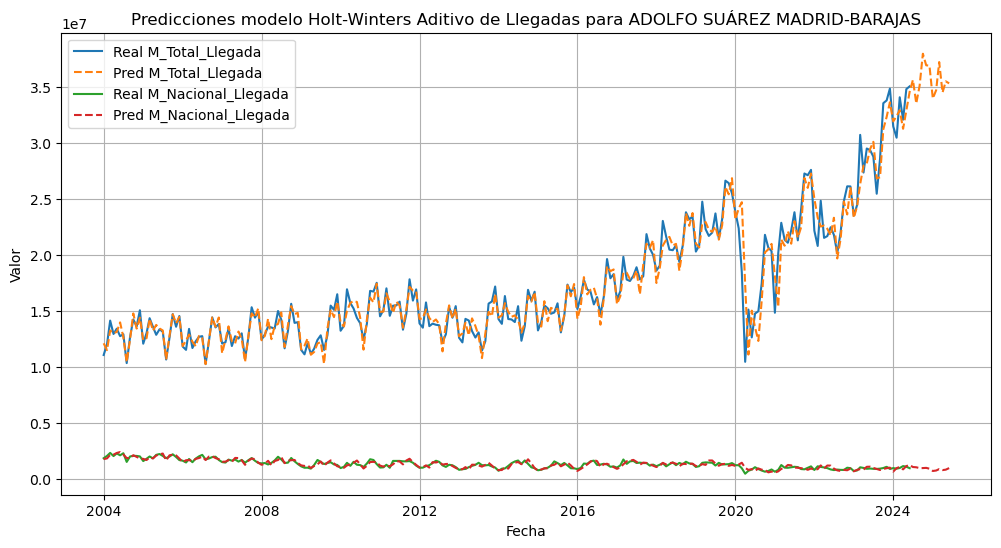

In [64]:
# Se visualizan las predicciones para un aeropuerto específico
Aeropuerto_Prediccion = 'ADOLFO SUÁREZ MADRID-BARAJAS'

# Se filtran los tipos de operación disponibles para el aeropuerto seleccionado
Tipos_Mercancias = Mercancias_Unico[Mercancias_Unico['Aeropuerto_Base'] == Aeropuerto_Prediccion]['Tipo'].unique()

# Se filtran los tipos de operación para Llegada
Tipos_Llegada = [tipo for tipo in Tipos_Mercancias if 'Llegada' in tipo]


# Gráfico para operaciones de Llegada
plt.figure(figsize=(12, 6))
for Tipo_Mercancias_Prediccion in Tipos_Llegada:
    # Se filtran los datos reales para el tipo de operación
    Datos_Reales_Mercancias_HWA = Mercancias_Unico[(Mercancias_Unico['Aeropuerto_Base'] == Aeropuerto_Prediccion) & 
                                               (Mercancias_Unico['Tipo'] == Tipo_Mercancias_Prediccion)]
    
    # Se filtran las predicciones para el tipo de operación
    Datos_Predicciones_Mercancias_HWA = Predicciones_Mercancias_HWA[(Predicciones_Mercancias_HWA['Aeropuerto_Base'] == Aeropuerto_Prediccion) & 
                                                            (Predicciones_Mercancias_HWA['Tipo'] == Tipo_Mercancias_Prediccion)]
    
    # Se añaden las series reales y predicciones al gráfico
    plt.plot(Datos_Reales_Mercancias_HWA.index, Datos_Reales_Mercancias_HWA['Valor'], label=f'Real {Tipo_Mercancias_Prediccion}')
    plt.plot(Datos_Predicciones_Mercancias_HWA['Fecha'], Datos_Predicciones_Mercancias_HWA['Prediccion'], linestyle='--', label=f'Pred {Tipo_Mercancias_Prediccion}')

# Se configura el gráfico
plt.title(f'Predicciones modelo Holt-Winters Aditivo de Llegadas para {Aeropuerto_Prediccion}')
plt.xlabel('Fecha')
plt.ylabel('Valor')
plt.legend()
plt.grid(True)
plt.show()

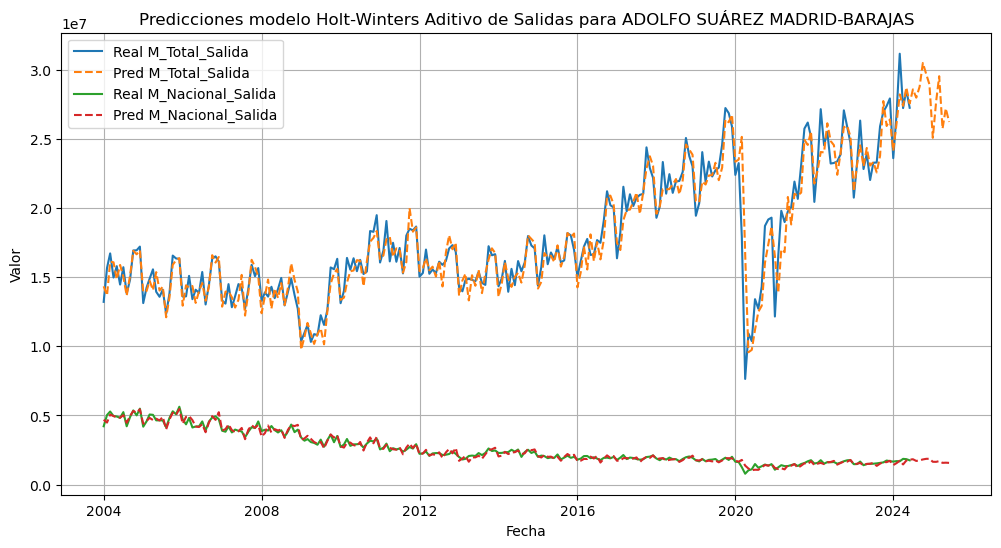

In [65]:
# Se visualizan las predicciones para un aeropuerto específico
Aeropuerto_Prediccion = 'ADOLFO SUÁREZ MADRID-BARAJAS'

# Se filtran los tipos de operación disponibles para el aeropuerto seleccionado
Tipos_Mercancias = Mercancias_Unico[Mercancias_Unico['Aeropuerto_Base'] == Aeropuerto_Prediccion]['Tipo'].unique()

# Se filtran los tipos de operación para Salida
Tipos_Salida = [tipo for tipo in Tipos_Mercancias if 'Salida' in tipo]


# Gráfico para operaciones de Salida
plt.figure(figsize=(12, 6))
for Tipo_Mercancias_Prediccion in Tipos_Salida:
    # Se filtran los datos reales para el tipo de operación
    Datos_Reales_Mercancias_HWA = Mercancias_Unico[(Mercancias_Unico['Aeropuerto_Base'] == Aeropuerto_Prediccion) & 
                                               (Mercancias_Unico['Tipo'] == Tipo_Mercancias_Prediccion)]
    
    # Se filtran las predicciones para el tipo de operación
    Datos_Predicciones_Mercancias_HWA = Predicciones_Mercancias_HWA[(Predicciones_Mercancias_HWA['Aeropuerto_Base'] == Aeropuerto_Prediccion) & 
                                                            (Predicciones_Mercancias_HWA['Tipo'] == Tipo_Mercancias_Prediccion)]
    
    # Se añaden las series reales y predicciones al gráfico
    plt.plot(Datos_Reales_Mercancias_HWA.index, Datos_Reales_Mercancias_HWA['Valor'], label=f'Real {Tipo_Mercancias_Prediccion}')
    plt.plot(Datos_Predicciones_Mercancias_HWA['Fecha'], Datos_Predicciones_Mercancias_HWA['Prediccion'], linestyle='--', label=f'Pred {Tipo_Mercancias_Prediccion}')

# Se configura el gráfico
plt.title(f'Predicciones modelo Holt-Winters Aditivo de Salidas para {Aeropuerto_Prediccion}')
plt.xlabel('Fecha')
plt.ylabel('Valor')
plt.legend()
plt.grid(True)
plt.show()

**5-c. Métricas de error**

In [46]:
# Función para calcular SMAPE
def smape(y_true_HWA, y_pred_HWA):
    return 100 / len(y_true_HWA) * np.sum(2 * np.abs(y_pred_HWA - y_true_HWA) / (np.abs(y_true_HWA) + np.abs(y_pred_HWA)))

# Se añade la métrica SMAPE
Metricas_Error_Mercancias_HWA = pd.DataFrame(columns=['Aeropuerto_Base', 'Tipo', 'MAE', 'RMSE', 'MAPE', 'SMAPE'])

for (Aeropuerto, Mercancia), (Predicciones_Originales_HWA, _, Fechas_Reales) in Dicc_Predicciones_HoltWinters_AD_M.items():
    # Se obtienen los valores reales
    Valores_Reales_Mercancia_HWA = Mercancias_Unico[(Mercancias_Unico['Aeropuerto_Base'] == Aeropuerto) & 
                                       (Mercancias_Unico['Tipo'] == Mercancia)]['Valor']
    
    # Se calculan las métricas de error si hay valores reales para comparar
    if len(Valores_Reales_Mercancia_HWA) == len(Predicciones_Originales_HWA):
        # MAE - Error Absoluto Medio
        mae = mean_absolute_error(Valores_Reales_Mercancia_HWA, Predicciones_Originales_HWA)
        # RMSE - Error Cuatrático Medio
        rmse = np.sqrt(mean_squared_error(Valores_Reales_Mercancia_HWA, Predicciones_Originales_HWA))
        # MAPE - Error Porcentual Absoluto Medio
        mape = np.mean(np.abs((Valores_Reales_Mercancia_HWA - Predicciones_Originales_HWA) / np.where(Valores_Reales_Mercancia_HWA == 0, 1, Valores_Reales_Mercancia_HWA))) * 100
        # SMAPE
        smape_value = smape(Valores_Reales_Mercancia_HWA, Predicciones_Originales_HWA)
        
        Temp_Metricas_Error_HWA = pd.DataFrame({
            'Aeropuerto_Base': [Aeropuerto],
            'Tipo': [Mercancia],
            'MAE': [mae],
            'RMSE': [rmse],
            'MAPE': [mape],
            'SMAPE': [smape_value]
        })
        # Se concatenan las métricas de error
        Metricas_Error_Mercancias_HWA = pd.concat([Metricas_Error_Mercancias_HWA, Temp_Metricas_Error_HWA], ignore_index=True)
    else:
        print(f"Las longitudes no coinciden para {Aeropuerto} - {Mercancia}")

# Se muestran las métricas
print(Metricas_Error_Mercancias_HWA)

                  Aeropuerto_Base                Tipo            MAE  \
0                        A CORUÑA     M_Total_Llegada    2218.185275   
1                        A CORUÑA  M_Nacional_Llegada    1694.686624   
2                        A CORUÑA      M_Total_Salida    2304.707666   
3                        A CORUÑA   M_Nacional_Salida    2295.497249   
4    ADOLFO SUÁREZ MADRID-BARAJAS     M_Total_Llegada  753011.478790   
..                            ...                 ...            ...   
191                     SON BONET   M_Nacional_Salida       0.081351   
192              MURCIA COMBINADO     M_Total_Llegada     225.549142   
193              MURCIA COMBINADO  M_Nacional_Llegada      27.378342   
194              MURCIA COMBINADO      M_Total_Salida     111.826785   
195              MURCIA COMBINADO   M_Nacional_Salida     101.570623   

             RMSE         MAPE       SMAPE  
0    3.409125e+03  2866.336840   47.607987  
1    2.377713e+03  3454.299953   39.103443  


**5-d. Métricas de error promedias de todo el conjunto**

In [47]:
# Se calculan las métricas medias para este modelo 
MAE_promedio_HWA = Metricas_Error_Mercancias_HWA['MAE'].mean()
RMSE_promedio_HWA = Metricas_Error_Mercancias_HWA['RMSE'].mean()
MAPE_promedio_HWA = Metricas_Error_Mercancias_HWA['MAPE'].mean()
SMAPE_promedio_HWA = Metricas_Error_Mercancias_HWA['SMAPE'].mean()

# Se muestran los resultados Holt-Winters Aditivo
print(f"MAE Promedio Holt-Winters Aditivo: {MAE_promedio_HWA}")
print(f"RMSE Promedio Holt-Winters Aditivo: {RMSE_promedio_HWA}")
print(f"MAPE Promedio Holt-Winters Aditivo: {MAPE_promedio_HWA}%")
print(f"SMAPE Promedio Holt-Winters Aditivo: {SMAPE_promedio_HWA}%")

MAE Promedio Holt-Winters Aditivo: 117707.6972843231
RMSE Promedio Holt-Winters Aditivo: 132203.74481974577
MAPE Promedio Holt-Winters Aditivo: 13207.161800552509%
SMAPE Promedio Holt-Winters Aditivo: 102.27114962863276%


Se comparan los datos promedios con el que mejores resultados ha dado hasta el momento:

- MAE Promedio GRID SEARCH ARIMA (4,1,4): 39050.927808306435
- RMSE Promedio GRID SEARCH ARIMA (4,1,4): 57790.63168994232
- MAPE Promedio GRID SEARCH ARIMA (4,1,4): 10070.905725509423%
- SMAPE Promedio GRID SEARCH ARIMA (4,1,4): 70.0388503930309%

A diferencia que ocurrió con los datos de operaciones y pasajeros, este modelo no ha mejorado las métricas.
Por lo que por ahora este el mejor modelo sigue siendo el Grid Serach ARIMA (4,1,4).
Del mismo modo, no se va a probar con el multiplicativo, debido a que se conoce que hay aeropuertos para los cuales no hay datos va a haber problemas a la hora de realizar el modelo.

**6. Modelo Random Forest con Random Search**

Se prueba otro Random Forest pero esta vez con el Random Search, para obtener los hiperparámetros de manera aleatoria

In [48]:
#Se crea un diccionario para almacenar las predicciones
Dicc_Predicciones_Mercancias_RF = {}

# Función para crear variables lag
# Los lags permiten capturar patrones y dependencias en los datos pasados para mejorar la precisión de valores futuros
def crear_lags(data, lags):
    df_lags = pd.DataFrame()
    for lag in range(1, lags + 1):
        df_lags[f'lag_{lag}'] = data.shift(lag)
    df_lags['Valor'] = data.values
    return df_lags.dropna()

# Se definen los posibles hiperparámetros del modelo para RandomizedSearchCV
param_dist = {
    'n_estimators': [100, 200, 300, 500],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2']
}

# Se obtienen todos los aeropuertos y tipos únicos
Aeropuertos = Mercancias_Unico['Aeropuerto_Base'].unique()
Tipos_Mercancias = Mercancias_Unico['Tipo'].unique()

# Se itera sobre cada aeropuerto y tipo
for Aeropuerto in Aeropuertos:
    for Mercancia in Tipos_Mercancias:
        # Se filtra cada aeropuerto y tipo de operación para los datos originales "reales"
        Datos_Reales_Mercancias_RF = Mercancias_Unico[(Mercancias_Unico['Aeropuerto_Base'] == Aeropuerto) & 
                                                   (Mercancias_Unico['Tipo'] == Mercancia)]
        
        # Se comprueba que está ordenado cronológicamente
        Datos_Reales_Mercancias_RF = Datos_Reales_Mercancias_RF.sort_index()

        # Se crean las variables lag 
        lags = 3
        data_lags_RF = crear_lags(Datos_Reales_Mercancias_RF['Valor'], lags)
        
        # Se separa el conjunto en entrenamiento (80%) y test (20%)
        X = data_lags_RF.drop(columns=['Valor'])
        y = data_lags_RF['Valor']
        X_train_RF, X_test_RF, y_train_RF, y_test_RF = train_test_split(X, y, test_size=0.2, shuffle=False)
        
        # Se aplica RandomizedSearchCV para encontrar los mejores hiperparámetros
        try:
            model_RF = RandomForestRegressor(random_state=42)
            random_search = RandomizedSearchCV(model_RF, param_distributions=param_dist, n_iter=50, cv=3, verbose=2, random_state=42, n_jobs=-1)
            random_search.fit(X_train_RF, y_train_RF)

            # Se entrena el modelo con los mejores hiperparámetros encontrados
            best_rf_model = random_search.best_estimator_

            # Se realiza las predicciones sobre los datos históricos
            Predicciones_Originales_RF = best_rf_model.predict(X_test_RF)
            
            # Se realiza las predicciones futuras, pero es necesario construir las características de manera iterativa
            last_values = X_test_RF.iloc[-1].values
            Predicciones_Futuras_RF = []
            for _ in range(12):
                next_pred = best_rf_model.predict(pd.DataFrame([last_values], columns=X.columns))
                Predicciones_Futuras_RF.append(next_pred[0])
                last_values = np.roll(last_values, -1)
                last_values[-1] = next_pred[0]  # Extraer el valor escalar de next_pred

            # Se convierten las predicciones futuras en un array de pandas
            Predicciones_Futuras_RF = pd.Series(Predicciones_Futuras_RF)

            # Se almacenan las predicciones en el diccionario
            Dicc_Predicciones_Mercancias_RF[(Aeropuerto, Mercancia)] = (Predicciones_Originales_RF, Predicciones_Futuras_RF, Datos_Reales_Mercancias_RF.index[-len(Predicciones_Originales_RF):])
        
        except Exception as e:
            print(f"Error al entrenar el modelo para {Aeropuerto}, {Mercancia}: {e}")

# Se muestra el mejor conjunto de parámetros
print(f"Mejor conjunto de parámetros: {random_search.best_params_}")

Fitting 3 folds for each of 50 candidates, totalling 150 fits
Fitting 3 folds for each of 50 candidates, totalling 150 fits
Fitting 3 folds for each of 50 candidates, totalling 150 fits
Fitting 3 folds for each of 50 candidates, totalling 150 fits
Fitting 3 folds for each of 50 candidates, totalling 150 fits
Fitting 3 folds for each of 50 candidates, totalling 150 fits
Fitting 3 folds for each of 50 candidates, totalling 150 fits
Fitting 3 folds for each of 50 candidates, totalling 150 fits
Fitting 3 folds for each of 50 candidates, totalling 150 fits
Fitting 3 folds for each of 50 candidates, totalling 150 fits
Fitting 3 folds for each of 50 candidates, totalling 150 fits
Fitting 3 folds for each of 50 candidates, totalling 150 fits
Fitting 3 folds for each of 50 candidates, totalling 150 fits
Fitting 3 folds for each of 50 candidates, totalling 150 fits
Fitting 3 folds for each of 50 candidates, totalling 150 fits
Fitting 3 folds for each of 50 candidates, totalling 150 fits
Fitting 

**6-a. Dataframe en el que se guardan las predicciones y los datos reales**

In [50]:
# Se crea un dataframe para poder comparar las predicciones
Comparacion_Total_Todos_Aeropuertos_RF_M = pd.DataFrame(columns=['Aeropuerto_Base', 'Tipo', 'Fecha', 'Valor Real', 'Prediccion'])

for (Aeropuerto, Mercancia), (Predicciones_Originales_RF, Predicciones_Futuras_RF, Fechas_Reales) in Dicc_Predicciones_Mercancias_RF.items():
    # Se extraen los valores reales coincidentes con las predicciones originales
    Valores_Reales_Mercancias_RF = Mercancias_Unico[(Mercancias_Unico['Aeropuerto_Base'] == Aeropuerto) & 
                                                  (Mercancias_Unico['Tipo'] == Mercancia)].loc[Fechas_Reales, 'Valor']
    
    # Alinear las fechas para que ambas series tengan las mismas fechas
    Fechas_Coincidentes = Valores_Reales_Mercancias_RF.dropna().index.intersection(Fechas_Reales)
    Predicciones_Originales_RF_Al = Predicciones_Originales_RF[Fechas_Reales.isin(Fechas_Coincidentes)]
    Valores_Reales_Mercancia_RF_Al = Valores_Reales_Mercancias_RF.loc[Fechas_Coincidentes]
    
    # Se comprueba que ambas longitudes coinciden
    if len(Valores_Reales_Mercancia_RF_Al) == len(Predicciones_Originales_RF_Al):
        # Se crea un DataFrame temporal para las predicciones históricas con los valores originales
        Tem_Predicciones_Historicas_RF = pd.DataFrame({
            'Aeropuerto_Base': [Aeropuerto] * len(Fechas_Coincidentes),
            'Tipo': [Mercancia] * len(Fechas_Coincidentes),
            'Fecha': Fechas_Coincidentes,
            'Valor Real': Valores_Reales_Mercancia_RF_Al,
            'Prediccion': Predicciones_Originales_RF_Al
        })

        # Se concatenan las predicciones históricas
        Comparacion_Total_Todos_Aeropuertos_RF_M = pd.concat([Comparacion_Total_Todos_Aeropuertos_RF_M, Tem_Predicciones_Historicas_RF], ignore_index=True)
    else:
        print(f"Las longitudes no coinciden después de la alineación para {Aeropuerto} - {Mercancia}")

# Se muestran las últimas filas para ver los valores reales y predicciones
print(Comparacion_Total_Todos_Aeropuertos_RF_M.tail(20))

       Aeropuerto_Base               Tipo      Fecha Valor Real  Prediccion
9584  MURCIA COMBINADO  M_Nacional_Salida 2022-11-01          0    0.058908
9585  MURCIA COMBINADO  M_Nacional_Salida 2022-12-01          0    0.058908
9586  MURCIA COMBINADO  M_Nacional_Salida 2023-01-01          0    0.058908
9587  MURCIA COMBINADO  M_Nacional_Salida 2023-02-01          0    0.058908
9588  MURCIA COMBINADO  M_Nacional_Salida 2023-03-01          0    0.058908
9589  MURCIA COMBINADO  M_Nacional_Salida 2023-04-01          0    0.058908
9590  MURCIA COMBINADO  M_Nacional_Salida 2023-05-01          0    0.058908
9591  MURCIA COMBINADO  M_Nacional_Salida 2023-06-01          0    0.058908
9592  MURCIA COMBINADO  M_Nacional_Salida 2023-07-01          0    0.058908
9593  MURCIA COMBINADO  M_Nacional_Salida 2023-08-01          0    0.058908
9594  MURCIA COMBINADO  M_Nacional_Salida 2023-09-01          0    0.058908
9595  MURCIA COMBINADO  M_Nacional_Salida 2023-10-01          0    0.058908
9596  MURCIA

In [51]:
# Se convierten los valores a flotantes si no son nulos y no son cadenas vacías
Comparacion_Total_Todos_Aeropuertos_RF_M['Valor Real'] = Comparacion_Total_Todos_Aeropuertos_RF_M['Valor Real'].apply(lambda x: float(x) if pd.notnull(x) and x != '' else x)
Comparacion_Total_Todos_Aeropuertos_RF_M['Prediccion'] = Comparacion_Total_Todos_Aeropuertos_RF_M['Prediccion'].apply(lambda x: float(x) if pd.notnull(x) and x != '' else x)

# Se reemplazan los puntos por comas en las columnas de interés ('Valor Real' y 'Prediccion')
Comparacion_Total_Todos_Aeropuertos_RF_M['Valor Real'] = Comparacion_Total_Todos_Aeropuertos_RF_M['Valor Real'].apply(lambda x: f"{x:.2f}".replace('.', ',') if pd.notnull(x) else '')
Comparacion_Total_Todos_Aeropuertos_RF_M['Prediccion'] = Comparacion_Total_Todos_Aeropuertos_RF_M['Prediccion'].apply(lambda x: f"{x:.2f}".replace('.', ',') if pd.notnull(x) else '')

# Se muestran las últimas filas para verificar los cambios
print(Comparacion_Total_Todos_Aeropuertos_RF_M.tail(20))

       Aeropuerto_Base               Tipo      Fecha Valor Real Prediccion
9584  MURCIA COMBINADO  M_Nacional_Salida 2022-11-01       0,00       0,06
9585  MURCIA COMBINADO  M_Nacional_Salida 2022-12-01       0,00       0,06
9586  MURCIA COMBINADO  M_Nacional_Salida 2023-01-01       0,00       0,06
9587  MURCIA COMBINADO  M_Nacional_Salida 2023-02-01       0,00       0,06
9588  MURCIA COMBINADO  M_Nacional_Salida 2023-03-01       0,00       0,06
9589  MURCIA COMBINADO  M_Nacional_Salida 2023-04-01       0,00       0,06
9590  MURCIA COMBINADO  M_Nacional_Salida 2023-05-01       0,00       0,06
9591  MURCIA COMBINADO  M_Nacional_Salida 2023-06-01       0,00       0,06
9592  MURCIA COMBINADO  M_Nacional_Salida 2023-07-01       0,00       0,06
9593  MURCIA COMBINADO  M_Nacional_Salida 2023-08-01       0,00       0,06
9594  MURCIA COMBINADO  M_Nacional_Salida 2023-09-01       0,00       0,06
9595  MURCIA COMBINADO  M_Nacional_Salida 2023-10-01       0,00       0,06
9596  MURCIA COMBINADO  M

**6-b. Métricas de error**

In [52]:
# Función para calcular SMAPE
def smape(y_true_RF, y_pred_RF):
    return 100 / len(y_true_RF) * np.sum(2 * np.abs(y_pred_RF - y_true_RF) / (np.abs(y_true_RF) + np.abs(y_pred_RF)))

# Se añade la métrica SMAPE
Metricas_Error_Mercancias_RF = pd.DataFrame(columns=['Aeropuerto_Base', 'Tipo', 'MAE', 'RMSE', 'MAPE', 'SMAPE'])

for (Aeropuerto, Mercancia), (Predicciones_Originales_RF, _, Fechas_Reales) in Dicc_Predicciones_Mercancias_RF.items():
    # Se alinean las fechas de los valores reales y predicciones
    Valores_Reales_Mercancia_RF = Mercancias_Unico[(Mercancias_Unico['Aeropuerto_Base'] == Aeropuerto) & 
                                                 (Mercancias_Unico['Tipo'] == Mercancia)]['Valor']
    Fechas_Coincidentes = Valores_Reales_Mercancias_RF.dropna().index.intersection(Fechas_Reales)
    Predicciones_Originales_RF_Al = Predicciones_Originales_RF[Fechas_Reales.isin(Fechas_Coincidentes)]
    Valores_Reales_Mercancias_RF_Al = Valores_Reales_Mercancias_RF.loc[Fechas_Coincidentes]

    # Se calculan las métricas de error si hay valores reales para comparar
    if len(Valores_Reales_Mercancias_RF_Al) == len(Predicciones_Originales_RF_Al):
        # MAE - Error Absoluto Medio
        mae = mean_absolute_error(Valores_Reales_Mercancias_RF_Al, Predicciones_Originales_RF_Al)
        # RMSE - Error Cuadrático Medio
        rmse = np.sqrt(mean_squared_error(Valores_Reales_Mercancias_RF_Al, Predicciones_Originales_RF_Al))
        # MAPE - Error Porcentual Absoluto Medio
        mape = np.mean(np.abs((Valores_Reales_Mercancias_RF_Al - Predicciones_Originales_RF_Al) / np.where(Valores_Reales_Mercancias_RF_Al == 0, 1, Valores_Reales_Mercancias_RF_Al))) * 100
        # SMAPE
        smape_value = smape(Valores_Reales_Mercancias_RF_Al, Predicciones_Originales_RF_Al)
        
        Temp_Metricas_Error_RF = pd.DataFrame({
            'Aeropuerto_Base': [Aeropuerto],
            'Tipo': [Mercancia],
            'MAE': [mae],
            'RMSE': [rmse],
            'MAPE': [mape],
            'SMAPE': [smape_value]
        })
        # Se concatenan las métricas de error
        Metricas_Error_Mercancias_RF = pd.concat([Metricas_Error_Mercancias_RF, Temp_Metricas_Error_RF], ignore_index=True)
    else:
        print(f"Las longitudes no coinciden para {Aeropuerto} - {Mercancia}")

# Se muestran las métricas
print(Metricas_Error_Mercancias_RF)

                  Aeropuerto_Base                Tipo           MAE  \
0                        A CORUÑA     M_Total_Llegada  2.408432e+03   
1                        A CORUÑA  M_Nacional_Llegada  2.452616e+03   
2                        A CORUÑA      M_Total_Salida  5.258625e+03   
3                        A CORUÑA   M_Nacional_Salida  5.432428e+03   
4    ADOLFO SUÁREZ MADRID-BARAJAS     M_Total_Llegada  2.176811e+07   
..                            ...                 ...           ...   
191                     SON BONET   M_Nacional_Salida  4.414635e-02   
192              MURCIA COMBINADO     M_Total_Llegada  7.311346e+00   
193              MURCIA COMBINADO  M_Nacional_Llegada  2.449665e+00   
194              MURCIA COMBINADO      M_Total_Salida  2.782482e+00   
195              MURCIA COMBINADO   M_Nacional_Salida  5.890756e-02   

             RMSE          MAPE  SMAPE  
0    2.462586e+03  2.408432e+05  200.0  
1    2.501262e+03  2.452616e+05  200.0  
2    5.456769e+03  5.258

**6-c. Métricas de error promedias de todo el conjunto**

In [53]:
# Se calculan las métricas medias para este modelo 
MAE_promedio_RF = Metricas_Error_Mercancias_RF['MAE'].mean()
RMSE_promedio_RF = Metricas_Error_Mercancias_RF['RMSE'].mean()
MAPE_promedio_RF = Metricas_Error_Mercancias_RF['MAPE'].mean()
SMAPE_promedio_RF = Metricas_Error_Mercancias_RF['SMAPE'].mean()

# Se muestran los resultados Random Forest - random search
print(f"MAE Promedio Random Forest - random search: {MAE_promedio_RF}")
print(f"RMSE Promedio Random Forest - random search: {RMSE_promedio_RF}")
print(f"MAPE Promedio Random Forest - random search: {MAPE_promedio_RF}%")
print(f"SMAPE Promedio Random Forest - random search: {SMAPE_promedio_RF}%")

MAE Promedio Random Forest - random search: 445814.99839376705
RMSE Promedio Random Forest - random search: 452124.2779956756
MAPE Promedio Random Forest - random search: 44581499.839376695%
SMAPE Promedio Random Forest - random search: 179.5710120783007%


En términos generales, este modelo ha empeorado con respecto al anterior tanto para las métricas de MAE como RMSE, por lo que también se descarta.

**7. Modelo Autoarima**

El último modelo que se va a probar es el AutoARIMA

In [54]:
# Se crea un diccionario para almacenar las predicciones
Dicc_Predicciones_AutoARIMA_M = {}

# Se obtienen todos los aeropuertos y tipos únicos
Aeropuertos = Mercancias_Unico['Aeropuerto_Base'].unique()
Tipos_Mercancias = Mercancias_Unico['Tipo'].unique()

# Se itera sobre cada aeropuerto y tipo
for Aeropuerto in Aeropuertos:
    for Mercancia in Tipos_Mercancias:
        # Se filtra cada aeropuerto y tipo de operación para los datos originales "reales"
        Datos_Reales_Mercancias_ARIMA = Mercancias_Unico[(Mercancias_Unico['Aeropuerto_Base'] == Aeropuerto) & 
                                                         (Mercancias_Unico['Tipo'] == Mercancia)]
        
        # Se comprueba que está ordenado cronológicamente
        Datos_Reales_Mercancias_ARIMA = Datos_Reales_Mercancias_ARIMA.sort_index()

        # Se entrena el modelo AutoARIMA
        try:
            model_auto_arima = auto_arima(Datos_Reales_Mercancias_ARIMA['Valor'], 
                                          seasonal=False, 
                                          stepwise=True, 
                                          trace=True, 
                                          error_action='ignore', 
                                          suppress_warnings=True)
            
            # Se realizan predicciones sobre los datos históricos
            Predicciones_Originales_ARIMA = model_auto_arima.predict_in_sample()
            
            # Se realizan predicciones para fechas futuras, 12 meses por ejemplo
            Predicciones_Futuras_ARIMA = model_auto_arima.predict(n_periods=12)

            # Se almacenan las predicciones en el diccionario
            Dicc_Predicciones_AutoARIMA_M[(Aeropuerto, Mercancia)] = (Predicciones_Originales_ARIMA, Predicciones_Futuras_ARIMA, Datos_Reales_Mercancias_ARIMA.index)
        
        except Exception as e:
            print(f"Error al entrenar el modelo AutoARIMA para {Aeropuerto}, {Mercancia}: {e}")

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=4656.342, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4711.993, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4679.578, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=4663.504, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4710.041, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.18 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=4651.101, Time=0.07 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=4665.491, Time=0.05 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=4650.647, Time=0.04 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=4650.510, Time=0.05 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=4652.495, Time=0.06 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=4652.534, Time=0.13 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=4654.963, Time=0.22 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=4648.488, Time=0.03 sec
 ARIMA(2,1,0)(0,0,0)[0]             : 

**7-a. Dataframe en el que se guardan las predicciones y los datos reales**

In [55]:
# Se crea un dataframe para poder comparar las predicciones
Comparacion_Total_Todos_Aeropuertos_AutoARIMA_M = pd.DataFrame(columns=['Aeropuerto_Base', 'Tipo', 'Fecha', 'Valor Real', 'Prediccion'])

for (Aeropuerto, Mercancia), (Predicciones_Originales_ARIMA, Predicciones_Futuras_ARIMA, Fechas_Reales) in Dicc_Predicciones_AutoARIMA_M.items():
    # Se extraen los valores reales coincidentes con las predicciones originales
    Valores_Reales_Mercancia_AutoARIMA = Mercancias_Unico[(Mercancias_Unico['Aeropuerto_Base'] == Aeropuerto) & 
                                        (Mercancias_Unico['Tipo'] == Mercancia)].loc[Fechas_Reales, 'Valor']
    
    # Se comprueba que ambas longitudes coinciden
    min_len = min(len(Fechas_Reales), len(Predicciones_Originales_ARIMA), len(Valores_Reales_Mercancia_AutoARIMA))
    
    # Se crea un DataFrame temporal para las predicciones históricas con los valores originales
    Tem_Predicciones_Historicas_AutoARIMA = pd.DataFrame({
        'Aeropuerto_Base': [Aeropuerto] * min_len,
        'Tipo': [Mercancia] * min_len,
        'Fecha': Fechas_Reales[:min_len],
        'Valor Real': Valores_Reales_Mercancia_AutoARIMA[:min_len],
        'Prediccion': Predicciones_Originales_ARIMA[:min_len]
    })

    # Se filtran las columnas que contenga un NaN, en el caso de las históricas, son todas aquellas que pasan de la fecha de junio 2024
    Tem_Predicciones_Historicas_AutoARIMA = Tem_Predicciones_Historicas_AutoARIMA.dropna(axis=1, how='all')

    # Se crea un DataFrame temporal para las predicciones futuras
    Fechas_Futuras = pd.date_range(start=Fechas_Reales[-1] + pd.offsets.MonthBegin(1), periods=len(Predicciones_Futuras_ARIMA), freq='MS')
    Temp_Predicciones_Futuras_AutoARIMA = pd.DataFrame({
        'Aeropuerto_Base': [Aeropuerto] * len(Predicciones_Futuras_ARIMA),
        'Tipo': [Mercancia] * len(Predicciones_Futuras_ARIMA),
        'Fecha': Fechas_Futuras,
        'Valor Real': [None] * len(Predicciones_Futuras_ARIMA),
        'Prediccion': Predicciones_Futuras_ARIMA
    })

    # Se filtran las columnas que contenga un NaN
    Temp_Predicciones_Futuras_AutoARIMA = Temp_Predicciones_Futuras_AutoARIMA.dropna(axis=1, how='all')

    # Se concatena los dos dataframe (históricos y futuros)
    Comparacion_Total_Todos_Aeropuertos_AutoARIMA_M = pd.concat([Comparacion_Total_Todos_Aeropuertos_AutoARIMA_M, Tem_Predicciones_Historicas_AutoARIMA, Temp_Predicciones_Futuras_AutoARIMA], ignore_index=True)

# Se muestran las últimas filas para ver los valores reales y predicciones
print(Comparacion_Total_Todos_Aeropuertos_AutoARIMA_M.tail(20))

        Aeropuerto_Base               Tipo      Fecha  Valor Real  Prediccion
50548  MURCIA COMBINADO  M_Nacional_Salida 2023-11-01         0.0  -18.983796
50549  MURCIA COMBINADO  M_Nacional_Salida 2023-12-01         0.0  -18.983796
50550  MURCIA COMBINADO  M_Nacional_Salida 2024-01-01         0.0  -18.983796
50551  MURCIA COMBINADO  M_Nacional_Salida 2024-02-01         0.0  -18.983796
50552  MURCIA COMBINADO  M_Nacional_Salida 2024-03-01         0.0  -18.983796
50553  MURCIA COMBINADO  M_Nacional_Salida 2024-04-01         0.0  -18.983796
50554  MURCIA COMBINADO  M_Nacional_Salida 2024-05-01         0.0  -18.983796
50555  MURCIA COMBINADO  M_Nacional_Salida 2024-06-01         0.0  -18.983796
50556  MURCIA COMBINADO  M_Nacional_Salida 2024-07-01         NaN  -18.983796
50557  MURCIA COMBINADO  M_Nacional_Salida 2024-08-01         NaN  -26.265544
50558  MURCIA COMBINADO  M_Nacional_Salida 2024-09-01         NaN  -30.655252
50559  MURCIA COMBINADO  M_Nacional_Salida 2024-10-01         Na

In [56]:
# Se convierten los valores a flotantes si no son nulos y no son cadenas vacías
Comparacion_Total_Todos_Aeropuertos_AutoARIMA_M['Valor Real'] = Comparacion_Total_Todos_Aeropuertos_AutoARIMA_M['Valor Real'].apply(lambda x: float(x) if pd.notnull(x) and x != '' else x)
Comparacion_Total_Todos_Aeropuertos_AutoARIMA_M['Prediccion'] = Comparacion_Total_Todos_Aeropuertos_AutoARIMA_M['Prediccion'].apply(lambda x: float(x) if pd.notnull(x) and x != '' else x)

# Se reemplazan los puntos por comas en las columnas de interés ('Valor Real' y 'Prediccion')
Comparacion_Total_Todos_Aeropuertos_AutoARIMA_M['Valor Real'] = Comparacion_Total_Todos_Aeropuertos_AutoARIMA_M['Valor Real'].apply(lambda x: f"{x:.2f}".replace('.', ',') if pd.notnull(x) else '')
Comparacion_Total_Todos_Aeropuertos_AutoARIMA_M['Prediccion'] = Comparacion_Total_Todos_Aeropuertos_AutoARIMA_M['Prediccion'].apply(lambda x: f"{x:.2f}".replace('.', ',') if pd.notnull(x) else '')

# Se muestran las últimas filas para verificar los cambios
print(Comparacion_Total_Todos_Aeropuertos_AutoARIMA_M.tail(20))

        Aeropuerto_Base               Tipo      Fecha Valor Real Prediccion
50548  MURCIA COMBINADO  M_Nacional_Salida 2023-11-01       0,00     -18,98
50549  MURCIA COMBINADO  M_Nacional_Salida 2023-12-01       0,00     -18,98
50550  MURCIA COMBINADO  M_Nacional_Salida 2024-01-01       0,00     -18,98
50551  MURCIA COMBINADO  M_Nacional_Salida 2024-02-01       0,00     -18,98
50552  MURCIA COMBINADO  M_Nacional_Salida 2024-03-01       0,00     -18,98
50553  MURCIA COMBINADO  M_Nacional_Salida 2024-04-01       0,00     -18,98
50554  MURCIA COMBINADO  M_Nacional_Salida 2024-05-01       0,00     -18,98
50555  MURCIA COMBINADO  M_Nacional_Salida 2024-06-01       0,00     -18,98
50556  MURCIA COMBINADO  M_Nacional_Salida 2024-07-01                -18,98
50557  MURCIA COMBINADO  M_Nacional_Salida 2024-08-01                -26,27
50558  MURCIA COMBINADO  M_Nacional_Salida 2024-09-01                -30,66
50559  MURCIA COMBINADO  M_Nacional_Salida 2024-10-01                -34,33
50560  MURCI

**7-b.Visualización de las predicciones**

In [57]:
# Se crea un DataFrame para almacenar todas las predicciones
Predicciones_Mercancia_AutoARIMA = pd.DataFrame(columns=['Aeropuerto_Base', 'Tipo', 'Fecha', 'Prediccion'])

for (Aeropuerto, Mercancia), (Predicciones_Originales_ARIMA, Predicciones_Futuras_ARIMA, Fechas_Reales) in Dicc_Predicciones_AutoARIMA_M.items():
    # Se guardan en un DataFrame temporal para las predicciones de los datos orginales "reales"
    Tem_Predicciones_Historicas_AutoARIMA = pd.DataFrame({
        'Aeropuerto_Base': Aeropuerto,
        'Tipo': Mercancia,
        'Fecha': Fechas_Reales,
        'Prediccion': Predicciones_Originales_ARIMA
    })

    # Se guardan en un DataFrame temporal para las predicciones de fechas futuras
    Fechas_Futuras = pd.date_range(start=Fechas_Reales[-1] + pd.offsets.MonthBegin(1), periods=len(Predicciones_Futuras_ARIMA), freq='MS')
    Temp_Predicciones_Futuras_AutoARIMA = pd.DataFrame({
        'Aeropuerto_Base': Aeropuerto,
        'Tipo': Mercancia,
        'Fecha': Fechas_Futuras,
        'Prediccion': Predicciones_Futuras_ARIMA
    })

    # Se concatenan ambas predicciones y se guardan en un dataframe único
    Predicciones_Mercancia_AutoARIMA = pd.concat([Predicciones_Mercancia_AutoARIMA, Tem_Predicciones_Historicas_AutoARIMA, Temp_Predicciones_Futuras_AutoARIMA], ignore_index=True)

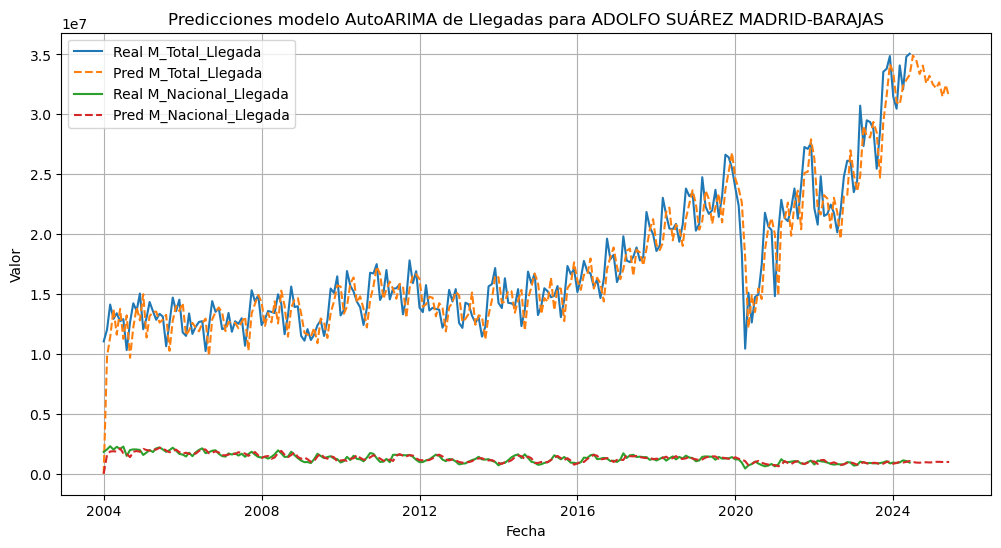

In [59]:
# Se visualizan las predicciones para un aeropuerto específico
Aeropuerto_Prediccion = 'ADOLFO SUÁREZ MADRID-BARAJAS'

# Se filtran los tipos de operación disponibles para el aeropuerto seleccionado
Tipos_Mercancias = Mercancias_Unico[Mercancias_Unico['Aeropuerto_Base'] == Aeropuerto_Prediccion]['Tipo'].unique()

# Se filtran los tipos de operación para Llegada
Tipos_Llegada = [tipo for tipo in Tipos_Mercancias if 'Llegada' in tipo]


# Gráfico para operaciones de Llegada
plt.figure(figsize=(12, 6))
for Tipo_Mercancias_Prediccion in Tipos_Llegada:
    # Se filtran los datos reales para el tipo de operación
    Datos_Reales_Mercancias_ARIMA = Mercancias_Unico[(Mercancias_Unico['Aeropuerto_Base'] == Aeropuerto_Prediccion) & 
                                               (Mercancias_Unico['Tipo'] == Tipo_Mercancias_Prediccion)]
    
    # Se filtran las predicciones para el tipo de operación
    Datos_Predicciones_Mercancias_ARIMA = Predicciones_Mercancia_AutoARIMA[(Predicciones_Mercancia_AutoARIMA['Aeropuerto_Base'] == Aeropuerto_Prediccion) & 
                                                            (Predicciones_Mercancia_AutoARIMA['Tipo'] == Tipo_Mercancias_Prediccion)]
    
    # Se añaden las series reales y predicciones al gráfico
    plt.plot(Datos_Reales_Mercancias_ARIMA.index, Datos_Reales_Mercancias_ARIMA['Valor'], label=f'Real {Tipo_Mercancias_Prediccion}')
    plt.plot(Datos_Predicciones_Mercancias_ARIMA['Fecha'], Datos_Predicciones_Mercancias_ARIMA['Prediccion'], linestyle='--', label=f'Pred {Tipo_Mercancias_Prediccion}')

# Se configura el gráfico
plt.title(f'Predicciones modelo AutoARIMA de Llegadas para {Aeropuerto_Prediccion}')
plt.xlabel('Fecha')
plt.ylabel('Valor')
plt.legend()
plt.grid(True)
plt.show()

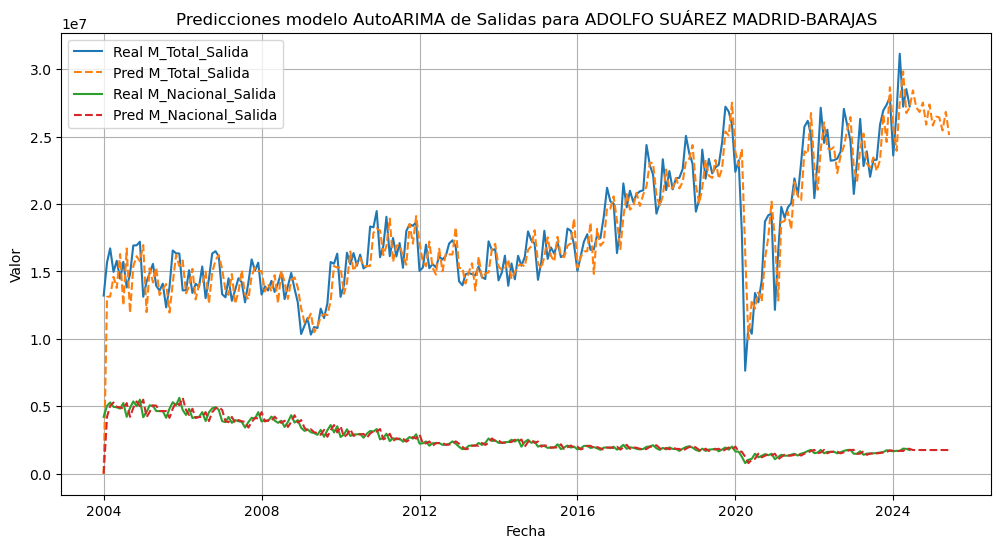

In [60]:
# Se visualizan las predicciones para un aeropuerto específico
Aeropuerto_Prediccion = 'ADOLFO SUÁREZ MADRID-BARAJAS'

# Se filtran los tipos de operación disponibles para el aeropuerto seleccionado
Tipos_Mercancias = Mercancias_Unico[Mercancias_Unico['Aeropuerto_Base'] == Aeropuerto_Prediccion]['Tipo'].unique()

# Se filtran los tipos de operación para Salida
Tipos_Salida = [tipo for tipo in Tipos_Mercancias if 'Salida' in tipo]


# Gráfico para operaciones de Llegada
plt.figure(figsize=(12, 6))
for Tipo_Mercancias_Prediccion in Tipos_Salida:
    # Se filtran los datos reales para el tipo de operación
    Datos_Reales_Mercancias_ARIMA = Mercancias_Unico[(Mercancias_Unico['Aeropuerto_Base'] == Aeropuerto_Prediccion) & 
                                               (Mercancias_Unico['Tipo'] == Tipo_Mercancias_Prediccion)]
    
    # Se filtran las predicciones para el tipo de operación
    Datos_Predicciones_Mercancias_ARIMA = Predicciones_Mercancia_AutoARIMA[(Predicciones_Mercancia_AutoARIMA['Aeropuerto_Base'] == Aeropuerto_Prediccion) & 
                                                            (Predicciones_Mercancia_AutoARIMA['Tipo'] == Tipo_Mercancias_Prediccion)]
    
    # Se añaden las series reales y predicciones al gráfico
    plt.plot(Datos_Reales_Mercancias_ARIMA.index, Datos_Reales_Mercancias_ARIMA['Valor'], label=f'Real {Tipo_Mercancias_Prediccion}')
    plt.plot(Datos_Predicciones_Mercancias_ARIMA['Fecha'], Datos_Predicciones_Mercancias_ARIMA['Prediccion'], linestyle='--', label=f'Pred {Tipo_Mercancias_Prediccion}')

# Se configura el gráfico
plt.title(f'Predicciones modelo AutoARIMA de Salidas para {Aeropuerto_Prediccion}')
plt.xlabel('Fecha')
plt.ylabel('Valor')
plt.legend()
plt.grid(True)
plt.show()

**7-c. Métricas de error**

In [61]:
# Función para calcular SMAPE
def smape(y_true_Auto, y_pred_Auto):
    return 100 / len(y_true_Auto) * np.sum(2 * np.abs(y_pred_Auto - y_true_Auto) / (np.abs(y_true_Auto) + np.abs(y_pred_Auto)))

# Se añade la métrica SMAPE
Metricas_Error_Mercancias_Auto = pd.DataFrame(columns=['Aeropuerto_Base', 'Tipo', 'MAE', 'RMSE', 'MAPE', 'SMAPE'])

for (Aeropuerto, Mercancia), (Predicciones_Originales_ARIMA, _, Fechas_Reales) in Dicc_Predicciones_AutoARIMA_M.items():
    # Se alinean las fechas de los valores reales y predicciones
    Valores_Reales_Mercancia_AutoARIMA = Mercancias_Unico[(Mercancias_Unico['Aeropuerto_Base'] == Aeropuerto) & 
                                                 (Mercancias_Unico['Tipo'] == Mercancia)]['Valor']
    Fechas_Coincidentes = Valores_Reales_Mercancia_AutoARIMA.dropna().index.intersection(Fechas_Reales)
    Predicciones_Originales_ARIMA = Predicciones_Originales_ARIMA[Fechas_Reales.isin(Fechas_Coincidentes)]
    Valores_Reales_Mercancia_AutoARIMA = Valores_Reales_Mercancia_AutoARIMA.loc[Fechas_Coincidentes]

    # Se calculan las métricas de error si hay valores reales para comparar
    if len(Valores_Reales_Mercancia_AutoARIMA) == len(Predicciones_Originales_ARIMA):
        # MAE - Error Absoluto Medio
        mae = mean_absolute_error(Valores_Reales_Mercancia_AutoARIMA, Predicciones_Originales_ARIMA)
        # RMSE - Error Cuadrático Medio
        rmse = np.sqrt(mean_squared_error(Valores_Reales_Mercancia_AutoARIMA, Predicciones_Originales_ARIMA))
        # MAPE - Error Porcentual Absoluto Medio
        mape = np.mean(np.abs((Valores_Reales_Mercancia_AutoARIMA - Predicciones_Originales_ARIMA) / np.where(Valores_Reales_Mercancia_AutoARIMA == 0, 1, Valores_Reales_Mercancia_AutoARIMA))) * 100
        # SMAPE
        smape_value = smape(Valores_Reales_Mercancia_AutoARIMA, Predicciones_Originales_ARIMA)
        
        Temp_Metricas_Error_AutoARIMA = pd.DataFrame({
            'Aeropuerto_Base': [Aeropuerto],
            'Tipo': [Mercancia],
            'MAE': [mae],
            'RMSE': [rmse],
            'MAPE': [mape],
            'SMAPE': [smape_value]
        })
        # Se concatenan las métricas de error
        Metricas_Error_Mercancias_Auto = pd.concat([Metricas_Error_Mercancias_Auto, Temp_Metricas_Error_AutoARIMA], ignore_index=True)
    else:
        print(f"Las longitudes no coinciden para {Aeropuerto} - {Mercancia}")

# Se muestran las métricas
print(Metricas_Error_Mercancias_Auto)

                  Aeropuerto_Base                Tipo           MAE  \
0                        A CORUÑA     M_Total_Llegada  1.951657e+03   
1                        A CORUÑA  M_Nacional_Llegada  1.621322e+03   
2                        A CORUÑA      M_Total_Salida  2.604467e+03   
3                        A CORUÑA   M_Nacional_Salida  2.626360e+03   
4    ADOLFO SUÁREZ MADRID-BARAJAS     M_Total_Llegada  1.469837e+06   
..                            ...                 ...           ...   
191                     SON BONET   M_Nacional_Salida  3.252033e-02   
192              MURCIA COMBINADO     M_Total_Llegada  1.508481e+02   
193              MURCIA COMBINADO  M_Nacional_Llegada  2.293433e+01   
194              MURCIA COMBINADO      M_Total_Salida  9.336696e+01   
195              MURCIA COMBINADO   M_Nacional_Salida  9.118538e+01   

             RMSE         MAPE       SMAPE  
0    3.200992e+03  2132.785303   35.862893  
1    2.435987e+03  2685.622390   34.714184  
2    3.89994

**7-d. Métricas de error promedias de todo el conjunto**

In [62]:
# Se calculan las métricas medias para este modelo 
MAE_promedio_AutoARIMA = Metricas_Error_Mercancias_Auto['MAE'].mean()
RMSE_promedio_AutoARIMA = Metricas_Error_Mercancias_Auto['RMSE'].mean()
MAPE_promedio_AutoARIMA = Metricas_Error_Mercancias_Auto['MAPE'].mean()
SMAPE_promedio_AutoARIMA = Metricas_Error_Mercancias_Auto['SMAPE'].mean()

# Se muestran los resultados AutoARIMA
print(f"MAE Promedio AutoARIMA: {MAE_promedio_AutoARIMA}")
print(f"RMSE Promedio AutoARIMA: {RMSE_promedio_AutoARIMA}")
print(f"MAPE Promedio AutoARIMA): {MAPE_promedio_AutoARIMA}%")
print(f"SMAPE Promedio AutoARIMA): {SMAPE_promedio_AutoARIMA}%")

MAE Promedio AutoARIMA: 39939.23772984715
RMSE Promedio AutoARIMA: 58970.16351106121
MAPE Promedio AutoARIMA): 7725.293705403638%
SMAPE Promedio AutoARIMA): 54.32049353251405%


Este modelo mejoró con respecto al RandomForest, pero si se compara con el que mejor resultado se había obtenido hasta el momento, modelo GRID SEARCH ARIMA (4,0,4):

- MAE Promedio GRID SEARCH ARIMA (4,0,4): 38067.358964320556
- RMSE Promedio GRID SEARCH ARIMA (4,0,4): 54381.151249105365
- MAPE Promedio GRID SEARCH ARIMA (4,0,4): 10572.90299465517%
- SMAPE Promedio GRID SEARCH ARIMA (4,0,4): 97.50564838102655%

Se ve que no, las métricas promedios distan considerablemente de ellas

**8. MPL Regressor**

In [5]:
# Se crea un diccionario para almacenar las predicciones
Dicc_Predicciones_Mercancias_MPL = {}

# Función para crear variables lag
def crear_lags(data, lags):
    df_lags = pd.DataFrame()
    for lag in range(1, lags + 1):
        df_lags[f'lag_{lag}'] = data.shift(lag)
    df_lags['Valor'] = data.values
    return df_lags.dropna()

# Se obtienen todos los aeropuertos y tipos únicos
Aeropuertos = Mercancias_Unico['Aeropuerto_Base'].unique()
Tipos_Mercancias = Mercancias_Unico['Tipo'].unique()

# Se itera sobre cada aeropuerto y tipo
for Aeropuerto in Aeropuertos:
    for Mercancia in Tipos_Mercancias:
        # Se filtra cada aeropuerto y tipo de operación para los datos originales "reales"
        Datos_Reales_Mercancia_MPL = Mercancias_Unico[(Mercancias_Unico['Aeropuerto_Base'] == Aeropuerto) & 
                                                   (Mercancias_Unico['Tipo'] == Mercancia)]
        
        # Se comprueba que está ordenado cronológicamente
        Datos_Reales_Mercancia_MPL = Datos_Reales_Mercancia_MPL.sort_index()

        # Se crean las variables lag 
        lags = 3
        data_lags_MPL = crear_lags(Datos_Reales_Mercancia_MPL['Valor'], lags)
        
        # Se Separa el conjunto en entrenamiento (70%) y test (30%)
        X = data_lags_MPL.drop(columns=['Valor'])
        y = data_lags_MPL['Valor']
        X_train_MPL, X_test_MPL, y_train_MPL, y_test_MPL = train_test_split(X, y, test_size=0.3, shuffle=False)
        
        # Entrenamiento y predicciones
        try:
            
            model_MPL = MLPRegressor(hidden_layer_sizes=(100,), activation='relu', solver='adam', random_state=42, max_iter=500)
            model_MPL.fit(X_train_MPL, y_train_MPL)

            # Predicciones sobre los datos históricos
            Predicciones_Originales_MPL = model_MPL.predict(X_test_MPL)

            # Predicciones futuras
            last_values = X_test_MPL.iloc[-1].values
            Predicciones_Futuras_MPL = []
            for _ in range(12):
                next_pred = model_MPL.predict(pd.DataFrame([last_values], columns=X.columns))
                Predicciones_Futuras_MPL.append(next_pred[0])
                last_values = np.roll(last_values, -1)
                last_values[-1] = next_pred[0]

            Predicciones_Futuras_MPL = pd.Series(Predicciones_Futuras_MPL)

            # Almacenar las predicciones en el diccionario
            Dicc_Predicciones_Mercancias_MPL[(Aeropuerto, Mercancia)] = (Predicciones_Originales_MPL, Predicciones_Futuras_MPL, Datos_Reales_Mercancia_MPL.index[-len(Predicciones_Originales_MPL):])

        except Exception as e:
            print(f"Error al entrenar el modelo para {Aeropuerto}, {Mercancia}: {e}")

**8-a. Dataframe en el que se guardan las predicciones y los datos reales**

In [6]:
# Se crea un dataframe para poder comparar las predicciones
Comparacion_Total_Todos_Aeropuertos_MPL_M = pd.DataFrame(columns=['Aeropuerto_Base', 'Tipo', 'Fecha', 'Valor Real', 'Prediccion'])

for (Aeropuerto, Mercancia), (Predicciones_Originales_MPL, Predicciones_Futuras_MPL, Fechas_Reales) in Dicc_Predicciones_Mercancias_MPL.items():
    # Se extraen los valores reales coincidentes con las predicciones originales
    Valores_Reales_Mercancia_MPL = Mercancias_Unico[(Mercancias_Unico['Aeropuerto_Base'] == Aeropuerto) & 
                                        (Mercancias_Unico['Tipo'] == Mercancia)].loc[Fechas_Reales, 'Valor']
    
    # Se comprueba que ambas longitudes coinciden
    min_len = min(len(Fechas_Reales), len(Predicciones_Originales_MPL), len(Valores_Reales_Mercancia_MPL))
    
    # Se crea un DataFrame temporal para las predicciones históricas con los valores originales
    Tem_Predicciones_Historicas_MPL = pd.DataFrame({
        'Aeropuerto_Base': [Aeropuerto] * min_len,
        'Tipo': [Mercancia] * min_len,
        'Fecha': Fechas_Reales[:min_len],
        'Valor Real': Valores_Reales_Mercancia_MPL[:min_len],
        'Prediccion': Predicciones_Originales_MPL[:min_len]
    })

    # Se filtran las columnas que contenga un NaN, en el caso de las históricas, son todas aquellas que pasan de la fecha de junio 2024
    Tem_Predicciones_Historicas_MPL = Tem_Predicciones_Historicas_MPL.dropna(axis=1, how='all')

    # Se crea un DataFrame temporal para las predicciones futuras
    Fechas_Futuras = pd.date_range(start=Fechas_Reales[-1] + pd.offsets.MonthBegin(1), periods=len(Predicciones_Futuras_MPL), freq='MS')
    Temp_Predicciones_Futuras_MPL = pd.DataFrame({
        'Aeropuerto_Base': [Aeropuerto] * len(Predicciones_Futuras_MPL),
        'Tipo': [Mercancia] * len(Predicciones_Futuras_MPL),
        'Fecha': Fechas_Futuras,
        'Valor Real': [None] * len(Predicciones_Futuras_MPL),
        'Prediccion': Predicciones_Futuras_MPL
    })

    # Se filtran las columnas que contenga un NaN
    Temp_Predicciones_Futuras_MPL = Temp_Predicciones_Futuras_MPL.dropna(axis=1, how='all')

    # Se concatena los dos dataframe (históricos y futuros)
    Comparacion_Total_Todos_Aeropuertos_MPL_M = pd.concat([Comparacion_Total_Todos_Aeropuertos_MPL_M, Tem_Predicciones_Historicas_MPL, Temp_Predicciones_Futuras_MPL], ignore_index=True)

# Se muestran las últimas filas para ver los valores reales y predicciones
print(Comparacion_Total_Todos_Aeropuertos_MPL_M.tail(20))

        Aeropuerto_Base               Tipo      Fecha  Valor Real  Prediccion
16640  MURCIA COMBINADO  M_Nacional_Salida 2023-11-01         0.0    1.379592
16641  MURCIA COMBINADO  M_Nacional_Salida 2023-12-01         0.0    1.379592
16642  MURCIA COMBINADO  M_Nacional_Salida 2024-01-01         0.0    1.379592
16643  MURCIA COMBINADO  M_Nacional_Salida 2024-02-01         0.0    1.379592
16644  MURCIA COMBINADO  M_Nacional_Salida 2024-03-01         0.0    1.379592
16645  MURCIA COMBINADO  M_Nacional_Salida 2024-04-01         0.0    1.379592
16646  MURCIA COMBINADO  M_Nacional_Salida 2024-05-01         0.0    1.379592
16647  MURCIA COMBINADO  M_Nacional_Salida 2024-06-01         0.0    1.379592
16648  MURCIA COMBINADO  M_Nacional_Salida 2024-07-01         NaN    1.379592
16649  MURCIA COMBINADO  M_Nacional_Salida 2024-08-01         NaN    2.828246
16650  MURCIA COMBINADO  M_Nacional_Salida 2024-09-01         NaN    2.899187
16651  MURCIA COMBINADO  M_Nacional_Salida 2024-10-01         Na

In [7]:
# Se convierten los valores a flotantes si no son nulos y no son cadenas vacías
Comparacion_Total_Todos_Aeropuertos_MPL_M['Valor Real'] = Comparacion_Total_Todos_Aeropuertos_MPL_M['Valor Real'].apply(lambda x: float(x) if pd.notnull(x) and x != '' else x)
Comparacion_Total_Todos_Aeropuertos_MPL_M['Prediccion'] = Comparacion_Total_Todos_Aeropuertos_MPL_M['Prediccion'].apply(lambda x: float(x) if pd.notnull(x) and x != '' else x)

# Se reemplazan los puntos por comas en las columnas de interés ('Valor Real' y 'Prediccion')
Comparacion_Total_Todos_Aeropuertos_MPL_M['Valor Real'] = Comparacion_Total_Todos_Aeropuertos_MPL_M['Valor Real'].apply(lambda x: f"{x:.2f}".replace('.', ',') if pd.notnull(x) else '')
Comparacion_Total_Todos_Aeropuertos_MPL_M['Prediccion'] = Comparacion_Total_Todos_Aeropuertos_MPL_M['Prediccion'].apply(lambda x: f"{x:.2f}".replace('.', ',') if pd.notnull(x) else '')

# Se muestran las últimas filas para verificar los cambios
print(Comparacion_Total_Todos_Aeropuertos_MPL_M.tail(20))

        Aeropuerto_Base               Tipo      Fecha Valor Real Prediccion
16640  MURCIA COMBINADO  M_Nacional_Salida 2023-11-01       0,00       1,38
16641  MURCIA COMBINADO  M_Nacional_Salida 2023-12-01       0,00       1,38
16642  MURCIA COMBINADO  M_Nacional_Salida 2024-01-01       0,00       1,38
16643  MURCIA COMBINADO  M_Nacional_Salida 2024-02-01       0,00       1,38
16644  MURCIA COMBINADO  M_Nacional_Salida 2024-03-01       0,00       1,38
16645  MURCIA COMBINADO  M_Nacional_Salida 2024-04-01       0,00       1,38
16646  MURCIA COMBINADO  M_Nacional_Salida 2024-05-01       0,00       1,38
16647  MURCIA COMBINADO  M_Nacional_Salida 2024-06-01       0,00       1,38
16648  MURCIA COMBINADO  M_Nacional_Salida 2024-07-01                  1,38
16649  MURCIA COMBINADO  M_Nacional_Salida 2024-08-01                  2,83
16650  MURCIA COMBINADO  M_Nacional_Salida 2024-09-01                  2,90
16651  MURCIA COMBINADO  M_Nacional_Salida 2024-10-01                  4,70
16652  MURCI

**8-b.Visualización de las predicciones**

In [8]:
# Se crea un DataFrame para almacenar todas las predicciones
Predicciones_Mercancia_MPL = pd.DataFrame(columns=['Aeropuerto_Base', 'Tipo', 'Fecha', 'Prediccion'])

for (Aeropuerto, Mercancia), (Predicciones_Originales_MPL, Predicciones_Futuras_MPL, Fechas_Reales) in Dicc_Predicciones_Mercancias_MPL.items():
    # Se guardan en un DataFrame temporal para las predicciones de los datos orginales "reales"
    Tem_Predicciones_Historicas_MPL = pd.DataFrame({
        'Aeropuerto_Base': Aeropuerto,
        'Tipo': Mercancia,
        'Fecha': Fechas_Reales,
        'Prediccion': Predicciones_Originales_MPL
    })

    # Se guardan en un DataFrame temporal para las predicciones de fechas futuras
    Fechas_Futuras = pd.date_range(start=Fechas_Reales[-1] + pd.offsets.MonthBegin(1), periods=len(Predicciones_Futuras_MPL), freq='MS')
    Temp_Predicciones_Futuras_MPL = pd.DataFrame({
        'Aeropuerto_Base': Aeropuerto,
        'Tipo': Mercancia,
        'Fecha': Fechas_Futuras,
        'Prediccion': Predicciones_Futuras_MPL
    })

    # Se concatenan ambas predicciones y se guardan en un dataframe único
    Predicciones_Mercancia_MPL = pd.concat([Predicciones_Mercancia_MPL, Tem_Predicciones_Historicas_MPL, Temp_Predicciones_Futuras_MPL], ignore_index=True)

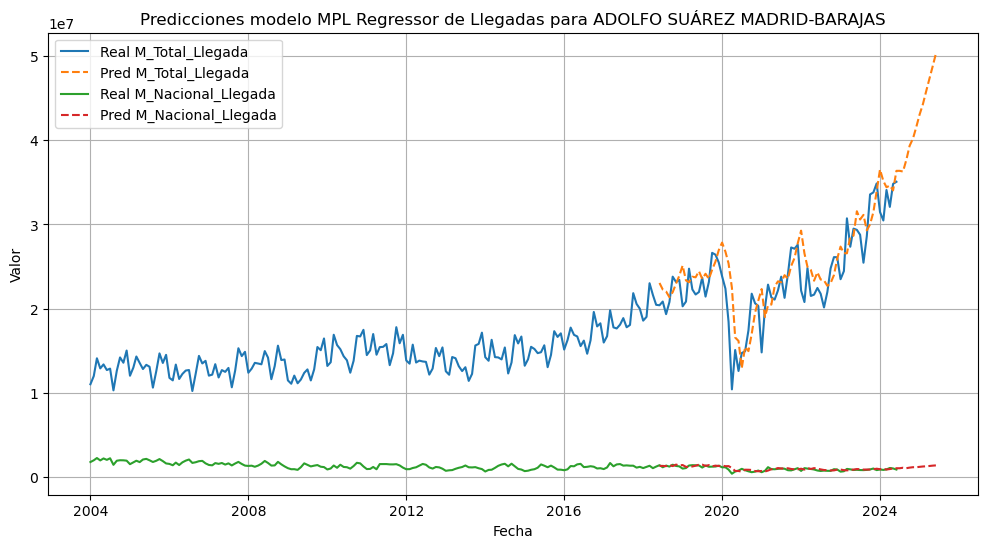

In [9]:
# Se visualizan las predicciones para un aeropuerto específico
Aeropuerto_Prediccion = 'ADOLFO SUÁREZ MADRID-BARAJAS'

# Se filtran los tipos de operación disponibles para el aeropuerto seleccionado
Tipos_Mercancia = Mercancias_Unico[Mercancias_Unico['Aeropuerto_Base'] == Aeropuerto_Prediccion]['Tipo'].unique()

# Se filtran los tipos de operación para Llegada
Tipos_Llegada = [tipo for tipo in Tipos_Mercancia if 'Llegada' in tipo]


# Gráfico para operaciones de Llegada
plt.figure(figsize=(12, 6))
for Tipo_Mercancia_Prediccion in Tipos_Llegada:
    # Se filtran los datos reales para el tipo de operación
    Datos_Reales_Mercancia_MPL = Mercancias_Unico[(Mercancias_Unico['Aeropuerto_Base'] == Aeropuerto_Prediccion) & 
                                               (Mercancias_Unico['Tipo'] == Tipo_Mercancia_Prediccion)]
    
    # Se filtran las predicciones para el tipo de operación
    Datos_Predicciones_Mercancia_MPL = Predicciones_Mercancia_MPL[(Predicciones_Mercancia_MPL['Aeropuerto_Base'] == Aeropuerto_Prediccion) & 
                                                            (Predicciones_Mercancia_MPL['Tipo'] == Tipo_Mercancia_Prediccion)]
    
    # Se añaden las series reales y predicciones al gráfico
    plt.plot(Datos_Reales_Mercancia_MPL.index, Datos_Reales_Mercancia_MPL['Valor'], label=f'Real {Tipo_Mercancia_Prediccion}')
    plt.plot(Datos_Predicciones_Mercancia_MPL['Fecha'], Datos_Predicciones_Mercancia_MPL['Prediccion'], linestyle='--', label=f'Pred {Tipo_Mercancia_Prediccion}')

# Se configura el gráfico
plt.title(f'Predicciones modelo MPL Regressor de Llegadas para {Aeropuerto_Prediccion}')
plt.xlabel('Fecha')
plt.ylabel('Valor')
plt.legend()
plt.grid(True)
plt.show()

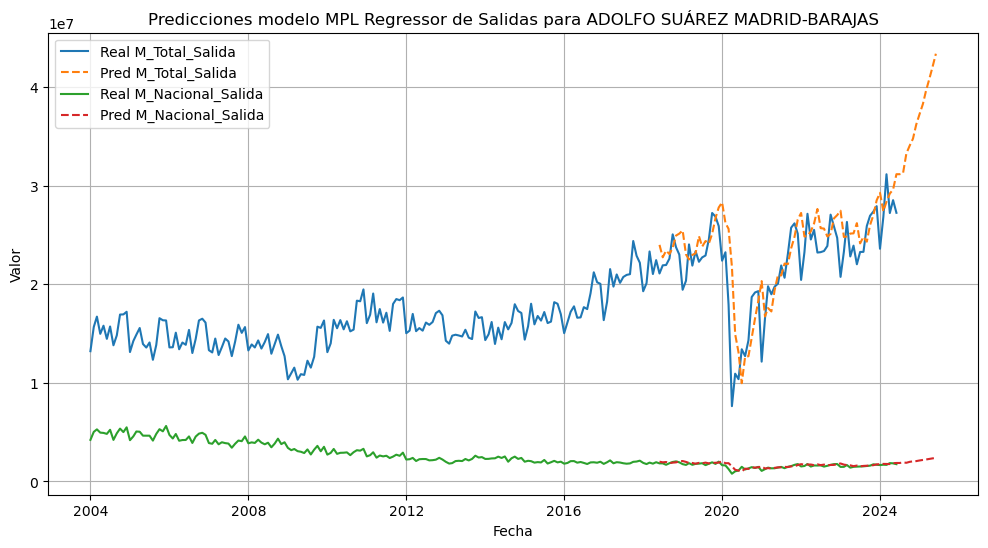

In [10]:
# Se visualizan las predicciones para un aeropuerto específico
Aeropuerto_Prediccion = 'ADOLFO SUÁREZ MADRID-BARAJAS'

# Se filtran los tipos de operación disponibles para el aeropuerto seleccionado
Tipos_Mercancia = Mercancias_Unico[Mercancias_Unico['Aeropuerto_Base'] == Aeropuerto_Prediccion]['Tipo'].unique()

# Se filtran los tipos de operación para Salida
Tipos_Salida = [tipo for tipo in Tipos_Mercancia if 'Salida' in tipo]


# Gráfico para operaciones de Salida
plt.figure(figsize=(12, 6))
for Tipo_Mercancia_Prediccion in Tipos_Salida:
    # Se filtran los datos reales para el tipo de operación
    Datos_Reales_Mercancia_MPL = Mercancias_Unico[(Mercancias_Unico['Aeropuerto_Base'] == Aeropuerto_Prediccion) & 
                                               (Mercancias_Unico['Tipo'] == Tipo_Mercancia_Prediccion)]
    
    # Se filtran las predicciones para el tipo de operación
    Datos_Predicciones_Mercancia_MPL = Predicciones_Mercancia_MPL[(Predicciones_Mercancia_MPL['Aeropuerto_Base'] == Aeropuerto_Prediccion) & 
                                                            (Predicciones_Mercancia_MPL['Tipo'] == Tipo_Mercancia_Prediccion)]
    
    # Se añaden las series reales y predicciones al gráfico
    plt.plot(Datos_Reales_Mercancia_MPL.index, Datos_Reales_Mercancia_MPL['Valor'], label=f'Real {Tipo_Mercancia_Prediccion}')
    plt.plot(Datos_Predicciones_Mercancia_MPL['Fecha'], Datos_Predicciones_Mercancia_MPL['Prediccion'], linestyle='--', label=f'Pred {Tipo_Mercancia_Prediccion}')

# Se configura el gráfico
plt.title(f'Predicciones modelo MPL Regressor de Salidas para {Aeropuerto_Prediccion}')
plt.xlabel('Fecha')
plt.ylabel('Valor')
plt.legend()
plt.grid(True)
plt.show()

**8-c. Métricas de error**

In [11]:
# Función para calcular SMAPE
def smape(y_true_MPL, y_pred_MPL):
    return 100 / len(y_true_MPL) * np.sum(2 * np.abs(y_pred_MPL - y_true_MPL) / (np.abs(y_true_MPL) + np.abs(y_pred_MPL)))

# Se añade la métrica SMAPE
Metricas_Error_Mercancia_MPL = pd.DataFrame(columns=['Aeropuerto_Base', 'Tipo', 'MAE', 'RMSE', 'MAPE', 'SMAPE'])

for (Aeropuerto, Mercancia), (Predicciones_Originales_MPL, _, Fechas_Reales) in Dicc_Predicciones_Mercancias_MPL.items():
    # Se alinean las fechas de los valores reales y predicciones
    Valores_Reales_Mercancia_MPL = Mercancias_Unico[(Mercancias_Unico['Aeropuerto_Base'] == Aeropuerto) & 
                                                 (Mercancias_Unico['Tipo'] == Mercancia)]['Valor']
    Fechas_Coincidentes = Valores_Reales_Mercancia_MPL.dropna().index.intersection(Fechas_Reales)
    Predicciones_Originales_MPL = Predicciones_Originales_MPL[Fechas_Reales.isin(Fechas_Coincidentes)]
    Valores_Reales_Mercancia_MPL = Valores_Reales_Mercancia_MPL.loc[Fechas_Coincidentes]

    # Se calculan las métricas de error si hay valores reales para comparar
    if len(Valores_Reales_Mercancia_MPL) == len(Predicciones_Originales_MPL):
        # MAE - Error Absoluto Medio
        mae = mean_absolute_error(Valores_Reales_Mercancia_MPL, Predicciones_Originales_MPL)
        # RMSE - Error Cuadrático Medio
        rmse = np.sqrt(mean_squared_error(Valores_Reales_Mercancia_MPL, Predicciones_Originales_MPL))
        # MAPE - Error Porcentual Absoluto Medio
        mape = np.mean(np.abs((Valores_Reales_Mercancia_MPL - Predicciones_Originales_MPL) / np.where(Valores_Reales_Mercancia_MPL == 0, 1, Valores_Reales_Mercancia_MPL))) * 100
        # SMAPE
        smape_value = smape(Valores_Reales_Mercancia_MPL, Predicciones_Originales_MPL)
        
        Temp_Metricas_Error_MPL = pd.DataFrame({
            'Aeropuerto_Base': [Aeropuerto],
            'Tipo': [Mercancia],
            'MAE': [mae],
            'RMSE': [rmse],
            'MAPE': [mape],
            'SMAPE': [smape_value]
        })
        # Se concatenan las métricas de error
        Metricas_Error_Mercancia_MPL = pd.concat([Metricas_Error_Mercancia_MPL, Temp_Metricas_Error_MPL], ignore_index=True)
    else:
        print(f"Las longitudes no coinciden para {Aeropuerto} - {Mercancia}")

# Se muestran las métricas
print(Metricas_Error_Mercancia_MPL)

                  Aeropuerto_Base                Tipo           MAE  \
0                        A CORUÑA     M_Total_Llegada  8.321764e+02   
1                        A CORUÑA  M_Nacional_Llegada  8.476771e+02   
2                        A CORUÑA      M_Total_Salida  1.443965e+03   
3                        A CORUÑA   M_Nacional_Salida  1.416553e+03   
4    ADOLFO SUÁREZ MADRID-BARAJAS     M_Total_Llegada  2.344728e+06   
..                            ...                 ...           ...   
191                     SON BONET   M_Nacional_Salida  1.535997e-01   
192              MURCIA COMBINADO     M_Total_Llegada  8.356066e+00   
193              MURCIA COMBINADO  M_Nacional_Llegada  5.772064e+00   
194              MURCIA COMBINADO      M_Total_Salida  5.823370e+00   
195              MURCIA COMBINADO   M_Nacional_Salida  1.379592e+00   

             RMSE          MAPE       SMAPE  
0    1.119042e+03   8054.772763   40.052189  
1    1.116215e+03   8234.184117   40.804035  
2    1.98

**8-d. Métricas de error promedias de todo el conjunto**

In [12]:
# Se calculan las métricas medias para este modelo 
MAE_promedio_MPL = Metricas_Error_Mercancia_MPL['MAE'].mean()
RMSE_promedio_MPL = Metricas_Error_Mercancia_MPL['RMSE'].mean()
MAPE_promedio_MPL = Metricas_Error_Mercancia_MPL['MAPE'].mean()
SMAPE_promedio_MPL = Metricas_Error_Mercancia_MPL['SMAPE'].mean()

# Se muestran los resultados MPL Regressor
print(f"MAE Promedio MPL Regressor: {MAE_promedio_MPL}")
print(f"RMSE Promedio MPL Regressor: {RMSE_promedio_MPL}")
print(f"MAPE Promedio MPL Regressor: {MAPE_promedio_MPL}%")
print(f"SMAPE Promedio MPL Regressor: {SMAPE_promedio_MPL}%")

MAE Promedio MPL Regressor: 63062.61031612691
RMSE Promedio MPL Regressor: 84215.78629692961
MAPE Promedio MPL Regressor: 7756.696191138484%
SMAPE Promedio MPL Regressor: 112.27293597916766%


No mejora con respecto al que ya se tenía GRID Search ARIMA (4,14)

**9. Modelo K-Vecinos**

In [13]:
# Se crea un diccionario para almacenar las predicciones
Dicc_Predicciones_Mercancias_K = {}

# Función para crear variables lag
def crear_lags(data, lags):
    df_lags = pd.DataFrame()
    for lag in range(1, lags + 1):
        df_lags[f'lag_{lag}'] = data.shift(lag)
    df_lags['Valor'] = data.values
    return df_lags.dropna()

# Se obtienen todos los aeropuertos y tipos únicos
Aeropuertos = Mercancias_Unico['Aeropuerto_Base'].unique()
Tipos_Mercancias = Mercancias_Unico['Tipo'].unique()

# Se itera sobre cada aeropuerto y tipo
for Aeropuerto in Aeropuertos:
    for Mercancia in Tipos_Mercancias:
        # Se filtra cada aeropuerto y tipo de operación para los datos originales "reales"
        Datos_Reales_Mercancia_K = Mercancias_Unico[(Mercancias_Unico['Aeropuerto_Base'] == Aeropuerto) & 
                                                   (Mercancias_Unico['Tipo'] == Mercancia)]
        
        # Se comprueba que está ordenado cronológicamente
        Datos_Reales_Mercancia_K = Datos_Reales_Mercancia_K.sort_index()

        # Se crean las variables lag 
        lags = 3
        data_lags_K = crear_lags(Datos_Reales_Mercancia_K['Valor'], lags)
        
        # Se Separa el conjunto en entrenamiento (80%) y test (20%)
        X = data_lags_K.drop(columns=['Valor'])
        y = data_lags_K['Valor']
        X_train_K, X_test_K, y_train_K, y_test_K = train_test_split(X, y, test_size=0.2, shuffle=False)
        
        # Entrenamiento y predicciones
        try:
            
            model_K = KNeighborsRegressor(n_neighbors=6)
            model_K.fit(X_train_K, y_train_K)

            # Predicciones sobre los datos históricos
            Predicciones_Originales_K = model_K.predict(X_test_K)

            # Predicciones futuras
            last_values = X_test_K.iloc[-1].values
            Predicciones_Futuras_K = []
            for _ in range(12):
                next_pred = model_K.predict(pd.DataFrame([last_values], columns=X.columns))
                Predicciones_Futuras_K.append(next_pred[0])
                last_values = np.roll(last_values, -1)
                last_values[-1] = next_pred[0]

            Predicciones_Futuras_K = pd.Series(Predicciones_Futuras_K)

            # Almacenar las predicciones en el diccionario
            Dicc_Predicciones_Mercancias_K[(Aeropuerto, Mercancia)] = (Predicciones_Originales_K, Predicciones_Futuras_K, Datos_Reales_Mercancia_K.index[-len(Predicciones_Originales_K):])

        except Exception as e:
            print(f"Error al entrenar el modelo para {Aeropuerto}, {Mercancia}: {e}")

**9-a. Dataframe en el que se guardan las predicciones y los datos reales**

In [14]:
# Se crea un dataframe para poder comparar las predicciones
Comparacion_Total_Todos_Aeropuertos_K_M = pd.DataFrame(columns=['Aeropuerto_Base', 'Tipo', 'Fecha', 'Valor Real', 'Prediccion'])

for (Aeropuerto, Mercancia), (Predicciones_Originales_K, Predicciones_Futuras_K, Fechas_Reales) in Dicc_Predicciones_Mercancias_K.items():
    # Se extraen los valores reales coincidentes con las predicciones originales
    Valores_Reales_Mercancia_K = Mercancias_Unico[(Mercancias_Unico['Aeropuerto_Base'] == Aeropuerto) & 
                                        (Mercancias_Unico['Tipo'] == Mercancia)].loc[Fechas_Reales, 'Valor']
    
    # Se comprueba que ambas longitudes coinciden
    min_len = min(len(Fechas_Reales), len(Predicciones_Originales_K), len(Valores_Reales_Mercancia_K))
    
    # Se crea un DataFrame temporal para las predicciones históricas con los valores originales
    Tem_Predicciones_Historicas_K = pd.DataFrame({
        'Aeropuerto_Base': [Aeropuerto] * min_len,
        'Tipo': [Mercancia] * min_len,
        'Fecha': Fechas_Reales[:min_len],
        'Valor Real': Valores_Reales_Mercancia_K[:min_len],
        'Prediccion': Predicciones_Originales_K[:min_len]
    })

    # Se filtran las columnas que contenga un NaN, en el caso de las históricas, son todas aquellas que pasan de la fecha de junio 2024
    Tem_Predicciones_Historicas_K = Tem_Predicciones_Historicas_K.dropna(axis=1, how='all')

    # Se crea un DataFrame temporal para las predicciones futuras
    Fechas_Futuras = pd.date_range(start=Fechas_Reales[-1] + pd.offsets.MonthBegin(1), periods=len(Predicciones_Futuras_K), freq='MS')
    Temp_Predicciones_Futuras_K = pd.DataFrame({
        'Aeropuerto_Base': [Aeropuerto] * len(Predicciones_Futuras_K),
        'Tipo': [Mercancia] * len(Predicciones_Futuras_K),
        'Fecha': Fechas_Futuras,
        'Valor Real': [None] * len(Predicciones_Futuras_K),
        'Prediccion': Predicciones_Futuras_K
    })

    # Se filtran las columnas que contenga un NaN
    Temp_Predicciones_Futuras_K = Temp_Predicciones_Futuras_MPL.dropna(axis=1, how='all')

    # Se concatena los dos dataframe (históricos y futuros)
    Comparacion_Total_Todos_Aeropuertos_K_M = pd.concat([Comparacion_Total_Todos_Aeropuertos_K_M, Tem_Predicciones_Historicas_K, Temp_Predicciones_Futuras_K], ignore_index=True)

# Se muestran las últimas filas para ver los valores reales y predicciones
print(Comparacion_Total_Todos_Aeropuertos_K_M.tail(20))

        Aeropuerto_Base               Tipo      Fecha  Valor Real  Prediccion
11936  MURCIA COMBINADO  M_Nacional_Salida 2023-11-01         0.0    0.500000
11937  MURCIA COMBINADO  M_Nacional_Salida 2023-12-01         0.0    0.500000
11938  MURCIA COMBINADO  M_Nacional_Salida 2024-01-01         0.0    0.500000
11939  MURCIA COMBINADO  M_Nacional_Salida 2024-02-01         0.0    0.500000
11940  MURCIA COMBINADO  M_Nacional_Salida 2024-03-01         0.0    0.500000
11941  MURCIA COMBINADO  M_Nacional_Salida 2024-04-01         0.0    0.500000
11942  MURCIA COMBINADO  M_Nacional_Salida 2024-05-01         0.0    0.500000
11943  MURCIA COMBINADO  M_Nacional_Salida 2024-06-01         0.0    0.500000
11944  MURCIA COMBINADO  M_Nacional_Salida 2024-07-01         NaN    1.379592
11945  MURCIA COMBINADO  M_Nacional_Salida 2024-08-01         NaN    2.828246
11946  MURCIA COMBINADO  M_Nacional_Salida 2024-09-01         NaN    2.899187
11947  MURCIA COMBINADO  M_Nacional_Salida 2024-10-01         Na

In [15]:
# Se convierten los valores a flotantes si no son nulos y no son cadenas vacías
Comparacion_Total_Todos_Aeropuertos_K_M['Valor Real'] = Comparacion_Total_Todos_Aeropuertos_K_M['Valor Real'].apply(lambda x: float(x) if pd.notnull(x) and x != '' else x)
Comparacion_Total_Todos_Aeropuertos_K_M['Prediccion'] = Comparacion_Total_Todos_Aeropuertos_K_M['Prediccion'].apply(lambda x: float(x) if pd.notnull(x) and x != '' else x)

# Se reemplazan los puntos por comas en las columnas de interés ('Valor Real' y 'Prediccion')
Comparacion_Total_Todos_Aeropuertos_K_M['Valor Real'] = Comparacion_Total_Todos_Aeropuertos_K_M['Valor Real'].apply(lambda x: f"{x:.2f}".replace('.', ',') if pd.notnull(x) else '')
Comparacion_Total_Todos_Aeropuertos_K_M['Prediccion'] = Comparacion_Total_Todos_Aeropuertos_K_M['Prediccion'].apply(lambda x: f"{x:.2f}".replace('.', ',') if pd.notnull(x) else '')

# Se muestran las últimas filas para verificar los cambios
print(Comparacion_Total_Todos_Aeropuertos_K_M.tail(20))

        Aeropuerto_Base               Tipo      Fecha Valor Real Prediccion
11936  MURCIA COMBINADO  M_Nacional_Salida 2023-11-01       0,00       0,50
11937  MURCIA COMBINADO  M_Nacional_Salida 2023-12-01       0,00       0,50
11938  MURCIA COMBINADO  M_Nacional_Salida 2024-01-01       0,00       0,50
11939  MURCIA COMBINADO  M_Nacional_Salida 2024-02-01       0,00       0,50
11940  MURCIA COMBINADO  M_Nacional_Salida 2024-03-01       0,00       0,50
11941  MURCIA COMBINADO  M_Nacional_Salida 2024-04-01       0,00       0,50
11942  MURCIA COMBINADO  M_Nacional_Salida 2024-05-01       0,00       0,50
11943  MURCIA COMBINADO  M_Nacional_Salida 2024-06-01       0,00       0,50
11944  MURCIA COMBINADO  M_Nacional_Salida 2024-07-01                  1,38
11945  MURCIA COMBINADO  M_Nacional_Salida 2024-08-01                  2,83
11946  MURCIA COMBINADO  M_Nacional_Salida 2024-09-01                  2,90
11947  MURCIA COMBINADO  M_Nacional_Salida 2024-10-01                  4,70
11948  MURCI

**9-b.Visualización de las predicciones**

In [17]:
# Se crea un DataFrame para almacenar todas las predicciones
Predicciones_Mercancia_K = pd.DataFrame(columns=['Aeropuerto_Base', 'Tipo', 'Fecha', 'Prediccion'])

for (Aeropuerto, Mercancia), (Predicciones_Originales_K, Predicciones_Futuras_K, Fechas_Reales) in Dicc_Predicciones_Mercancias_K.items():
    # Se guardan en un DataFrame temporal para las predicciones de los datos orginales "reales"
    Tem_Predicciones_Historicas_K = pd.DataFrame({
        'Aeropuerto_Base': Aeropuerto,
        'Tipo': Mercancia,
        'Fecha': Fechas_Reales,
        'Prediccion': Predicciones_Originales_K
    })

    # Se guardan en un DataFrame temporal para las predicciones de fechas futuras
    Fechas_Futuras = pd.date_range(start=Fechas_Reales[-1] + pd.offsets.MonthBegin(1), periods=len(Predicciones_Futuras_K), freq='MS')
    Temp_Predicciones_Futuras_K = pd.DataFrame({
        'Aeropuerto_Base': Aeropuerto,
        'Tipo': Mercancia,
        'Fecha': Fechas_Futuras,
        'Prediccion': Predicciones_Futuras_K
    })

    # Se concatenan ambas predicciones y se guardan en un dataframe único
    Predicciones_Mercancia_K = pd.concat([Predicciones_Mercancia_K, Tem_Predicciones_Historicas_K, Temp_Predicciones_Futuras_K], ignore_index=True)

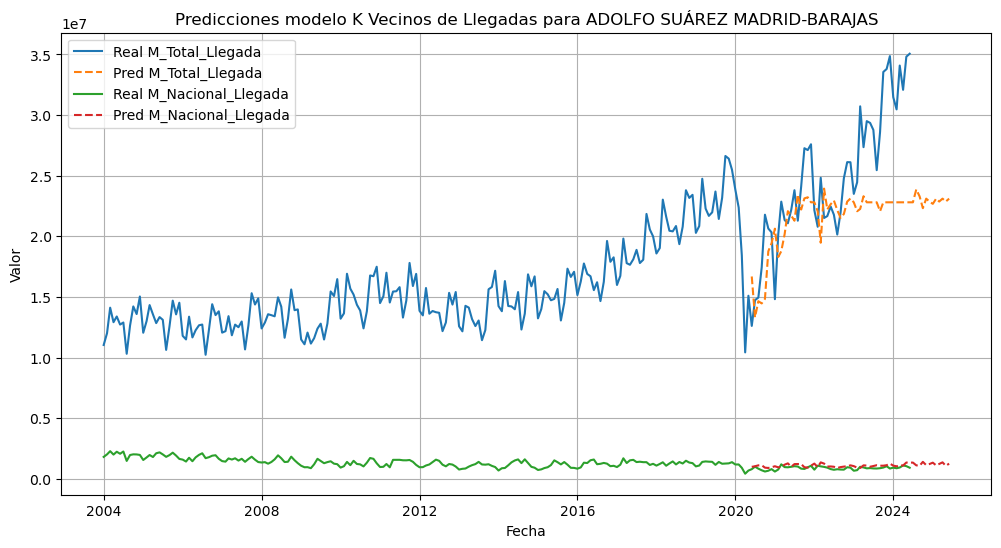

In [18]:
# Se visualizan las predicciones para un aeropuerto específico
Aeropuerto_Prediccion = 'ADOLFO SUÁREZ MADRID-BARAJAS'

# Se filtran los tipos de operación disponibles para el aeropuerto seleccionado
Tipos_Mercancia = Mercancias_Unico[Mercancias_Unico['Aeropuerto_Base'] == Aeropuerto_Prediccion]['Tipo'].unique()

# Se filtran los tipos de operación para Llegada
Tipos_Llegada = [tipo for tipo in Tipos_Mercancia if 'Llegada' in tipo]


# Gráfico para operaciones de Llegada
plt.figure(figsize=(12, 6))
for Tipo_Mercancia_Prediccion in Tipos_Llegada:
    # Se filtran los datos reales para el tipo de operación
    Datos_Reales_Mercancia_K = Mercancias_Unico[(Mercancias_Unico['Aeropuerto_Base'] == Aeropuerto_Prediccion) & 
                                               (Mercancias_Unico['Tipo'] == Tipo_Mercancia_Prediccion)]
    
    # Se filtran las predicciones para el tipo de operación
    Datos_Predicciones_Mercancia_K = Predicciones_Mercancia_K[(Predicciones_Mercancia_K['Aeropuerto_Base'] == Aeropuerto_Prediccion) & 
                                                            (Predicciones_Mercancia_K['Tipo'] == Tipo_Mercancia_Prediccion)]
    
    # Se añaden las series reales y predicciones al gráfico
    plt.plot(Datos_Reales_Mercancia_K.index, Datos_Reales_Mercancia_K['Valor'], label=f'Real {Tipo_Mercancia_Prediccion}')
    plt.plot(Datos_Predicciones_Mercancia_K['Fecha'], Datos_Predicciones_Mercancia_K['Prediccion'], linestyle='--', label=f'Pred {Tipo_Mercancia_Prediccion}')

# Se configura el gráfico
plt.title(f'Predicciones modelo K Vecinos de Llegadas para {Aeropuerto_Prediccion}')
plt.xlabel('Fecha')
plt.ylabel('Valor')
plt.legend()
plt.grid(True)
plt.show()

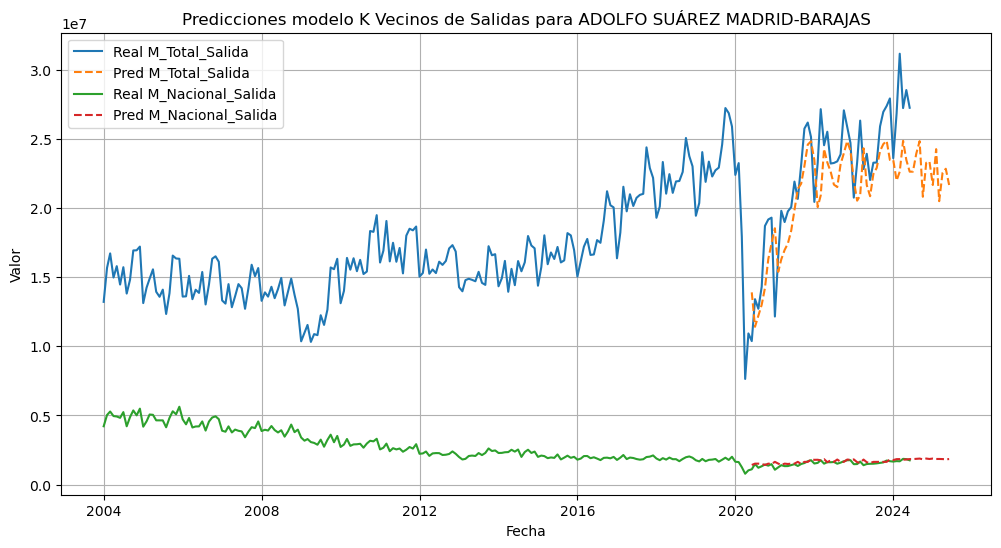

In [19]:
# Se visualizan las predicciones para un aeropuerto específico
Aeropuerto_Prediccion = 'ADOLFO SUÁREZ MADRID-BARAJAS'

# Se filtran los tipos de operación disponibles para el aeropuerto seleccionado
Tipos_Mercancia = Mercancias_Unico[Mercancias_Unico['Aeropuerto_Base'] == Aeropuerto_Prediccion]['Tipo'].unique()

# Se filtran los tipos de operación para Salida
Tipos_Salida = [tipo for tipo in Tipos_Mercancia if 'Salida' in tipo]


# Gráfico para operaciones de Salida
plt.figure(figsize=(12, 6))
for Tipo_Mercancia_Prediccion in Tipos_Salida:
    # Se filtran los datos reales para el tipo de operación
    Datos_Reales_Mercancia_K = Mercancias_Unico[(Mercancias_Unico['Aeropuerto_Base'] == Aeropuerto_Prediccion) & 
                                               (Mercancias_Unico['Tipo'] == Tipo_Mercancia_Prediccion)]
    
    # Se filtran las predicciones para el tipo de operación
    Datos_Predicciones_Mercancia_K = Predicciones_Mercancia_K[(Predicciones_Mercancia_K['Aeropuerto_Base'] == Aeropuerto_Prediccion) & 
                                                            (Predicciones_Mercancia_K['Tipo'] == Tipo_Mercancia_Prediccion)]
    
    # Se añaden las series reales y predicciones al gráfico
    plt.plot(Datos_Reales_Mercancia_K.index, Datos_Reales_Mercancia_K['Valor'], label=f'Real {Tipo_Mercancia_Prediccion}')
    plt.plot(Datos_Predicciones_Mercancia_K['Fecha'], Datos_Predicciones_Mercancia_K['Prediccion'], linestyle='--', label=f'Pred {Tipo_Mercancia_Prediccion}')

# Se configura el gráfico
plt.title(f'Predicciones modelo K Vecinos de Salidas para {Aeropuerto_Prediccion}')
plt.xlabel('Fecha')
plt.ylabel('Valor')
plt.legend()
plt.grid(True)
plt.show()

**9-c. Métricas de error**

In [20]:
# Función para calcular SMAPE
def smape(y_true_K, y_pred_K):
    return 100 / len(y_true_K) * np.sum(2 * np.abs(y_pred_K - y_true_K) / (np.abs(y_true_K) + np.abs(y_pred_K)))

# Se añade la métrica SMAPE
Metricas_Error_Mercancia_K = pd.DataFrame(columns=['Aeropuerto_Base', 'Tipo', 'MAE', 'RMSE', 'MAPE', 'SMAPE'])

for (Aeropuerto, Mercancia), (Predicciones_Originales_K, _, Fechas_Reales) in Dicc_Predicciones_Mercancias_K.items():
    # Se alinean las fechas de los valores reales y predicciones
    Valores_Reales_Mercancia_K = Mercancias_Unico[(Mercancias_Unico['Aeropuerto_Base'] == Aeropuerto) & 
                                                 (Mercancias_Unico['Tipo'] == Mercancia)]['Valor']
    Fechas_Coincidentes = Valores_Reales_Mercancia_K.dropna().index.intersection(Fechas_Reales)
    Predicciones_Originales_K = Predicciones_Originales_K[Fechas_Reales.isin(Fechas_Coincidentes)]
    Valores_Reales_Mercancia_K = Valores_Reales_Mercancia_K.loc[Fechas_Coincidentes]

    # Se calculan las métricas de error si hay valores reales para comparar
    if len(Valores_Reales_Mercancia_K) == len(Predicciones_Originales_K):
        # MAE - Error Absoluto Medio
        mae = mean_absolute_error(Valores_Reales_Mercancia_K, Predicciones_Originales_K)
        # RMSE - Error Cuadrático Medio
        rmse = np.sqrt(mean_squared_error(Valores_Reales_Mercancia_K, Predicciones_Originales_K))
        # MAPE - Error Porcentual Absoluto Medio
        mape = np.mean(np.abs((Valores_Reales_Mercancia_K - Predicciones_Originales_K) / np.where(Valores_Reales_Mercancia_K == 0, 1, Valores_Reales_Mercancia_K))) * 100
        # SMAPE
        smape_value = smape(Valores_Reales_Mercancia_K, Predicciones_Originales_K)
        
        Temp_Metricas_Error_K = pd.DataFrame({
            'Aeropuerto_Base': [Aeropuerto],
            'Tipo': [Mercancia],
            'MAE': [mae],
            'RMSE': [rmse],
            'MAPE': [mape],
            'SMAPE': [smape_value]
        })
        # Se concatenan las métricas de error
        Metricas_Error_Mercancia_K = pd.concat([Metricas_Error_Mercancia_K, Temp_Metricas_Error_K], ignore_index=True)
    else:
        print(f"Las longitudes no coinciden para {Aeropuerto} - {Mercancia}")

# Se muestran las métricas
print(Metricas_Error_Mercancia_K)

                  Aeropuerto_Base                Tipo           MAE  \
0                        A CORUÑA     M_Total_Llegada  1.038905e+03   
1                        A CORUÑA  M_Nacional_Llegada  1.015262e+03   
2                        A CORUÑA      M_Total_Salida  1.623534e+03   
3                        A CORUÑA   M_Nacional_Salida  1.694412e+03   
4    ADOLFO SUÁREZ MADRID-BARAJAS     M_Total_Llegada  4.375850e+06   
..                            ...                 ...           ...   
191                     SON BONET   M_Nacional_Salida  0.000000e+00   
192              MURCIA COMBINADO     M_Total_Llegada  0.000000e+00   
193              MURCIA COMBINADO  M_Nacional_Llegada  6.666667e+00   
194              MURCIA COMBINADO      M_Total_Salida  9.833333e+00   
195              MURCIA COMBINADO   M_Nacional_Salida  5.000000e-01   

             RMSE         MAPE       SMAPE  
0    1.193943e+03  3690.499155   53.246906  
1    1.157259e+03  3689.327634   52.976253  
2    2.07589

**9-d. Métricas de error promedias de todo el conjunto**

In [21]:
# Se calculan las métricas medias para este modelo 
MAE_promedio_K = Metricas_Error_Mercancia_K['MAE'].mean()
RMSE_promedio_K = Metricas_Error_Mercancia_K['RMSE'].mean()
MAPE_promedio_K = Metricas_Error_Mercancia_K['MAPE'].mean()
SMAPE_promedio_K = Metricas_Error_Mercancia_K['SMAPE'].mean()

# Se muestran los resultados K Vecinos
print(f"MAE Promedio K Vecinos: {MAE_promedio_K}")
print(f"RMSE Promedio K Vecinos: {RMSE_promedio_K}")
print(f"MAPE Promedio K Vecinos: {MAPE_promedio_K}%")
print(f"SMAPE Promedio K Vecinos: {SMAPE_promedio_K}%")

MAE Promedio K Vecinos: 71877.33307302513
RMSE Promedio K Vecinos: 89467.63761197824
MAPE Promedio K Vecinos: 11399.351535761487%
SMAPE Promedio K Vecinos: 58.75773484004094%


Este modelo tampoco ha mejorado

Por lo que después de haber probado 9 modelos y no conseguir que mejora, se determina que el mejor modelo al igual que ocurrió con el de operaciones y pasajeros, es el mismo.
Modelo ganador:  **GRID SEARCH ARIMA (4,1,4)**

### C. Guardar mejor modelo

In [33]:
# Se guardan los parámetros del modelo para cada aeropuerto
for (Aeropuerto, Mercancia), model_fit_arima_GS in Dicc_Predicciones_Mercancias_GS2.items():
    # Se limpian los nombres de archivos para que sean válidos
    nombre_aeropuerto = re.sub(r'[^\w\s]', '_', Aeropuerto)  # Reemplaza caracteres no alfanuméricos con guion bajo
    nombre_Mercancia = re.sub(r'[^\w\s]', '_', Mercancia)
    
    # Se guarda el modelo usando joblib
    try:
        joblib.dump(model_fit_arima_GS, f'modelo_GRIDSEARCHARIMA(4,1,4)_{nombre_aeropuerto}_{nombre_Mercancia}.pkl')
    except Exception as e:
        print(f"Error al guardar el modelo para {Aeropuerto}, {Mercancia}: {e}")

### D. Guardar predicciones

In [31]:
# Se especifica la ruta en la que se van a guardar el dataframe
Ruta_Mercancias_Prediccion = './Ficheros_Predicciones'

# Se crea la carpeta en la que se van a guardar, si esta no existe
if not os.path.exists(Ruta_Mercancias_Prediccion):
    # Si la carpeta no existe, se crea
    os.makedirs(Ruta_Mercancias_Prediccion)
    print(f"Carpeta creada: {Ruta_Mercancias_Prediccion}")
else:
    # Si la carpeta ya existe, se muestra un mensaje
    print(f"La carpeta ya existe: {Ruta_Mercancias_Prediccion}")

La carpeta ya existe: ./Ficheros_Predicciones


In [32]:
# Ruta para guardar las predicciones
Ruta_Mercancias_Prediccion = './Ficheros_Predicciones/Predicciones_Mercancias.csv'

# Se reemplazan las comas por puntos en la columna 'Prediccion'
Comparacion_Total_Todos_Aeropuertos_GS2_M['Prediccion'] = Comparacion_Total_Todos_Aeropuertos_GS2_M['Prediccion'].str.replace(',', '.')

# Se convierte la columna 'Prediccion' a float
Comparacion_Total_Todos_Aeropuertos_GS2_M['Prediccion'] = Comparacion_Total_Todos_Aeropuertos_GS2_M['Prediccion'].astype(float)

# Se guarda el DataFrame en un archivo CSV con el formato correcto para los flotantes
Comparacion_Total_Todos_Aeropuertos_GS2_M.to_csv(Ruta_Mercancias_Prediccion, index=False, encoding='utf-8', decimal=',')

print(f"Predicciones de operaciones guardadas en: {Ruta_Mercancias_Prediccion}")

Predicciones de operaciones guardadas en: ./Ficheros_Predicciones/Predicciones_Mercancias.csv
